# Data 0~4

In [72]:
from google.colab import drive
drive.mount('/content/drive')
path= r'/content/drive/MyDrive/Time Series Project/Stock Price/Model/Transformer_model_path/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Input, Flatten, Concatenate
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 첫 번째 GPU 메모리를 다 사용할 수 있도록 설정 (필요에 따라 조정 가능)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is set to be used.")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPU found. Using CPU instead.")

GPU is set to be used.


In [74]:
def preprocess_data(df, features, target):
    """
    데이터셋 전처리 함수
    :param df: 데이터프레임
    :param features: 피처 리스트
    :param target: 타겟 리스트
    :return: 스케일링된 Train, Validation, Test 데이터셋
    """
    # 데이터프레임 인덱스 설정
    df.set_index('Date', inplace=True)

    # 입력 데이터와 타겟 데이터 분리
    x = df[features].values
    y = df[target].values

    # Train, Validation, Test 데이터 분할
    x_train = x[:3519]
    y_train = y[:3519]

    x_val = x[3519:4692]
    y_val = y[3519:4692]

    x_test = x[4692:]
    y_test = y[4692:]

    # MinMax 스케일링 객체 생성
    x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

    # 훈련 데이터로 스케일러 학습 및 변환
    x_train_scaled = x_scaler.fit_transform(x_train)
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))

    # 검증 및 테스트 데이터 변환 (fit 없이 transform만 수행)
    x_val_scaled = x_scaler.transform(x_val)
    y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))

    x_test_scaled = x_scaler.transform(x_test)
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

    return x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, x_test_scaled, y_test_scaled, y_scaler

In [75]:
features = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction','SE_Operating_Profit', 'SE_Net_Profit', 'SE_Total_Equity',
       'SE_Total_Liabilities', 'SE_Revenue', 'SE_Foreign', 'US_Inflation', 'KR_Inflation', 'CN_Inflation', 'US_GDP_Annual', 'KR_GDP_Annual',
       'CN_GDP_Annual', 'US_Economic_Growth_Rate', 'KR_Economic_Growth_Rate', 'US_Base', 'US_10', 'KR_Base', 'KR_10', 'WTI', 'Exchange', 'SOX_Close',
       'Phone', 'KR_Unemployment', 'Covid19', 'US_President_Republican', 'US_President_Democratic', 'KR_President_Democratic', 'KR_President_Conservative', 'KR_President_Neutral',
       'BB_High', 'BB_Low', 'RSI', 'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility', 'Lag_1', 'Lag_30', 'Lag_60', 'Lag_90']

# << feature selec >>
features0_same = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction', 'US_10',  'WTI', 'Exchange',
      'BB_High', 'BB_Low', 'RSI', 'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility', 'Lag_1', 'Lag_30', 'Lag_60', 'Lag_90']

features0_int = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction', 'BB_High', 'BB_Low', 'RSI', 'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility', 'Lag_1']

features2_same = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction', 'BB_Low', 'RSI', 'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility', 'Lag_1', 'Lag_30']

features2_int = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction', 'WTI', 'SOX_Close',
       'BB_High', 'BB_Low', 'RSI', 'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility', 'Lag_1', 'Lag_30', 'Lag_60', 'Lag_90']

# features4 = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction', 'SE_Foreign', 'US_Inflation', 'KR_Inflation', 'CN_GDP_Annual',
#              'US_Economic_Growth_Rate', 'KR_Economic_Growth_Rate', 'KR_10', 'WTI', 'Exchange', 'SOX_Close', 'KR_Unemployment']
target = ['Close']

In [76]:
### 0번 threshold 40으로
features0_int_thr40 = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction','KR_Economic_Growth_Rate',  'US_10', 'WTI', 'SOX_Close','KR_Unemployment',
       'BB_High', 'BB_Low', 'RSI', 'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility', 'Lag_1', 'Lag_30', 'Lag_90']

int0 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_final.csv')
x_train_int0_thr40, y_train_int0_thr40, x_val_int0_thr40, y_val_int0_thr40, x_test_int0_thr40, y_test_int0_thr40, y_scaler_int0_thr40 = preprocess_data(int0, features0_int_thr40, target)

In [77]:
### 최종
same_df = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/same_final.csv')
int_df = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_final.csv')
x_train_same_df, y_train_same_df, x_val_same_df, y_val_same_df, x_test_same_df, y_test_same_df, y_scaler_same_df = preprocess_data(same_df, features, target)
x_train_int_df, y_train_int_df, x_val_int_df, y_val_int_df, x_test_int_df, y_test_int_df, y_scaler_int_df = preprocess_data(int_df, features, target)

In [78]:
### 0번 (최종 + feature selec)
same0 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/same_final.csv')
int0 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_final.csv')
x_train_same0, y_train_same0, x_val_same0, y_val_same0, x_test_same0, y_test_same0, y_scaler_same0 = preprocess_data(same0, features0_same, target)
x_train_int0, y_train_int0, x_val_int0, y_val_int0, x_test_int0, y_test_int0, y_scaler_int0 = preprocess_data(int0, features0_int, target)

In [79]:
### 1번 (out제거전)
same1 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/same_no_outlier.csv')
int1 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_no_outlier.csv')
x_train_same1, y_train_same1, x_val_same1, y_val_same1, x_test_same1, y_test_same1, y_scaler_same1 = preprocess_data(same1, features, target)
x_train_int1, y_train_int1, x_val_int1, y_val_int1, x_test_int1, y_test_int1, y_scaler_int1 = preprocess_data(int1, features, target)

In [80]:
### 2번 (out제거전 + feature selec)
same1 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/same_no_outlier.csv')
int1 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_no_outlier.csv')
x_train_same2, y_train_same2, x_val_same2, y_val_same2, x_test_same2, y_test_same2, y_scaler_same2 = preprocess_data(same1, features2_same, target)
x_train_int2, y_train_int2, x_val_int2, y_val_int2, x_test_int2, y_test_int2, y_scaler_int2 = preprocess_data(int1, features2_int, target)

In [81]:
# ### 3번 (out제거전 + standard)
# same3 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/same_no_outlier_scaling.csv')
# int3 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_no_outlier_scaling.csv')
# x_train_same3, y_train_same3, x_val_same3, y_val_same3, x_test_same3, y_test_same3 = preprocess_data(same3, features, target)
# x_train_int3, y_train_int3, x_val_int3, y_val_int3, x_test_int3, y_test_int3 = preprocess_data(int3, features, target)

# ### 4번 (out제거전 + standard + feature selec)
# same3 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/same_no_outlier_scaling.csv')
# int3 = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_no_outlier_scaling.csv')
# x_train_same4, y_train_same4, x_val_same4, y_val_same4, x_test_same4, y_test_same4 = preprocess_data(same3, features4, target)
# x_train_int4, y_train_int4, x_val_int4, y_val_int4, x_test_int4, y_test_int4 = preprocess_data(int3, features4, target)

# Function

In [82]:
def lossplot(history, figsize=(10, 6)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Transformer Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_validation_metrics(history, figsize=(15, 12)):
    """
    Plot training and validation metrics for MSE, MAE, RMSE, and R².

    Parameters:
        history (dict): Dictionary containing 'train_loss', 'val_loss', and other metrics.
        figsize (tuple): Size of the overall figure.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Extract training and validation metrics
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_mae = history['train_mae']
    val_mae = history['val_mae']
    train_rmse = np.sqrt(train_loss)
    val_rmse = np.sqrt(val_loss)

    # Compute R² scores
    train_r2 = history.get('train_r2', [0] * len(epochs))
    val_r2 = history.get('val_r2', [0] * len(epochs))

    # Print metric values
    print("Final Metric Values:")
    print(f"Train Loss (MSE): {train_loss[-1]}")
    print(f"Validation Loss (MSE): {val_loss[-1]}")
    print(f"Train MAE: {train_mae[-1]}")
    print(f"Validation MAE: {val_mae[-1]}")
    print(f"Train RMSE: {train_rmse[-1]}")
    print(f"Validation RMSE: {val_rmse[-1]}")
    print(f"Train R²: {train_r2[-1]}")
    print(f"Validation R²: {val_r2[-1]}\n")

    metrics = {
        'MSE': (train_loss, val_loss),
        'MAE': (train_mae, val_mae),
        'RMSE': (train_rmse, val_rmse),
        'R²': (train_r2, val_r2),
    }

    # Plot metrics
    plt.figure(figsize=figsize)

    for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics.items()):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs, train_metric, label=f'Train {metric_name}', color='blue')
        plt.plot(epochs, val_metric, label=f'Validation {metric_name}', color='orange')
        plt.title(metric_name)
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [83]:
ddf = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/int_final.csv')
ddf['Date'] = pd.to_datetime(ddf['Date'])
dates = ddf['Date']
dates.info()
test_dates = ddf['Date'][4782:] ###4692 ###4782
###테스트 시작 날짜: dates.iloc[4692:]

<class 'pandas.core.series.Series'>
RangeIndex: 5865 entries, 0 to 5864
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
5865 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 45.9 KB


In [84]:
import matplotlib.dates as mdates

def predictplot(model, x_test, y_test, scaler, dates, figsize=(15, 6)):
    # 예측 수행
    y_pred = model.predict(x_test)

    # 스케일 복원
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_test_actual = np.exp(y_test_actual)
    y_pred_actual = np.exp(y_pred_actual)

    # 오차 계산
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))


    # 평가 지표 출력
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    dates = dates.iloc[-len(y_test):]

    # 예측 결과 시각화
    plt.figure(figsize=figsize)
    plt.plot(dates, y_test_actual, label="Actual Price", color="b")
    plt.plot(dates, y_pred_actual, label="Predicted Price", color="r", alpha=0.7)
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [107]:
import datetime

def simple_feature_generator(current_input, prediction):
    """
    피처 값을 단순히 이전 값으로 유지하는 예제 함수
    """
    last_features = current_input[0, -1, :-1]  # 마지막 피처 값 가져오기
    return last_features

def predict_future_dynamic(model, x_test, scaler, steps=90, feature_generator=None):
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]
        prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
        prediction_inverse = np.exp(prediction_inverse)
        print(f"Day {i+1} Prediction: {prediction_inverse}")

        # 동적으로 불확실성 계산 (처음에는 좁고 끝으로 갈수록 퍼지는 영역)
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 비율 증가 (처음에는 2%, 끝에는 약 12%까지)

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), np.array(upper_bounds), np.array(lower_bounds)

def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

korea_holidays = pd.to_datetime([
    '2024-09-16', '2024-09-17', '2024-09-18',
    '2024-10-01', '2024-10-03', '2024-10-09',
])

def get_trading_days(start_date, periods, holidays):
    """
    시작 날짜부터 주말 및 공휴일을 제외한 거래일 계산
    """
    trading_days = []
    current_date = start_date
    while len(trading_days) < periods:
        if current_date.weekday() < 5 and current_date not in holidays:  # 주말 및 공휴일 제외
            trading_days.append(current_date)
        current_date += datetime.timedelta(days=1)
    return pd.to_datetime(trading_days)


future_dates = get_trading_days(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=51, holidays=korea_holidays)
feature_generator = simple_feature_generator

In [86]:
real_4th = pd.read_csv('/content/drive/MyDrive/Time Series Project/Stock Price/data/real_final_data/samsung_stock_now.csv')
real_4th.head()

real_4th = real_4th.iloc[2:]
real_4th['Price'] = pd.to_datetime(real_4th['Price'])
real_4th = real_4th.set_index('Price')
real_4th.head()

real_close = real_4th['Close'].astype(float)

# Transformer (다시 keras)

In [87]:
def create_sequences(data, target, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 5  # 예: 30일간의 데이터를 기반으로 예측
x_train, y_train = create_sequences(x_train_same_df, y_train_same_df, seq_length)
x_val, y_val = create_sequences(x_val_same_df, y_val_same_df, seq_length)
x_test, y_test = create_sequences(x_test_same_df, y_test_same_df, seq_length)

In [88]:
from tensorflow.keras import layers, models

class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super().__init__(**kwargs)
        self.pos_encoding = self._get_positional_encoding(sequence_length, d_model)

    def _get_positional_encoding(self, seq_len, d_model):
        angle_rads = self._get_angles(np.arange(seq_len)[:, np.newaxis],
                                      np.arange(d_model)[np.newaxis, :],
                                      d_model)
        # 짝수 인덱스에는 sin, 홀수 인덱스에는 cos 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def _get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 트랜스포머 블록 정의
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    # 멀티헤드 어텐션
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # 잔차 연결

    # 피드포워드 네트워크
    ffn_output = layers.Dense(ff_dim, activation="relu")(out1)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)  # 잔차 연결

    return out2

# 트랜스포머 모델 정의
def build_transformer_model(input_shape, num_heads=4, key_dim=64, ff_dim=128, num_blocks=2, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)

    # 포지셔널 인코딩 추가
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=input_shape[1])(inputs)

    # 여러 개의 트랜스포머 블록 쌓기
    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_rate)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation="linear")(x)

    model = tf.keras.Model(inputs, outputs)
    return model


# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.96,
#     staircase=True)


# input_shape = (seq_length, x_train.shape[2])
# model = build_transformer_model(input_shape)
# model.compile(optimizer="adam", loss="mse", metrics=["mae"])
#model.summary()

In [89]:
def train_model(x_train, y_train, x_val, y_val,
                num_heads=4, key_dim=64, ff_dim=128, num_blocks=2, dropout_rate=0.2, lr=0.001,
                initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.96, staircase=True,
                epochs=200, batch_size=32):

    lrs = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=staircase
    )

    input_shape = (seq_length, x_train.shape[2])
    model = build_transformer_model(input_shape, num_heads, key_dim, ff_dim, num_blocks, dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=["mae"])

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
    )
    return history, model

# !! Final+Selec: Same (0)

In [ ]:
seq_length = 90  # 예: 30일간의 데이터를 기반으로 예측
x_train, y_train = create_sequences(x_train_same0, y_train_same0, seq_length)
x_val, y_val = create_sequences(x_val_same0, y_val_same0, seq_length)
x_test, y_test = create_sequences(x_test_same0, y_test_same0, seq_length)

###1 (seq_len=90)

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
54/54 - 60s - 1s/step - loss: 0.3170 - mae: 0.4136 - val_loss: 0.1647 - val_mae: 0.3232
Epoch 2/100
54/54 - 82s - 2s/step - loss: 0.0482 - mae: 0.1716 - val_loss: 0.1161 - val_mae: 0.2679
Epoch 3/100
54/54 - 82s - 2s/step - loss: 0.0295 - mae: 0.1347 - val_loss: 0.1156 - val_mae: 0.2621
Epoch 4/100
54/54 - 81s - 2s/step - loss: 0.0248 - mae: 0.1244 - val_loss: 0.1071 - val_mae: 0.2518
Epoch 5/100
54/54 - 86s - 2s/step - loss: 0.0206 - mae: 0.1137 - val_loss: 0.0931 - val_mae: 0.2351
Epoch 6/100
54/54 - 78s - 1s/step - loss: 0.0200 - mae: 0.1110 - val_loss: 0.0914 - val_mae: 0.2314
Epoch 7/100
54/54 - 47s - 862ms/step - loss: 0.0176 - mae: 0.1059 - val_loss: 0.0764 - val_mae: 0.2124
Epoch 8/100
54/54 - 82s - 2s/step - loss: 0.0170 - mae: 0.1036 - val_loss: 0.0680 - val_mae: 0.1993
Epoch 9/100
54/54 - 82s - 2s/step - loss: 0.0162 - mae: 0.1006 - val_loss: 0.0605 - val_mae: 0.1894
Epoch 10/100
54/54 - 86s - 2s/step - loss: 0.0155 - mae: 0.0998 - val_loss: 0.0545 - val_mae: 0.1

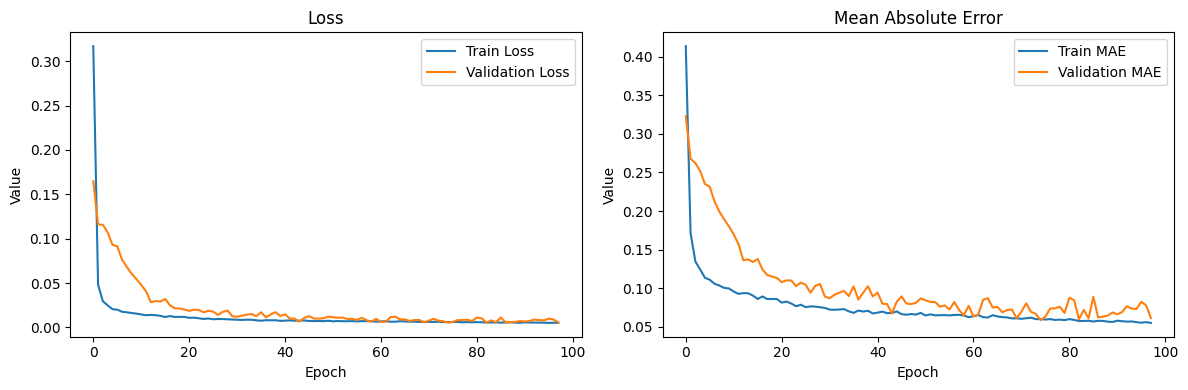

In [ ]:
lossplot(history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step
Mean Absolute Error (MAE): 0.44405265512419123
Root Mean Squared Error (RMSE): 0.4527752105658444


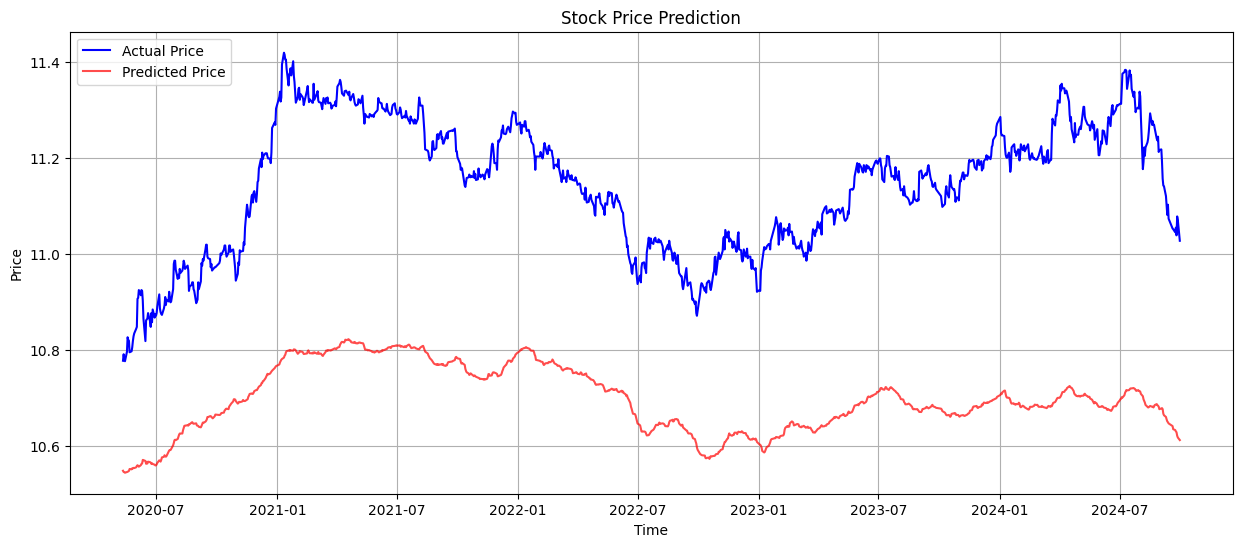

In [ ]:
predictplot(model, x_test, y_test, y_scaler, dates)
# model.save_weights(path+ 'ver0_int7.weights.h5')
# model.save(path+'ver0_int7Model.h5')
# model.save(path+'ver0_int7Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 1 Prediction: 1.1045663356781006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 2 Prediction: 1.1000757217407227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 3 Prediction: 1.0956671237945557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 4 Prediction: 1.0926536321640015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 5 Prediction: 1.0902372598648071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 6 Prediction: 1.087870717048645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 7 Prediction: 1.084775686264038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 8 Prediction: 1.0832493305206299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 9 Prediction: 1.0823800563812256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 10 Prediction: 1.0809721946716309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 11 Prediction: 1.0786330699920654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 12 Prediction: 1.0742487907409668
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 13 Prediction: 1.070332407951355
1/1 ━━━━━━━━━━━━━━━━━━━━

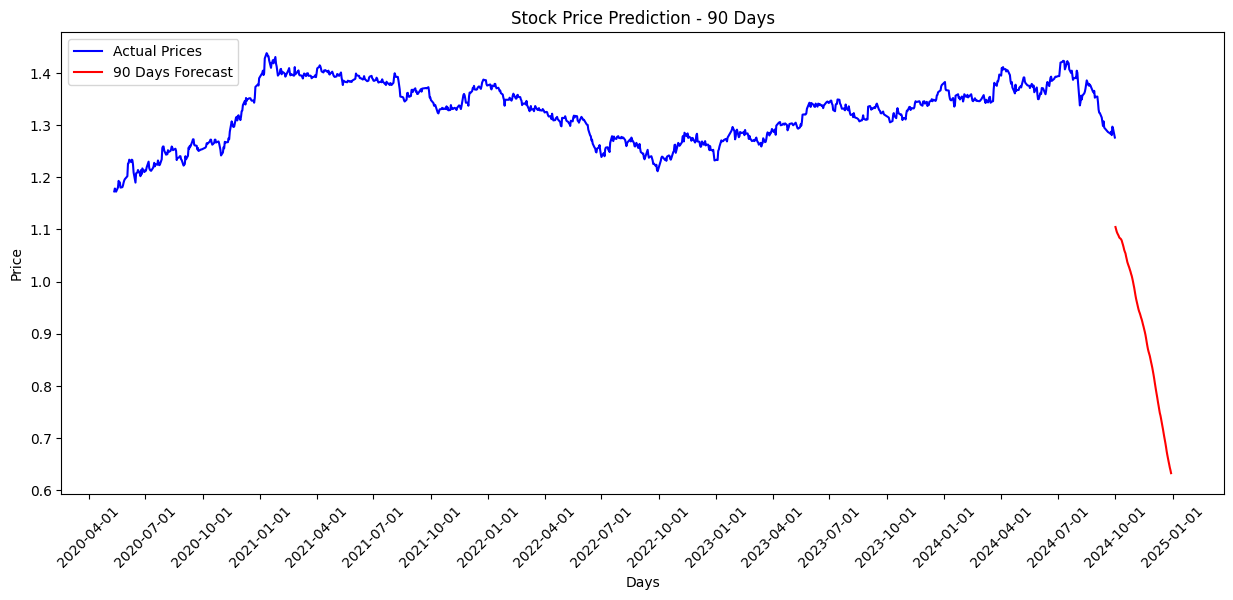

In [ ]:
def predict_future(model, x_test, steps=90):
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 입력 시퀀스를 선택

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        print(f"Day {i+1} Prediction: {prediction}")  # 각 예측값 출력

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)

test_dates = ddf['Date'][4782:]
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)
future_90_days = predict_future(model, x_test, steps=90)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 포맷 지정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 주요 틱을 월 단위로 표시
plt.xticks(rotation=45)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

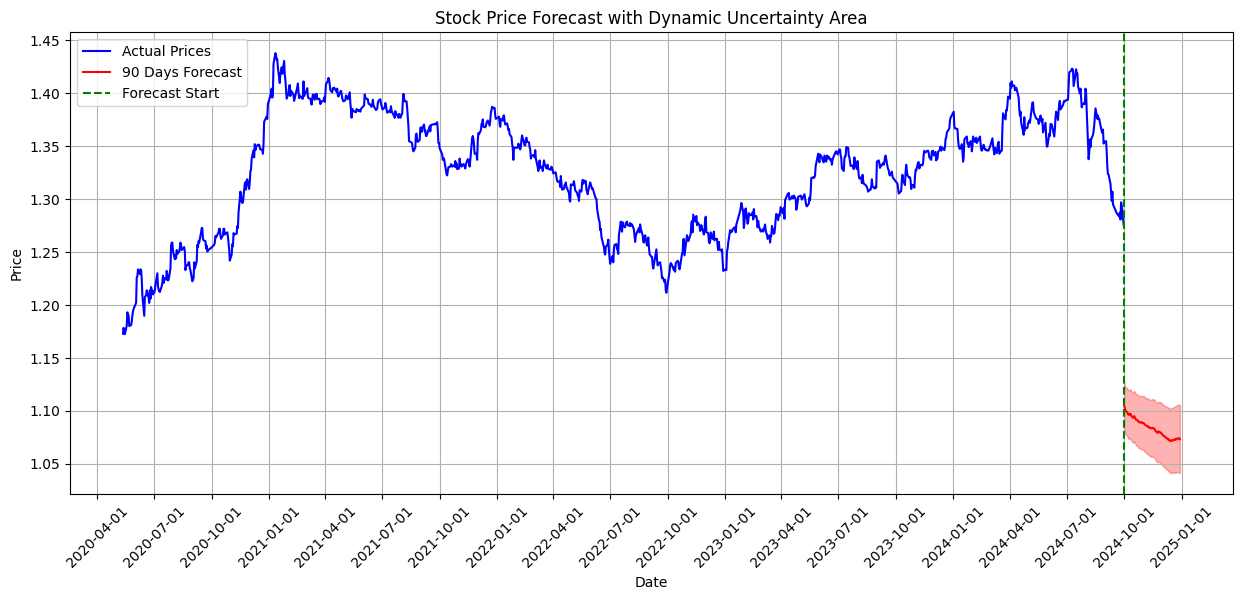

In [ ]:
def predict_future_dynamic(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 동적으로 불확실성 계산 (처음에는 좁고 끝으로 갈수록 퍼지는 영역)
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 비율 증가 (처음에는 2%, 끝에는 약 12%까지)

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), np.array(upper_bounds), np.array(lower_bounds)

def simple_feature_generator(current_input, prediction):
    """
    피처 값을 단순히 이전 값으로 유지하는 예제 함수
    """
    last_features = current_input[0, -1, :-1]  # 마지막 피처 값 가져오기
    return last_features

feature_generator = simple_feature_generator
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

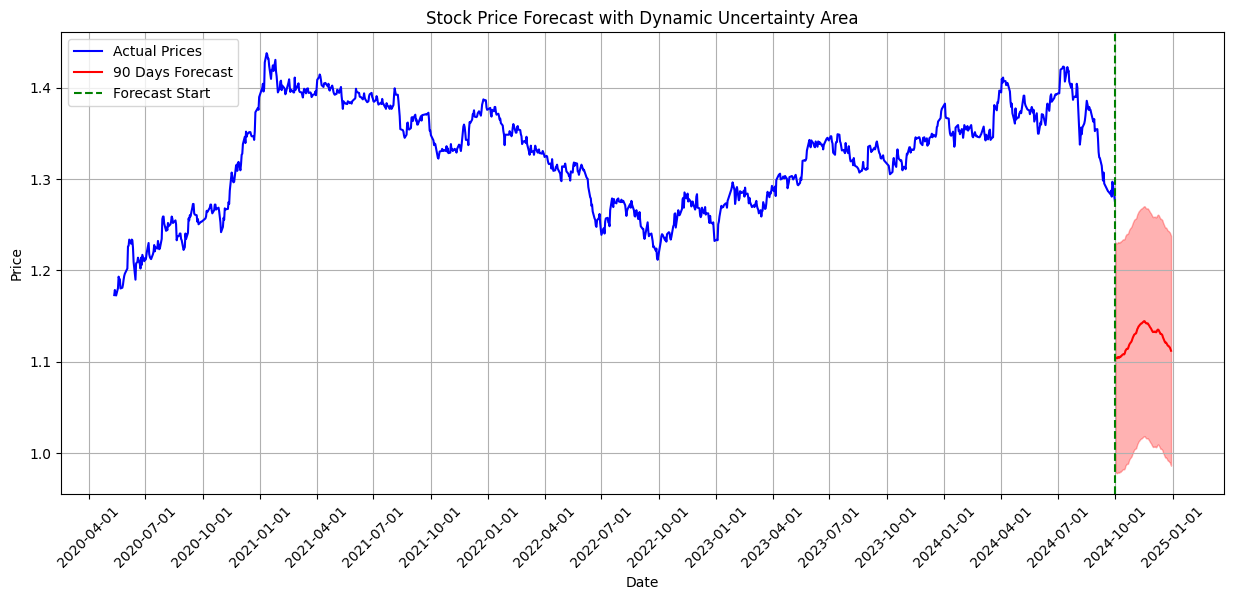

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound



future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()


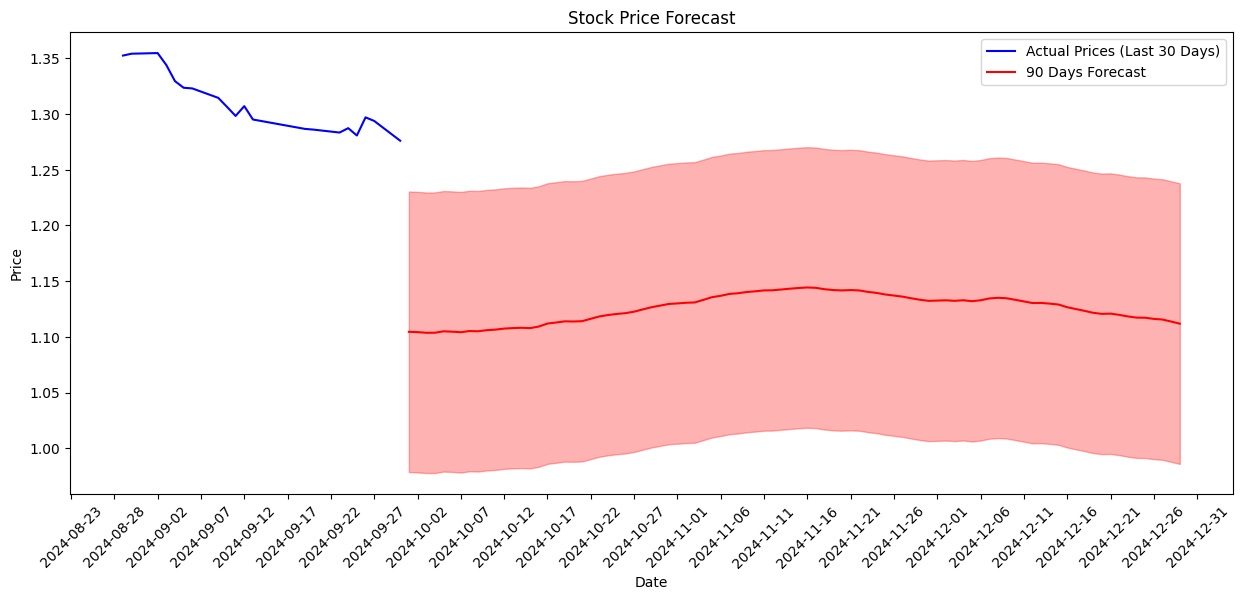

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
#plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

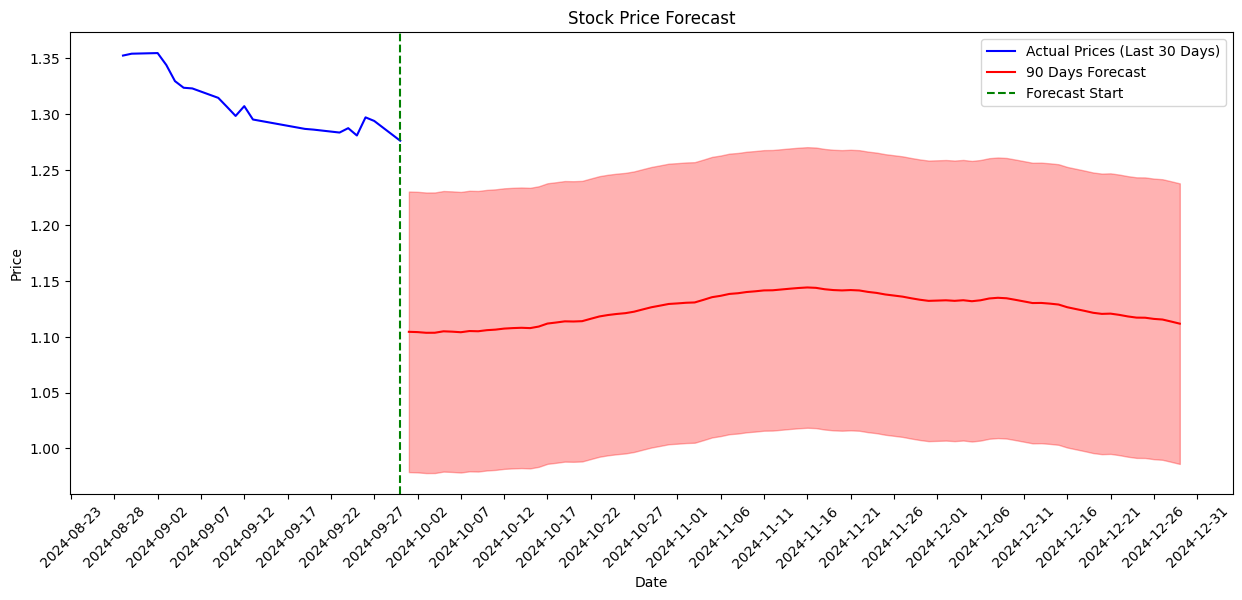

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


#!! Final+Selec: Interp (0)

In [19]:
seq_length = 5  # 예: 30일간의 데이터를 기반으로 예측
x_train, y_train = create_sequences(x_train_int0, y_train_int0, seq_length)
x_val, y_val = create_sequences(x_val_int0, y_val_int0, seq_length)
x_test, y_test = create_sequences(x_test_int0, y_test_int0, seq_length)

###1

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=3, dropout_rate=0.3,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#model.save_weights(path+ 'f_int1')
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 17s - 306ms/step - loss: 0.2573 - mae: 0.3537 - val_loss: 0.1559 - val_mae: 0.3696
Epoch 2/100
55/55 - 6s - 104ms/step - loss: 0.0521 - mae: 0.1805 - val_loss: 0.1131 - val_mae: 0.2805
Epoch 3/100
55/55 - 3s - 56ms/step - loss: 0.0376 - mae: 0.1537 - val_loss: 0.1068 - val_mae: 0.2679
Epoch 4/100
55/55 - 3s - 56ms/step - loss: 0.0272 - mae: 0.1289 - val_loss: 0.0979 - val_mae: 0.2423
Epoch 5/100
55/55 - 8s - 137ms/step - loss: 0.0227 - mae: 0.1174 - val_loss: 0.0970 - val_mae: 0.2380
Epoch 6/100
55/55 - 8s - 149ms/step - loss: 0.0206 - mae: 0.1118 - val_loss: 0.0844 - val_mae: 0.2212
Epoch 7/100
55/55 - 4s - 80ms/step - loss: 0.0186 - mae: 0.1061 - val_loss: 0.0769 - val_mae: 0.2059
Epoch 8/100
55/55 - 5s - 82ms/step - loss: 0.0189 - mae: 0.1073 - val_loss: 0.0639 - val_mae: 0.1778
Epoch 9/100
55/55 - 4s - 81ms/step - loss: 0.0181 - mae: 0.1047 - val_loss: 0.0673 - val_mae: 0.1896
Epoch 10/100
55/55 - 3s - 56ms/step - loss: 0.0174 - mae: 0.1031 - val_loss: 0.0757 - 

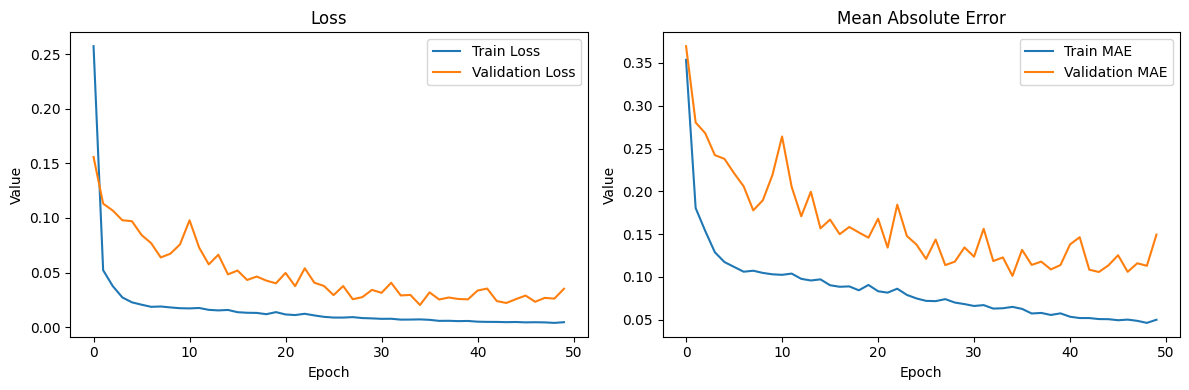

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Absolute Error (MAE): 0.6378370876981447
Root Mean Squared Error (RMSE): 0.6491030272679865


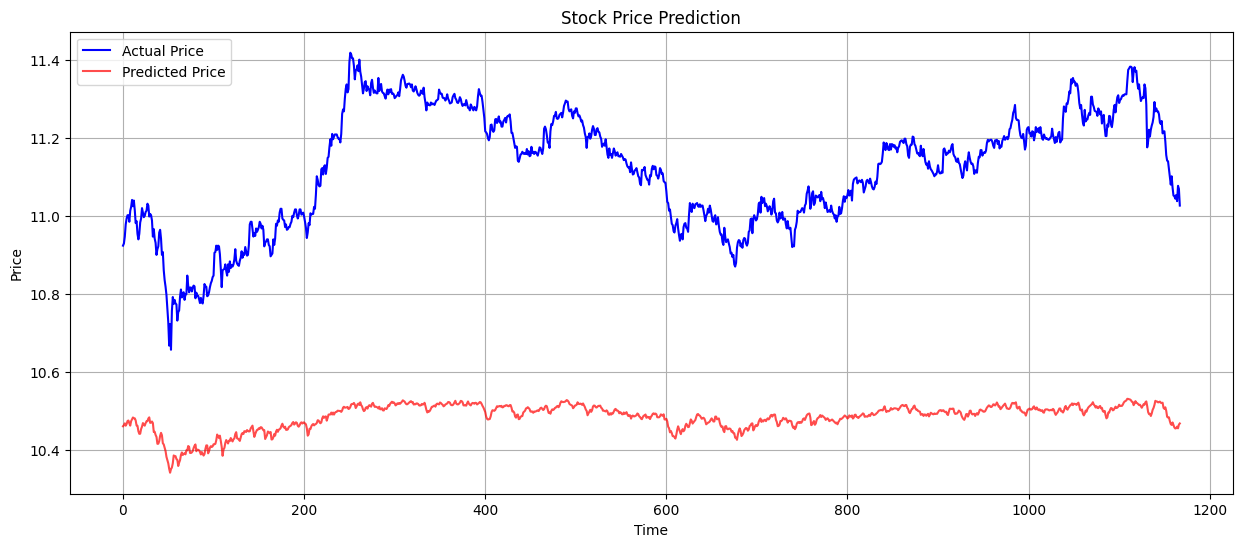

In [ ]:
predictplot(model, x_test, y_test, y_scaler)

###2

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=4, dropout_rate=0.2, lr=0.001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#model.save_weights(path+ 'f_int1')
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 20s - 362ms/step - loss: 0.5668 - mae: 0.4917 - val_loss: 0.1123 - val_mae: 0.3079
Epoch 2/100
55/55 - 10s - 178ms/step - loss: 0.0622 - mae: 0.1997 - val_loss: 0.0528 - val_mae: 0.1781
Epoch 3/100
55/55 - 9s - 155ms/step - loss: 0.0509 - mae: 0.1789 - val_loss: 0.0844 - val_mae: 0.2513
Epoch 4/100
55/55 - 6s - 112ms/step - loss: 0.0443 - mae: 0.1680 - val_loss: 0.0501 - val_mae: 0.1681
Epoch 5/100
55/55 - 4s - 80ms/step - loss: 0.0437 - mae: 0.1666 - val_loss: 0.0504 - val_mae: 0.1650
Epoch 6/100
55/55 - 5s - 87ms/step - loss: 0.0374 - mae: 0.1538 - val_loss: 0.0697 - val_mae: 0.2154
Epoch 7/100
55/55 - 8s - 142ms/step - loss: 0.0340 - mae: 0.1460 - val_loss: 0.0745 - val_mae: 0.2267
Epoch 8/100
55/55 - 8s - 145ms/step - loss: 0.0335 - mae: 0.1442 - val_loss: 0.0668 - val_mae: 0.2081
Epoch 9/100
55/55 - 7s - 132ms/step - loss: 0.0304 - mae: 0.1376 - val_loss: 0.0770 - val_mae: 0.2325
Epoch 10/100
55/55 - 8s - 140ms/step - loss: 0.0291 - mae: 0.1345 - val_loss: 0.06

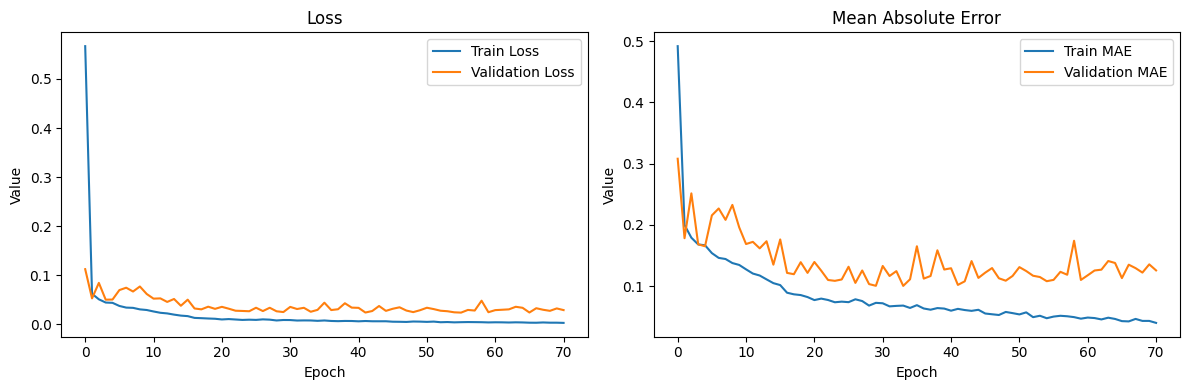

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Absolute Error (MAE): 0.6969171046377521
Root Mean Squared Error (RMSE): 0.7079621903240321


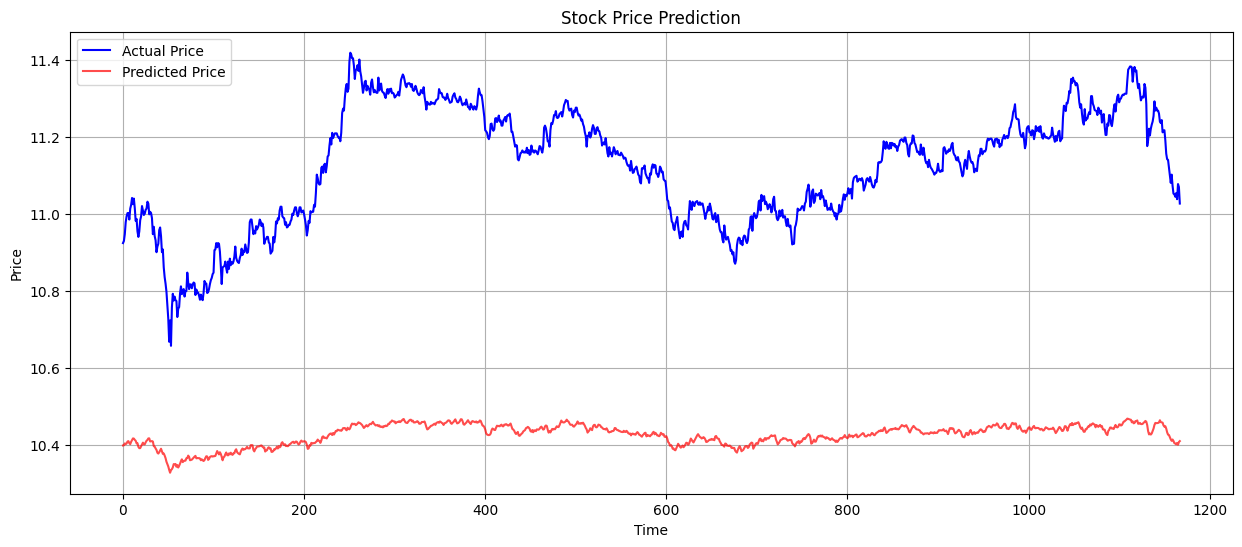

In [ ]:
predictplot(model, x_test, y_test, y_scaler)

###3

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.1, lr=0.001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=128
)
#model.save_weights(path+ 'f_int1')
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
28/28 - 15s - 530ms/step - loss: 0.5545 - mae: 0.5409 - val_loss: 0.2573 - val_mae: 0.4967
Epoch 2/100
28/28 - 6s - 204ms/step - loss: 0.0741 - mae: 0.2039 - val_loss: 0.0395 - val_mae: 0.1566
Epoch 3/100
28/28 - 3s - 102ms/step - loss: 0.0321 - mae: 0.1369 - val_loss: 0.0412 - val_mae: 0.1629
Epoch 4/100
28/28 - 5s - 188ms/step - loss: 0.0256 - mae: 0.1253 - val_loss: 0.0312 - val_mae: 0.1274
Epoch 5/100
28/28 - 6s - 216ms/step - loss: 0.0230 - mae: 0.1172 - val_loss: 0.0303 - val_mae: 0.1239
Epoch 6/100
28/28 - 4s - 148ms/step - loss: 0.0181 - mae: 0.1054 - val_loss: 0.0249 - val_mae: 0.1082
Epoch 7/100
28/28 - 6s - 205ms/step - loss: 0.0157 - mae: 0.0987 - val_loss: 0.0218 - val_mae: 0.1016
Epoch 8/100
28/28 - 5s - 186ms/step - loss: 0.0146 - mae: 0.0938 - val_loss: 0.0248 - val_mae: 0.1091
Epoch 9/100
28/28 - 4s - 149ms/step - loss: 0.0115 - mae: 0.0850 - val_loss: 0.0255 - val_mae: 0.1135
Epoch 10/100
28/28 - 3s - 105ms/step - loss: 0.0112 - mae: 0.0826 - val_loss: 0.0

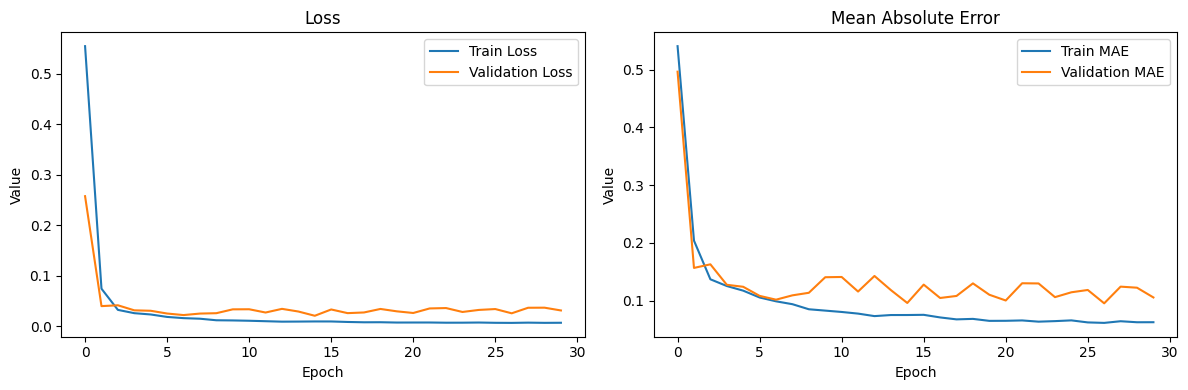

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Mean Absolute Error (MAE): 0.6797374775131748
Root Mean Squared Error (RMSE): 0.6865976363714344


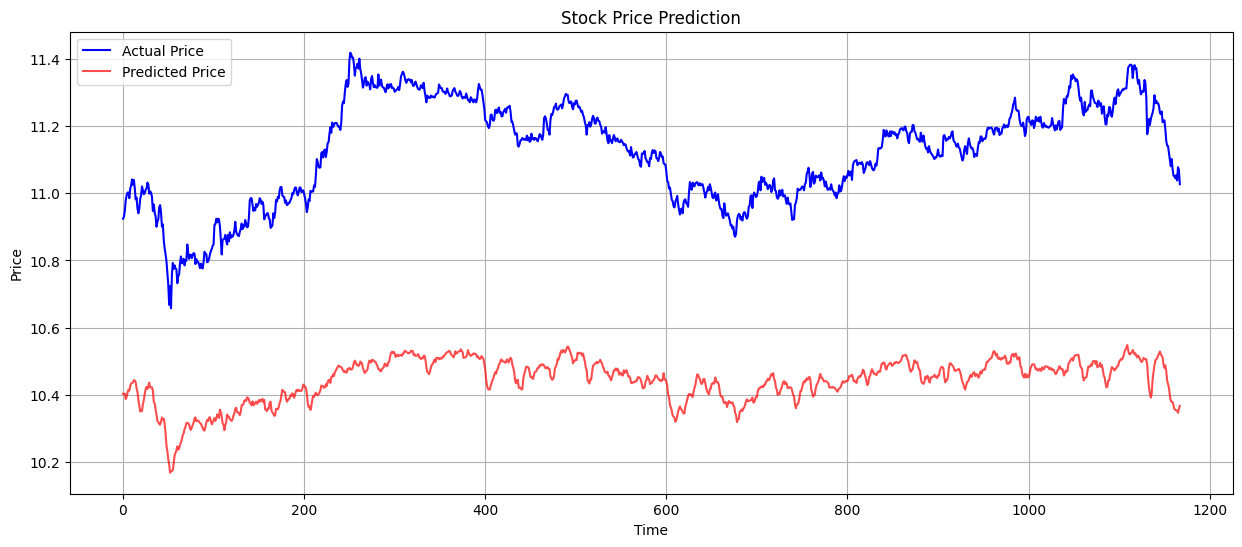

In [ ]:
predictplot(model, x_test, y_test, y_scaler)

###4

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.1, lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#model.save_weights(path+ 'f_int1')
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 17s - 301ms/step - loss: 0.1414 - mae: 0.2745 - val_loss: 0.0183 - val_mae: 0.0950
Epoch 2/100
55/55 - 3s - 55ms/step - loss: 0.0260 - mae: 0.1181 - val_loss: 0.0245 - val_mae: 0.1214
Epoch 3/100
55/55 - 5s - 95ms/step - loss: 0.0153 - mae: 0.0969 - val_loss: 0.0214 - val_mae: 0.1109
Epoch 4/100
55/55 - 4s - 77ms/step - loss: 0.0139 - mae: 0.0915 - val_loss: 0.0110 - val_mae: 0.0795
Epoch 5/100
55/55 - 4s - 81ms/step - loss: 0.0128 - mae: 0.0895 - val_loss: 0.0125 - val_mae: 0.0812
Epoch 6/100
55/55 - 4s - 69ms/step - loss: 0.0122 - mae: 0.0861 - val_loss: 0.0242 - val_mae: 0.1282
Epoch 7/100
55/55 - 3s - 57ms/step - loss: 0.0120 - mae: 0.0853 - val_loss: 0.0156 - val_mae: 0.0911
Epoch 8/100
55/55 - 4s - 76ms/step - loss: 0.0102 - mae: 0.0784 - val_loss: 0.0186 - val_mae: 0.1011
Epoch 9/100
55/55 - 4s - 81ms/step - loss: 0.0095 - mae: 0.0773 - val_loss: 0.0124 - val_mae: 0.0812
Epoch 10/100
55/55 - 3s - 56ms/step - loss: 0.0090 - mae: 0.0744 - val_loss: 0.0164 - val

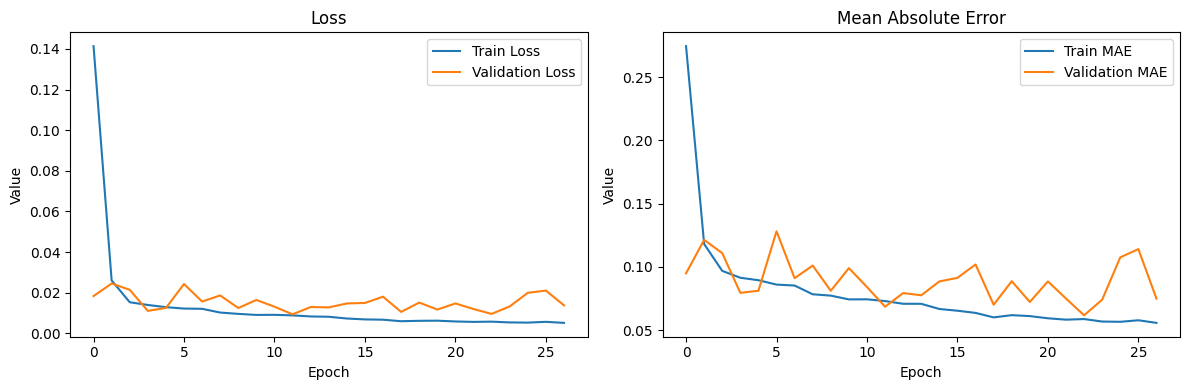

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Mean Absolute Error (MAE): 0.5352650099404531
Root Mean Squared Error (RMSE): 0.5406177534826169


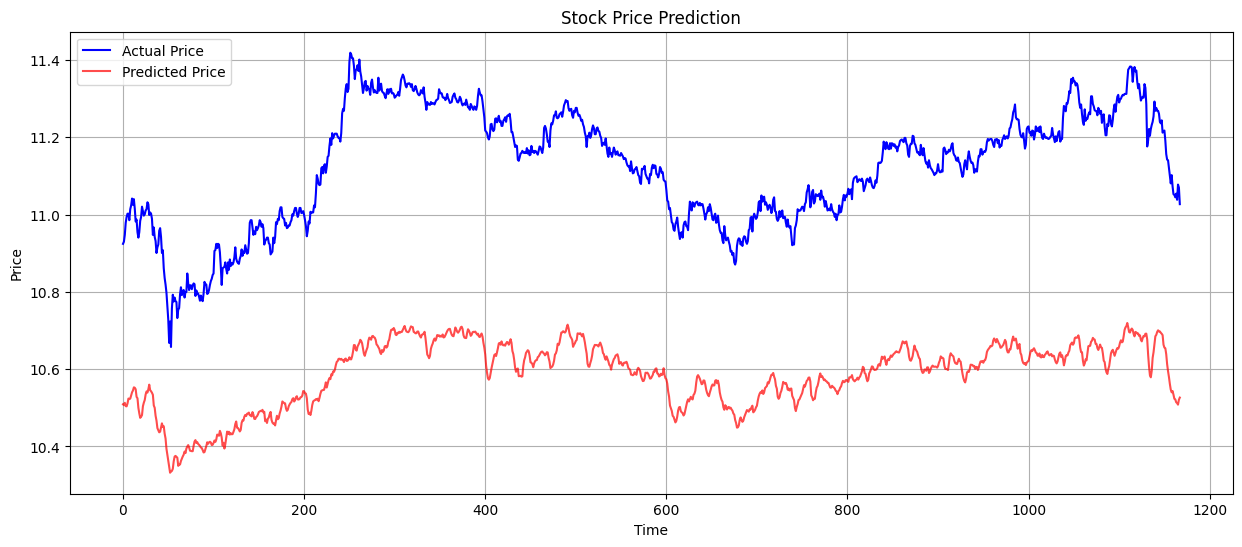

In [ ]:
predictplot(model, x_test, y_test, y_scaler)

###5☆☆☆

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 16s - 288ms/step - loss: 0.2477 - mae: 0.3829 - val_loss: 0.2188 - val_mae: 0.3191
Epoch 2/100
55/55 - 5s - 97ms/step - loss: 0.1206 - mae: 0.2751 - val_loss: 0.1390 - val_mae: 0.2496
Epoch 3/100
55/55 - 3s - 56ms/step - loss: 0.0910 - mae: 0.2380 - val_loss: 0.0746 - val_mae: 0.1854
Epoch 4/100
55/55 - 3s - 55ms/step - loss: 0.0753 - mae: 0.2175 - val_loss: 0.0739 - val_mae: 0.1791
Epoch 5/100
55/55 - 3s - 54ms/step - loss: 0.0617 - mae: 0.1979 - val_loss: 0.0676 - val_mae: 0.1706
Epoch 6/100
55/55 - 5s - 91ms/step - loss: 0.0527 - mae: 0.1821 - val_loss: 0.0651 - val_mae: 0.1648
Epoch 7/100
55/55 - 3s - 58ms/step - loss: 0.0451 - mae: 0.1691 - val_loss: 0.0754 - val_mae: 0.2026
Epoch 8/100
55/55 - 5s - 90ms/step - loss: 0.0412 - mae: 0.1602 - val_loss: 0.0533 - val_mae: 0.1573
Epoch 9/100
55/55 - 7s - 134ms/step - loss: 0.0365 - mae: 0.1512 - val_loss: 0.0524 - val_mae: 0.1475
Epoch 10/100
55/55 - 3s - 57ms/step - loss: 0.0319 - mae: 0.1401 - val_loss: 0.0353 - va

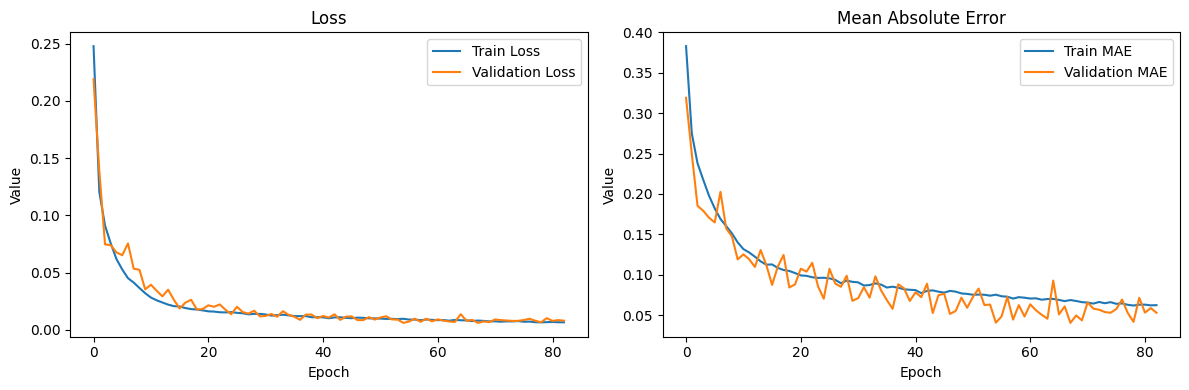

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Absolute Error (MAE): 0.2149687975220145
Root Mean Squared Error (RMSE): 0.21749129553154195


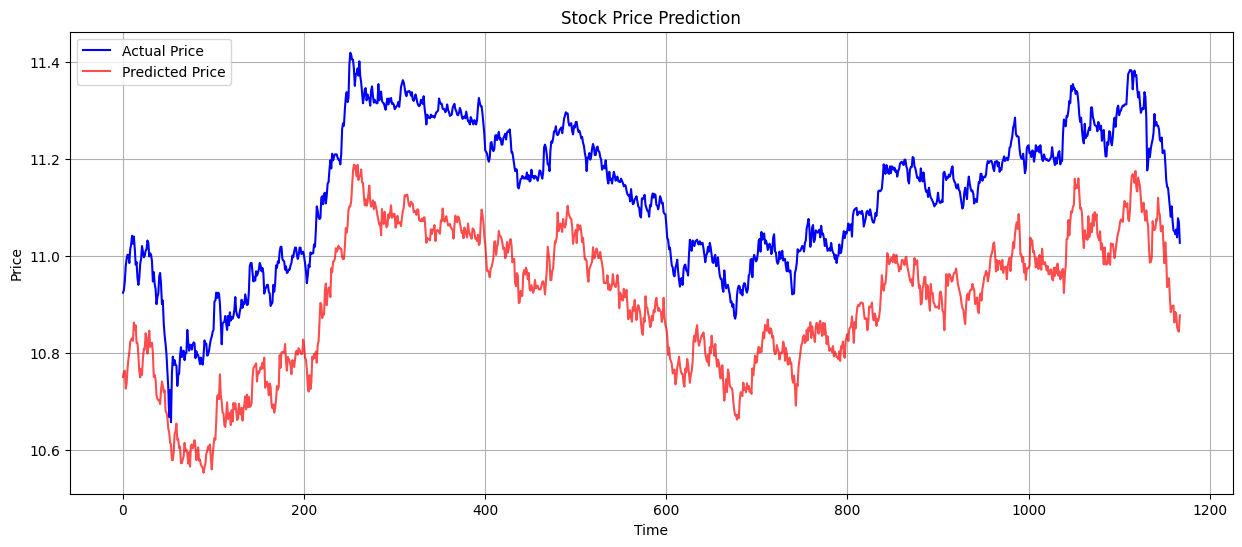

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
model.save_weights(path+ 'ver0_int5.weights.h5')

###5-1☆☆☆☆☆

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 13s - 245ms/step - loss: 0.2761 - mae: 0.4082 - val_loss: 0.0334 - val_mae: 0.1424
Epoch 2/100
55/55 - 6s - 112ms/step - loss: 0.1174 - mae: 0.2716 - val_loss: 0.0365 - val_mae: 0.1541
Epoch 3/100
55/55 - 4s - 67ms/step - loss: 0.0788 - mae: 0.2222 - val_loss: 0.0133 - val_mae: 0.0772
Epoch 4/100
55/55 - 3s - 57ms/step - loss: 0.0622 - mae: 0.1963 - val_loss: 0.0139 - val_mae: 0.0869
Epoch 5/100
55/55 - 4s - 71ms/step - loss: 0.0491 - mae: 0.1771 - val_loss: 0.0077 - val_mae: 0.0505
Epoch 6/100
55/55 - 5s - 88ms/step - loss: 0.0447 - mae: 0.1671 - val_loss: 0.0063 - val_mae: 0.0409
Epoch 7/100
55/55 - 3s - 56ms/step - loss: 0.0379 - mae: 0.1537 - val_loss: 0.0061 - val_mae: 0.0393
Epoch 8/100
55/55 - 3s - 56ms/step - loss: 0.0319 - mae: 0.1415 - val_loss: 0.0053 - val_mae: 0.0343
Epoch 9/100
55/55 - 4s - 78ms/step - loss: 0.0295 - mae: 0.1362 - val_loss: 0.0086 - val_mae: 0.0636
Epoch 10/100
55/55 - 4s - 77ms/step - loss: 0.0265 - mae: 0.1294 - val_loss: 0.0062 - va

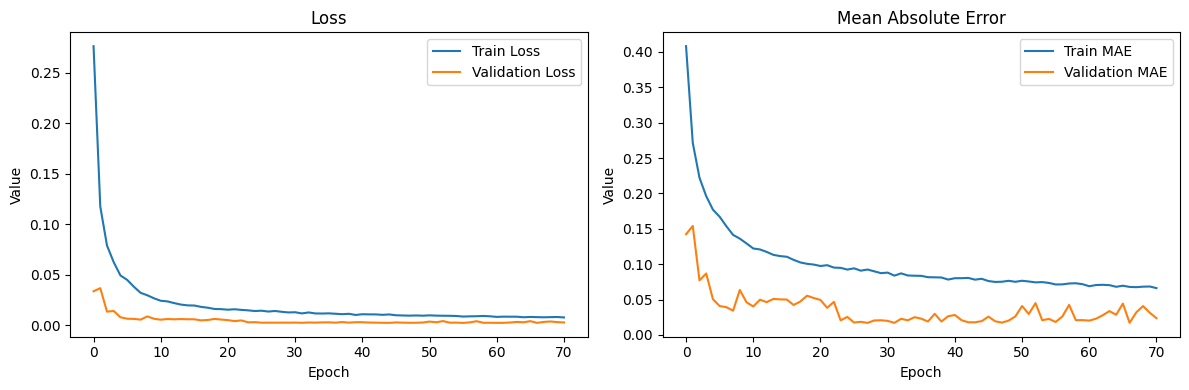

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Absolute Error (MAE): 0.06200233660140731
Root Mean Squared Error (RMSE): 0.07601096528014631


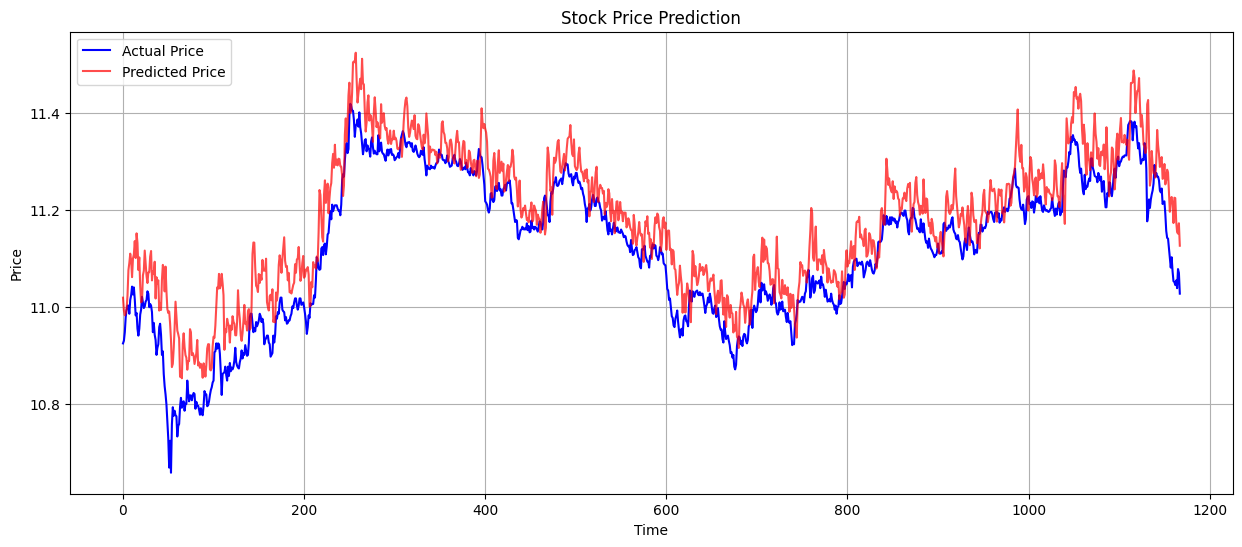

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
#model.save_weights(path+ 'ver0_int5.weights.h5')
#model.save(path+'ver0_int5Model.h5')
#model.save(path+'ver0_int5Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 1 Prediction: 1.3169441223144531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Day 2 Prediction: 1.194408893585205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 3 Prediction: 0.9291949272155762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 4 Prediction: 0.7683591842651367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Day 5 Prediction: 0.6787581443786621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Day 6 Prediction: 0.5906239151954651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Day 7 Prediction: 0.5681673288345337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Day 8 Prediction: 0.5496032238006592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Day 9 Prediction: 0.5382404327392578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 10 Prediction: 0.5312572121620178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Day 11 Prediction: 0.5267463326454163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Day 12 Prediction: 0.5246915221214294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Day 13 Prediction: 0.523311972618103
1/1 ━━━━━━━━━━━━━━━━━━━

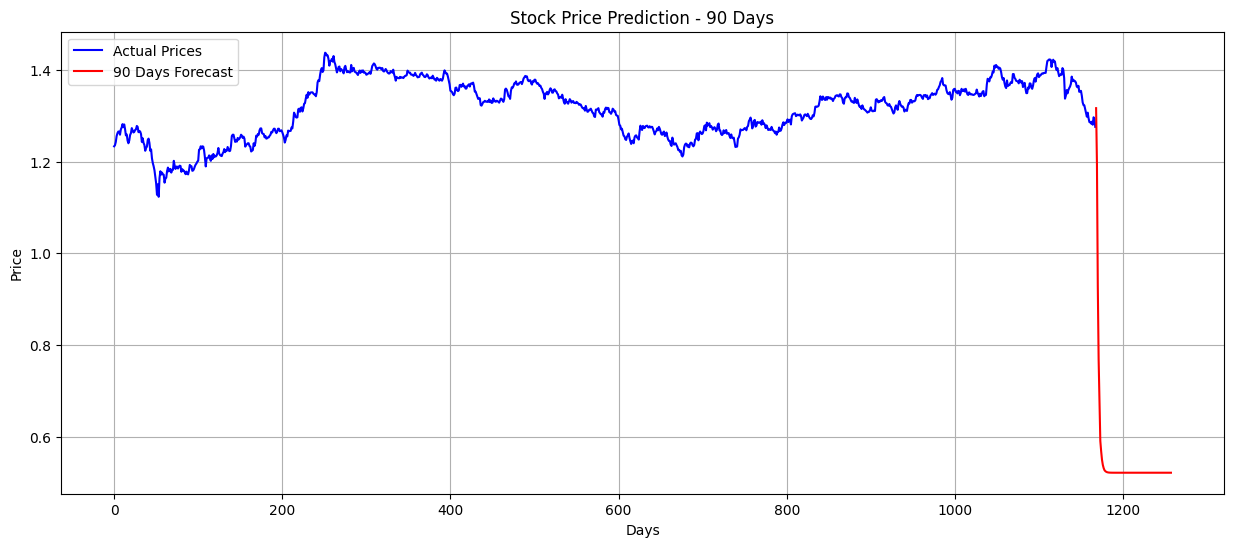

In [ ]:
def predict_future(model, x_test, steps=90):
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 입력 시퀀스를 선택

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        print(f"Day {i+1} Prediction: {prediction}")  # 각 예측값 출력

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)

# 90일 예측 수행
future_90_days = predict_future(model, x_test, steps=90)

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(np.arange(len(y_test), len(y_test) + 90), future_90_days, label='90 Days Forecast', color='red')

plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 1 Prediction: 1.3169441223144531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Day 2 Prediction: 1.194408893585205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Day 3 Prediction: 0.9291949272155762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Day 4 Prediction: 0.7683591842651367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 5 Prediction: 0.6787581443786621


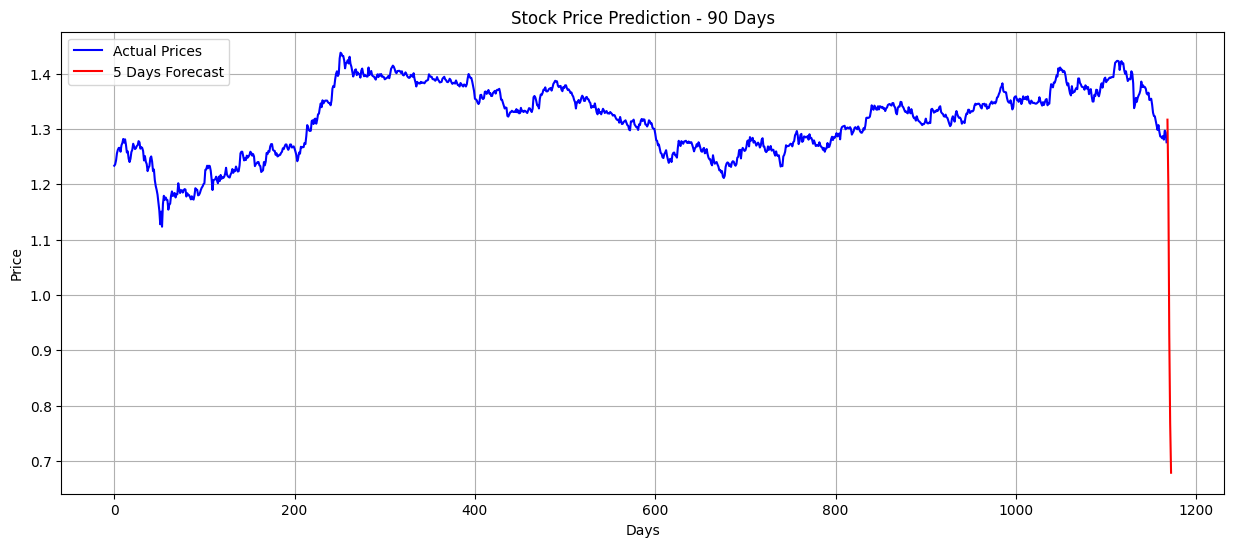

In [ ]:
# 90일 예측 수행
future_90_days = predict_future(model, x_test, steps=5)

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(np.arange(len(y_test), len(y_test) + 5), future_90_days, label='5 Days Forecast', color='red')

plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()

###5-1불러오기

In [20]:
model5_2 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Time Series Project/Stock Price/Model/Transformer_model_path/ver0_int5Model.keras',
    custom_objects={'PositionalEncoding': PositionalEncoding}
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 52 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
model5_2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 5, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding       │ (None, 5, 13)          │              0 │ input_layer_10[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_31   │ (None, 5, 13)          │         28,173 │ positional_encoding[0… │
│ (MultiHeadAttention)      │                        │                │ positional_encoding[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_104 (Dropout)     │ (None, 5, 13)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_62 (Add)              │ (None, 5, 13)          │              0 │ positional_encoding[0… │
│                           │                        │                │ dropout_104[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_62    │ (None, 5, 13)          │             26 │ add_62[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_72 (Dense)          │ (None, 5, 256)         │          3,584 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_73 (Dense)          │ (None, 5, 13)          │          3,341 │ dense_72[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_105 (Dropout)     │ (None, 5, 13)          │              0 │ dense_73[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_63 (Add)              │ (None, 5, 13)          │              0 │ layer_normalization_6… │
│                           │                        │                │ dropout_105[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_63    │ (None, 5, 13)          │             26 │ add_63[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_32   │ (None, 5, 13)          │         28,173 │ layer_normalization_6… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_107 (Dropout)     │ (None, 5, 13)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_64 (Add)              │ (None, 5, 13)          │              0 │ layer_normalization_6… │
│                           │                        │                │ dropout_107[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_64    │ (None, 5, 13)          │             26 │ add_64[0][0]           │
│ (LayerNormalization) 

 Total params: 210,930 (823.95 KB)

 Trainable params: 105,464 (411.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,466 (411.98 KB)

In [30]:
evaluation = model5_2.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {evaluation[0]}, Test MAE: {evaluation[1]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014 - mae: 0.0307
Test Loss: 0.0009857375407591462, Test MAE: 0.025610165670514107


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Mean Absolute Error (MAE): 4279.955947666944
Root Mean Squared Error (RMSE): 5196.493785768822


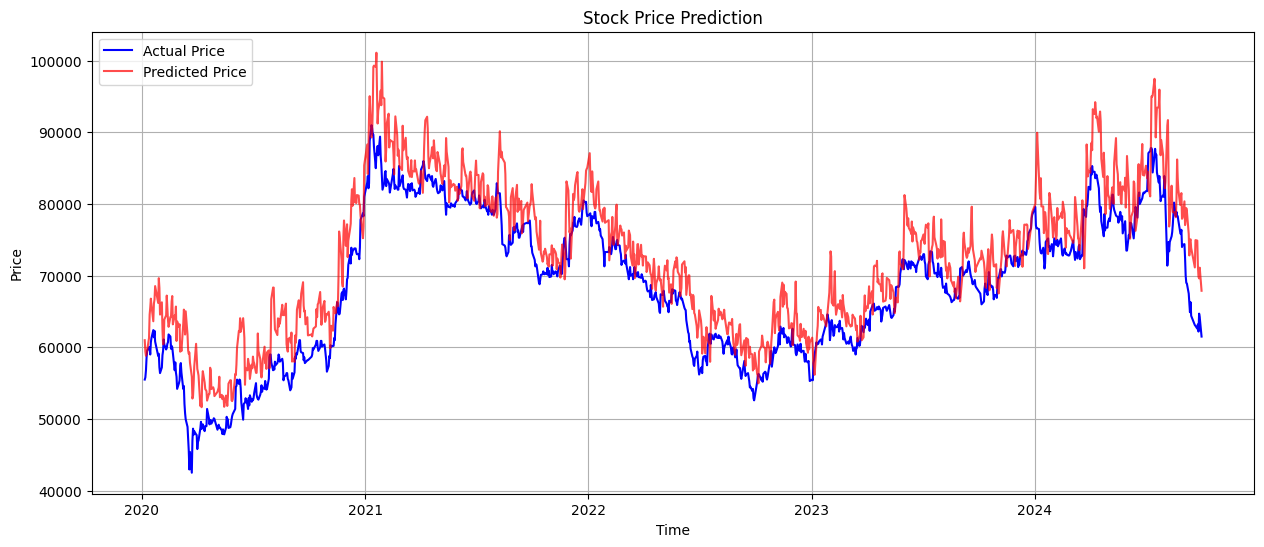

In [78]:
predictplot(model5_2, x_test, y_test, y_scaler_int0, dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Day 1 Prediction: [[67893.8]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Day 2 Prediction: [[72782.125]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Day 3 Prediction: [[73078.28]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Day 4 Prediction: [[73010.29]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 5 Prediction: [[71984.63]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Day 6 Prediction: [[72120.75]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Day 7 Prediction: [[72178.21]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Day 8 Prediction: [[72138.84]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Day 9 Prediction: [[72125.37]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Day 10 Prediction: [[72129.9]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Day 11 Prediction: [[72130.45]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 12 Prediction: [[72129.29]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Day 13 Prediction: [[72129.14]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Day 14 Prediction: [[72129.29]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

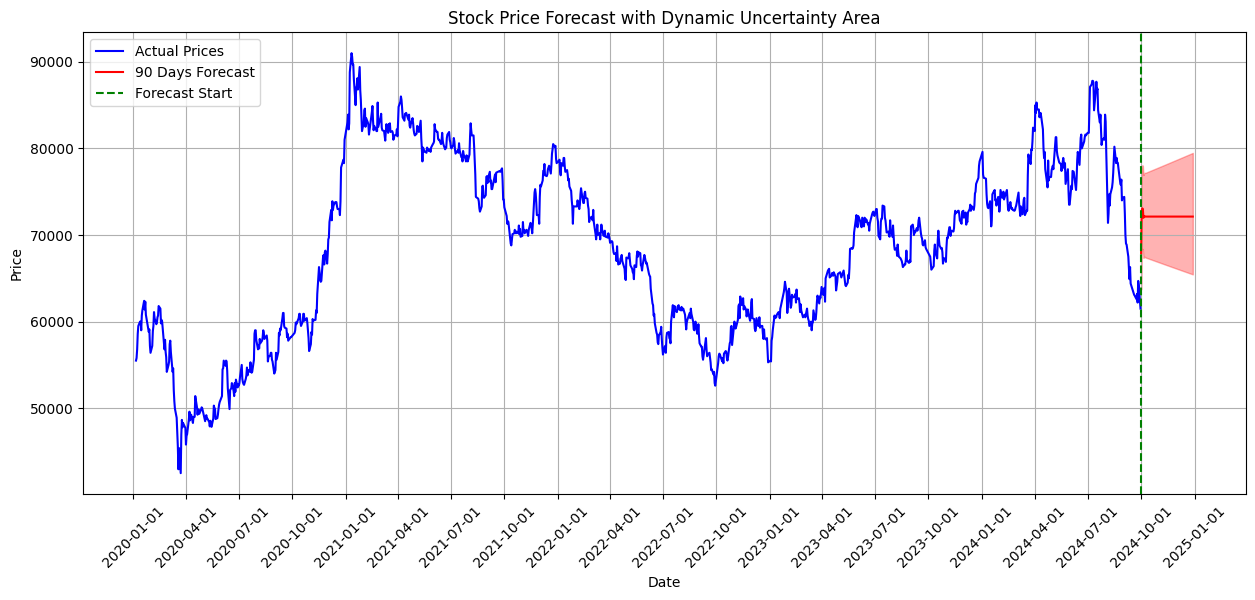

In [87]:
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model5_2, x_test, scaler=y_scaler_int0, steps=90, feature_generator=feature_generator)


y_test_rever = y_scaler_int0.inverse_transform(y_test[:len(test_dates)]) # 스케일 복원 후 1D 배열로 변환
y_test_rever = np.exp(y_test_rever)  # 로그 복원

future_90_days_rever = y_scaler_int0.inverse_transform(future_90_days.reshape(-1, 1))  # 2D 배열로 변환하여 스케일 복원
future_90_days_rever = np.exp(future_90_days_rever)  # 로그 복원

upper_90_days_rever = y_scaler_int0.inverse_transform(upper_90_days.reshape(-1, 1))  # 2D 배열로 변환하여 스케일 복원
upper_90_days_rever = np.exp(upper_90_days_rever)  # 로그 복원

lower_90_days_rever = y_scaler_int0.inverse_transform(lower_90_days.reshape(-1, 1))  # 2D 배열로 변환하여 스케일 복원
lower_90_days_rever = np.exp(lower_90_days_rever)



plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_rever, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days_rever, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days_rever.ravel(), lower_90_days_rever.ravel(), color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

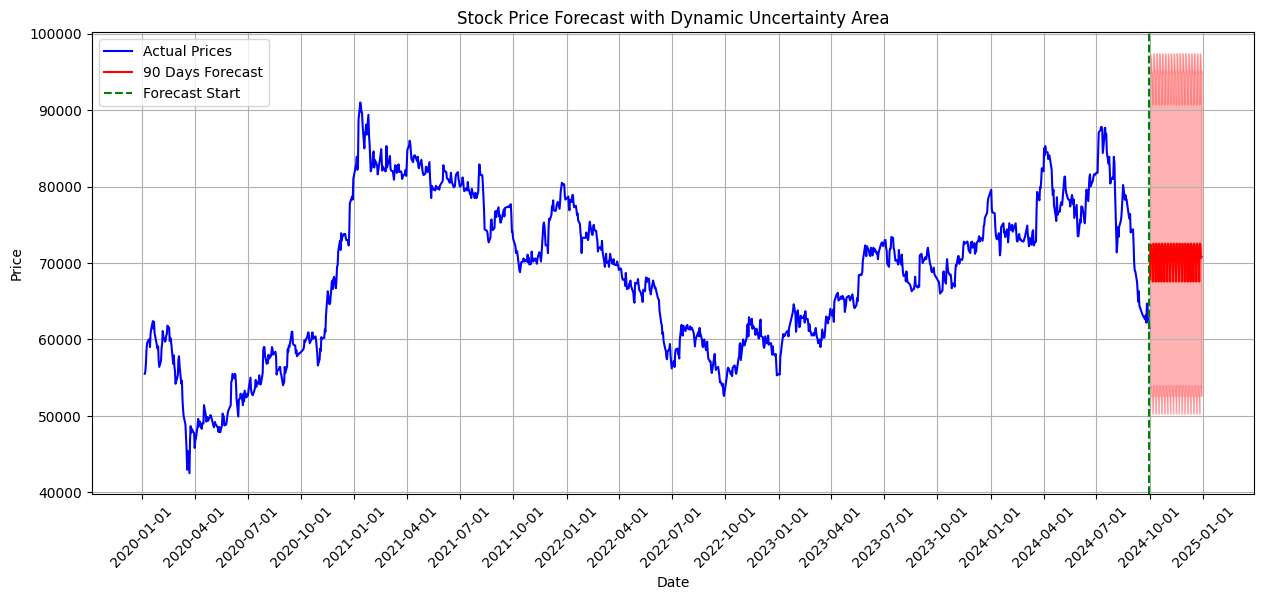

In [90]:
future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model5_2, x_test, steps=90, feature_generator=feature_generator)

y_test_rever = y_scaler_int0.inverse_transform(y_test[:len(test_dates)]) # 스케일 복원 후 1D 배열로 변환
y_test_rever = np.exp(y_test_rever)  # 로그 복원

future_90_days_rever = y_scaler_int0.inverse_transform(future_90_days.reshape(-1, 1))  # 2D 배열로 변환하여 스케일 복원
future_90_days_rever = np.exp(future_90_days_rever)  # 로그 복원

upper_90_days_rever = y_scaler_int0.inverse_transform(upper_90_days.reshape(-1, 1))  # 2D 배열로 변환하여 스케일 복원
upper_90_days_rever = np.exp(upper_90_days_rever)  # 로그 복원

lower_90_days_rever = y_scaler_int0.inverse_transform(lower_90_days.reshape(-1, 1))  # 2D 배열로 변환하여 스케일 복원
lower_90_days_rever = np.exp(lower_90_days_rever)


plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_rever, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days_rever, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days_rever.ravel(), lower_90_days_rever.ravel(), color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [34]:
#=========================================================================================
history5_2_1, model5_2_1 = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=5, batch_size=64
)

Epoch 1/5
55/55 - 21s - 388ms/step - loss: 0.1730 - mae: 0.3122 - val_loss: 0.0222 - val_mae: 0.0604
Epoch 2/5
55/55 - 0s - 6ms/step - loss: 0.0509 - mae: 0.1796 - val_loss: 0.0274 - val_mae: 0.0975
Epoch 3/5
55/55 - 1s - 10ms/step - loss: 0.0410 - mae: 0.1600 - val_loss: 0.0411 - val_mae: 0.1420
Epoch 4/5
55/55 - 0s - 6ms/step - loss: 0.0354 - mae: 0.1489 - val_loss: 0.0519 - val_mae: 0.1638
Epoch 5/5
55/55 - 0s - 6ms/step - loss: 0.0299 - mae: 0.1367 - val_loss: 0.0428 - val_mae: 0.1371


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error (MAE): 1506.0291001340902
Root Mean Squared Error (RMSE): 1860.1001030996395


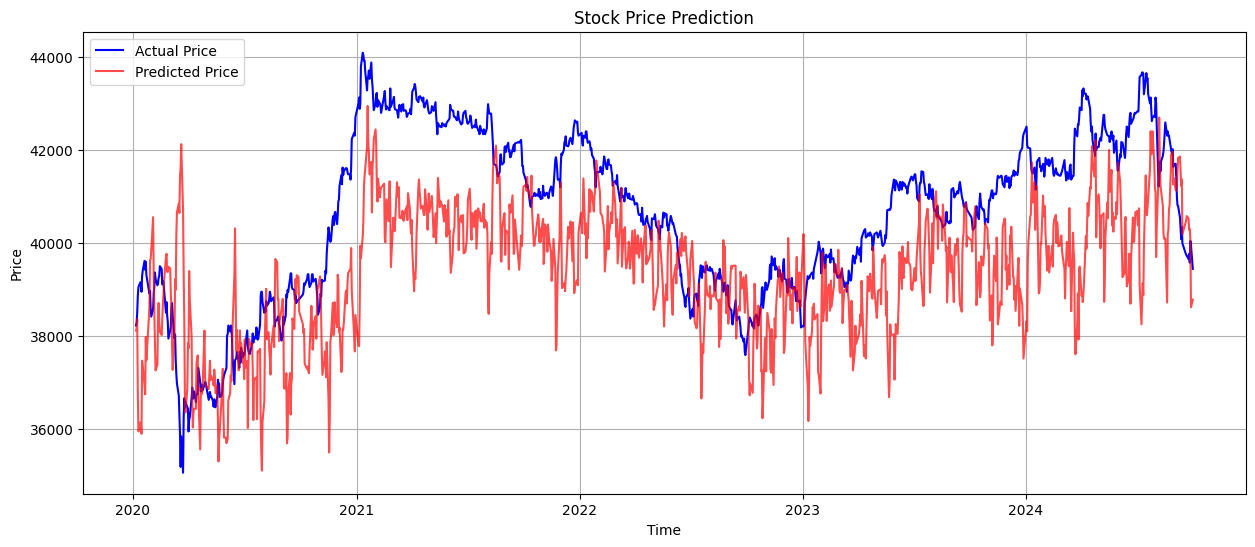

In [35]:
predictplot(model5_2_1, x_test, y_test, y_scaler, dates)

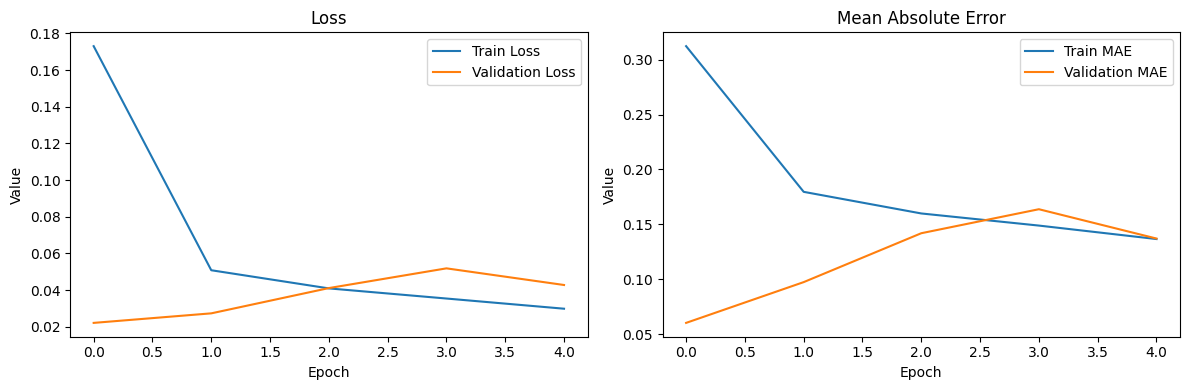

In [36]:
lossplot(history5_2_1)

###6

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.00005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 14s - 255ms/step - loss: 0.7877 - mae: 0.6973 - val_loss: 0.0286 - val_mae: 0.1160
Epoch 2/100
55/55 - 5s - 85ms/step - loss: 0.2766 - mae: 0.4157 - val_loss: 0.0341 - val_mae: 0.1356
Epoch 3/100
55/55 - 7s - 119ms/step - loss: 0.1523 - mae: 0.3101 - val_loss: 0.0255 - val_mae: 0.1139
Epoch 4/100
55/55 - 3s - 57ms/step - loss: 0.0953 - mae: 0.2472 - val_loss: 0.0192 - val_mae: 0.0902
Epoch 5/100
55/55 - 3s - 56ms/step - loss: 0.0781 - mae: 0.2214 - val_loss: 0.0167 - val_mae: 0.0812
Epoch 6/100
55/55 - 7s - 131ms/step - loss: 0.0645 - mae: 0.2017 - val_loss: 0.0166 - val_mae: 0.0839
Epoch 7/100
55/55 - 8s - 147ms/step - loss: 0.0550 - mae: 0.1855 - val_loss: 0.0126 - val_mae: 0.0637
Epoch 8/100
55/55 - 8s - 139ms/step - loss: 0.0515 - mae: 0.1789 - val_loss: 0.0163 - val_mae: 0.0879
Epoch 9/100
55/55 - 8s - 140ms/step - loss: 0.0477 - mae: 0.1738 - val_loss: 0.0128 - val_mae: 0.0690
Epoch 10/100
55/55 - 7s - 135ms/step - loss: 0.0451 - mae: 0.1671 - val_loss: 0.0208

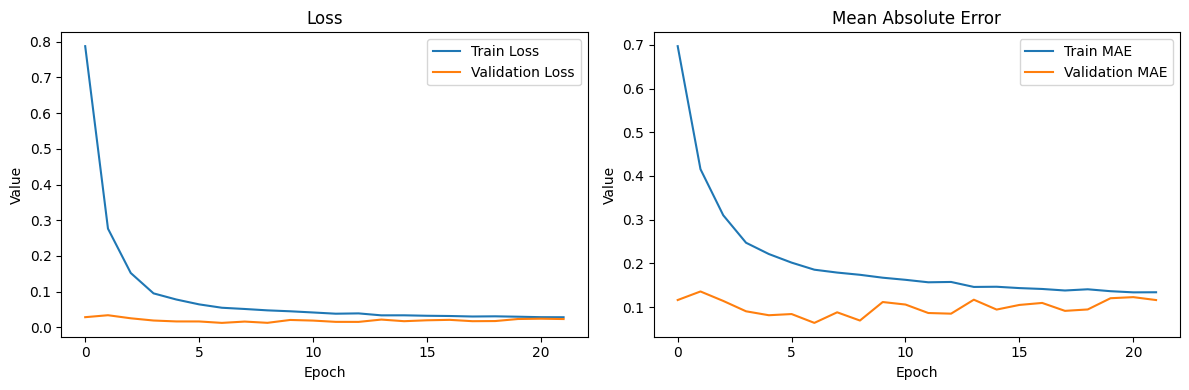

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Absolute Error (MAE): 0.31764436599046075
Root Mean Squared Error (RMSE): 0.3388851729814923


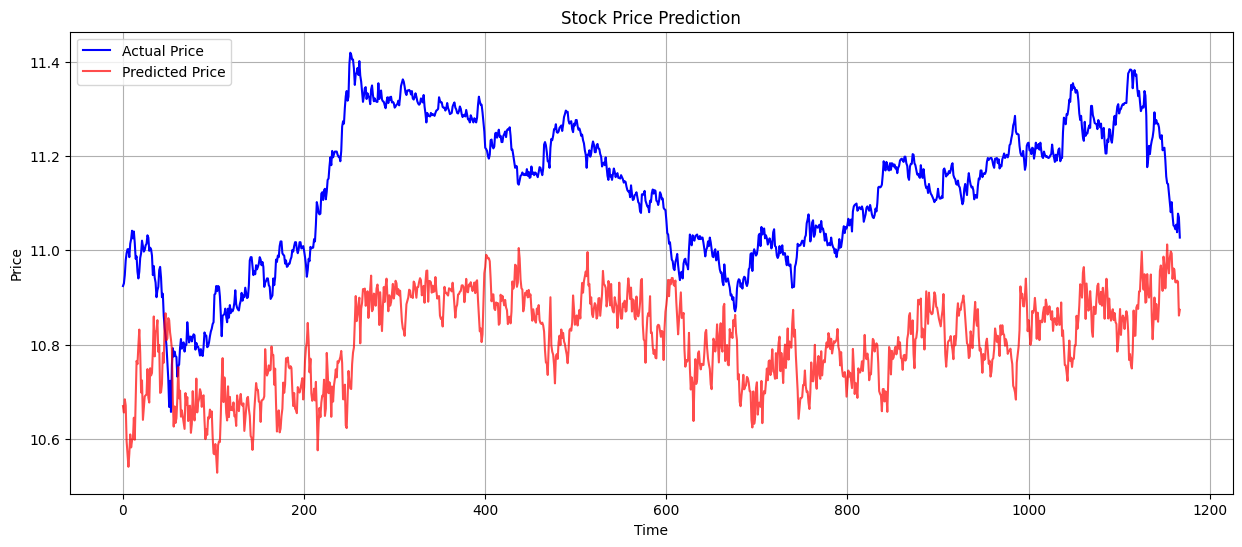

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
model.save_weights(path+ 'ver0_int6.weights.h5')

###7 (seq_len=90) ★★★

In [102]:
seq_length = 90  # 예: 30일간의 데이터를 기반으로 예측
x_train, y_train = create_sequences(x_train_int0, y_train_int0, seq_length)
x_val, y_val = create_sequences(x_val_int0, y_val_int0, seq_length)
x_test, y_test = create_sequences(x_test_int0, y_test_int0, seq_length)

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
54/54 - 57s - 1s/step - loss: 0.3041 - mae: 0.4158 - val_loss: 0.9484 - val_mae: 0.6626
Epoch 2/100
54/54 - 44s - 820ms/step - loss: 0.0617 - mae: 0.1932 - val_loss: 0.6914 - val_mae: 0.5582
Epoch 3/100
54/54 - 85s - 2s/step - loss: 0.0308 - mae: 0.1367 - val_loss: 0.5370 - val_mae: 0.4944
Epoch 4/100
54/54 - 78s - 1s/step - loss: 0.0245 - mae: 0.1229 - val_loss: 0.3803 - val_mae: 0.4141
Epoch 5/100
54/54 - 81s - 1s/step - loss: 0.0209 - mae: 0.1124 - val_loss: 0.2859 - val_mae: 0.3606
Epoch 6/100
54/54 - 83s - 2s/step - loss: 0.0199 - mae: 0.1107 - val_loss: 0.2149 - val_mae: 0.3080
Epoch 7/100
54/54 - 82s - 2s/step - loss: 0.0176 - mae: 0.1043 - val_loss: 0.1811 - val_mae: 0.2854
Epoch 8/100
54/54 - 82s - 2s/step - loss: 0.0169 - mae: 0.1025 - val_loss: 0.1456 - val_mae: 0.2524
Epoch 9/100
54/54 - 80s - 1s/step - loss: 0.0164 - mae: 0.1015 - val_loss: 0.1603 - val_mae: 0.2703
Epoch 10/100
54/54 - 81s - 2s/step - loss: 0.0153 - mae: 0.0967 - val_loss: 0.1280 - val_mae: 0.2

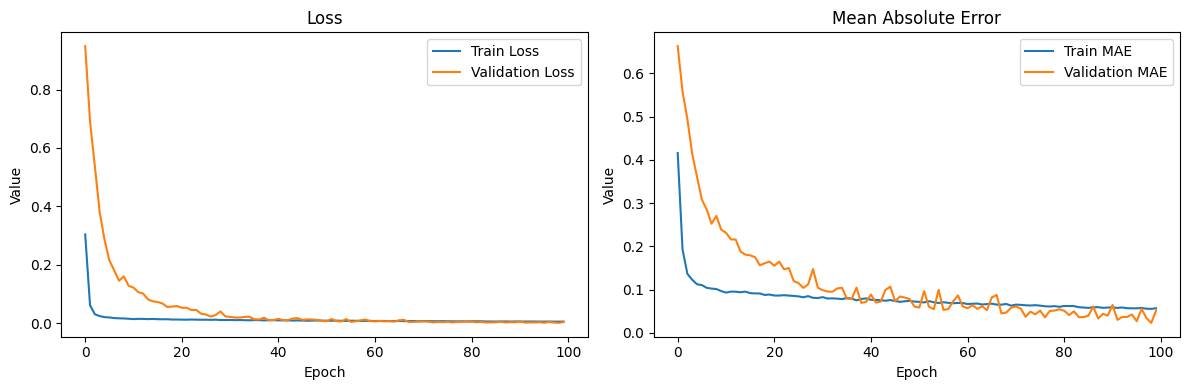

In [ ]:
lossplot(history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step
Mean Absolute Error (MAE): 0.07266296974053363
Root Mean Squared Error (RMSE): 0.08308287043286293


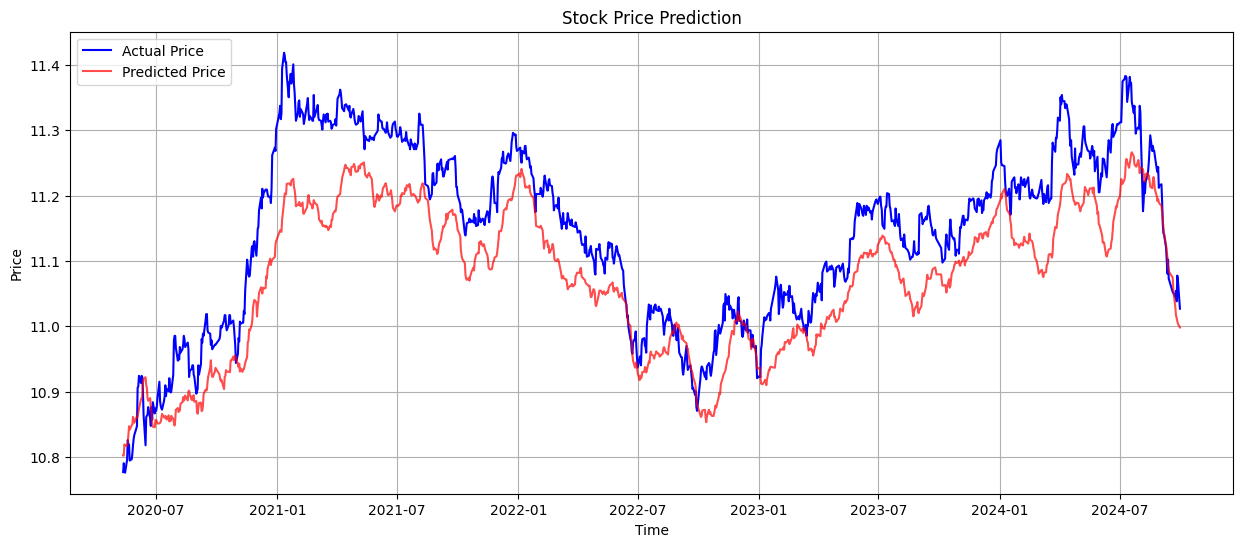

In [ ]:
predictplot(model, x_test, y_test, y_scaler, dates)
# model.save_weights(path+ 'ver0_int7.weights.h5')
# model.save(path+'ver0_int7Model.h5')
# model.save(path+'ver0_int7Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Day 1 Prediction: 1.2642558813095093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Day 2 Prediction: 1.2632803916931152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Day 3 Prediction: 1.2594237327575684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 4 Prediction: 1.2549492120742798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Day 5 Prediction: 1.2572345733642578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 6 Prediction: 1.2586321830749512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 7 Prediction: 1.2559202909469604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Day 8 Prediction: 1.252053141593933
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Day 9 Prediction: 1.2522330284118652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Day 10 Prediction: 1.2496750354766846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Day 11 Prediction: 1.251637578010559
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Day 12 Prediction: 1.2493774890899658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Day 13 Prediction: 1.2457951307296753
1/1 ━━━━━━━━━━━━━━━━━━━

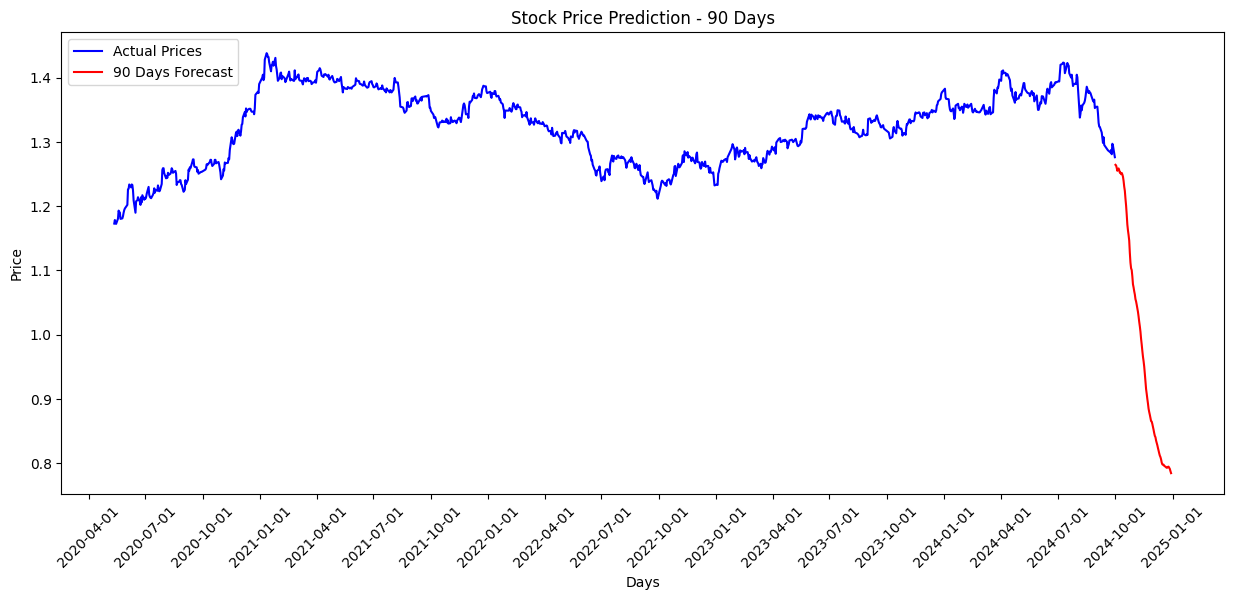

In [ ]:
def predict_future(model, x_test, steps=90):
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 입력 시퀀스를 선택

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        print(f"Day {i+1} Prediction: {prediction}")  # 각 예측값 출력

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)

test_dates = ddf['Date'][4782:]
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)
future_90_days = predict_future(model, x_test, steps=90)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 포맷 지정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 주요 틱을 월 단위로 표시
plt.xticks(rotation=45)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

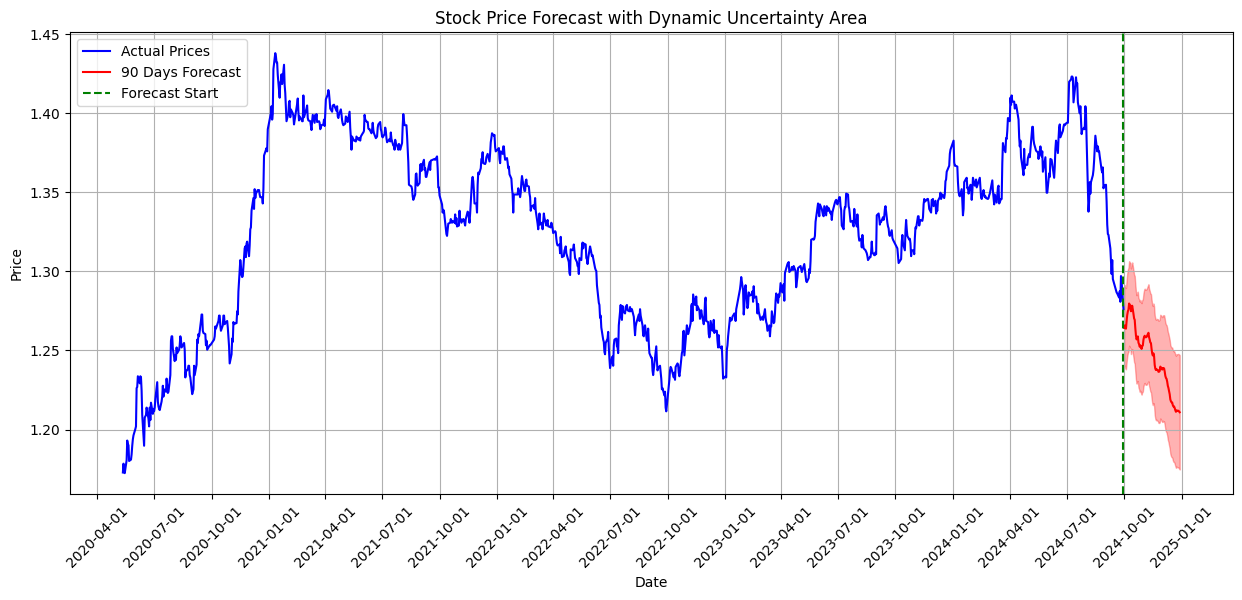

In [ ]:
def predict_future_dynamic(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 동적으로 불확실성 계산 (처음에는 좁고 끝으로 갈수록 퍼지는 영역)
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 비율 증가 (처음에는 2%, 끝에는 약 12%까지)

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), np.array(upper_bounds), np.array(lower_bounds)

def simple_feature_generator(current_input, prediction):
    """
    피처 값을 단순히 이전 값으로 유지하는 예제 함수
    """
    last_features = current_input[0, -1, :-1]  # 마지막 피처 값 가져오기
    return last_features

feature_generator = simple_feature_generator
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

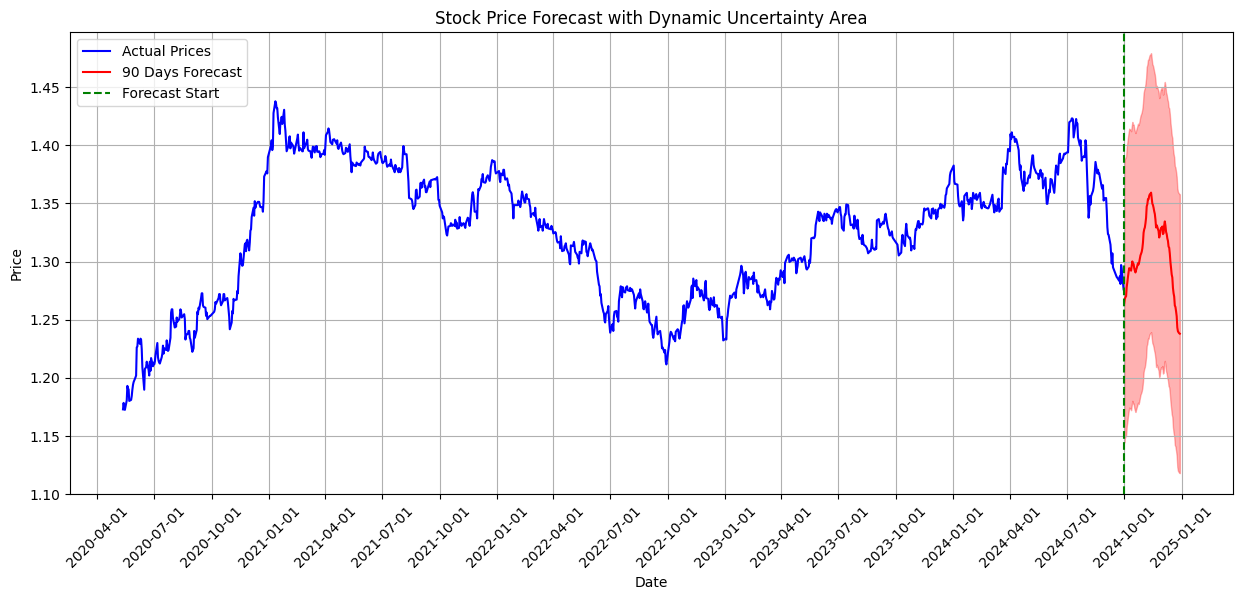

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound



future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()


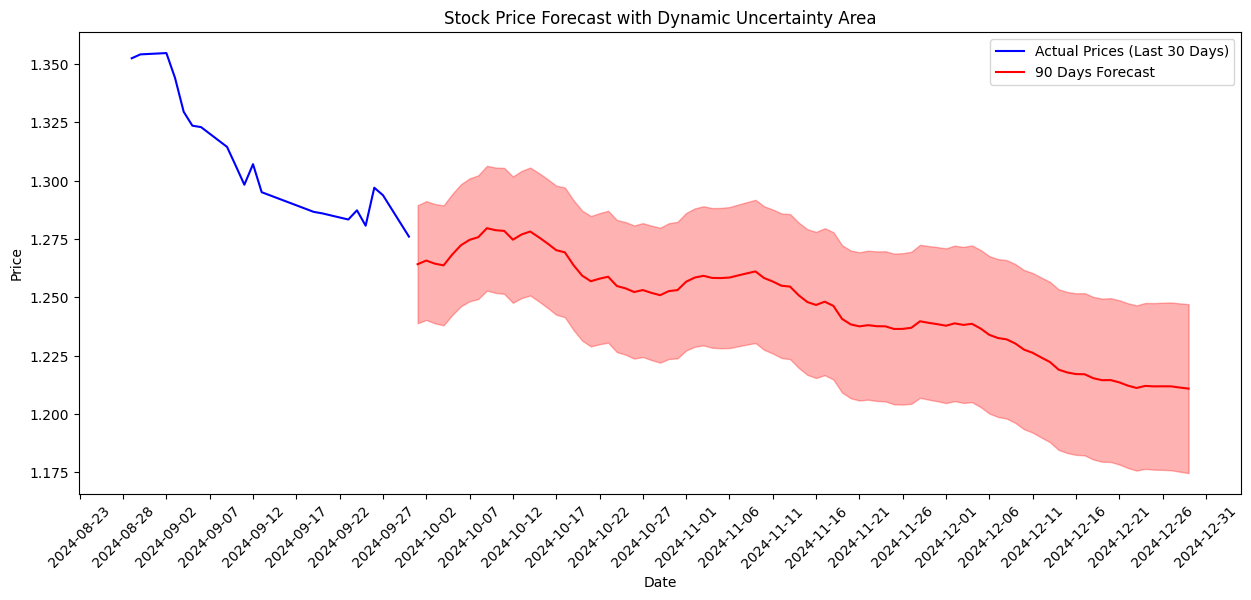

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
#plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

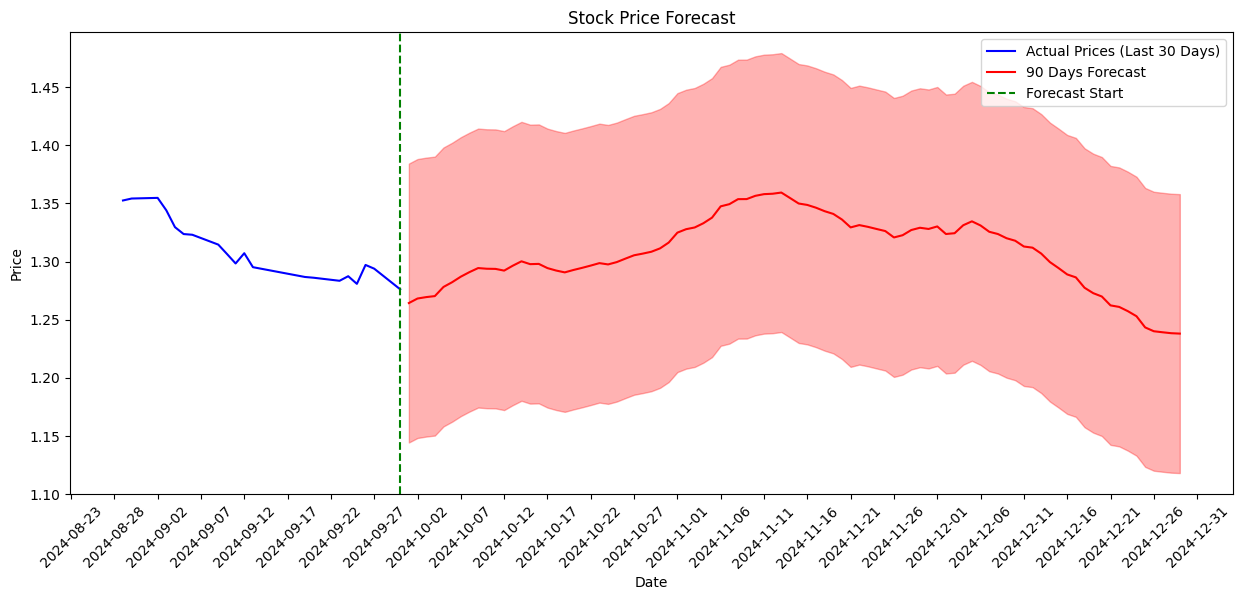

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


###7 (seq_len=90) 불러오기

In [91]:
model7_2 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Time Series Project/Stock Price/Model/Transformer_model_path/ver0_int7Model.keras',
    custom_objects={'PositionalEncoding': PositionalEncoding}
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 52 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [122]:
train_loss, train_mae = model7_2.evaluate(x_train, y_train, verbose=0)
val_loss, val_mae = model7_2.evaluate(x_val, y_val, verbose=0)

print(f"Train Loss (MSE): {train_loss}")
print(f"Validation Loss (MSE): {val_loss}")


Train Loss (MSE): 0.0005107400356791914
Validation Loss (MSE): 0.0011991162318736315


In [92]:
model7_2.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 90, 13)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_13    │ (None, 90, 13)         │              0 │ input_layer_11[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_34   │ (None, 90, 13)         │         28,173 │ positional_encoding_1… │
│ (MultiHeadAttention)      │                        │                │ positional_encoding_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_114 (Dropout)     │ (None, 90, 13)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_68 (Add)              │ (None, 90, 13)         │              0 │ positional_encoding_1… │
│                           │                        │                │ dropout_114[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_68    │ (None, 90, 13)         │             26 │ add_68[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_79 (Dense)          │ (None, 90, 256)        │          3,584 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_80 (Dense)          │ (None, 90, 13)         │          3,341 │ dense_79[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_115 (Dropout)     │ (None, 90, 13)         │              0 │ dense_80[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_69 (Add)              │ (None, 90, 13)         │              0 │ layer_normalization_6… │
│                           │                        │                │ dropout_115[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_69    │ (None, 90, 13)         │             26 │ add_69[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_35   │ (None, 90, 13)         │         28,173 │ layer_normalization_6… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_117 (Dropout)     │ (None, 90, 13)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_70 (Add)              │ (None, 90, 13)         │              0 │ layer_normalization_6… │
│                           │                        │                │ dropout_117[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_70    │ (None, 90, 13)         │             26 │ add_70[0][0]           │
│ (LayerNormalization) 

 Total params: 210,930 (823.95 KB)

 Trainable params: 105,464 (411.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,466 (411.98 KB)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


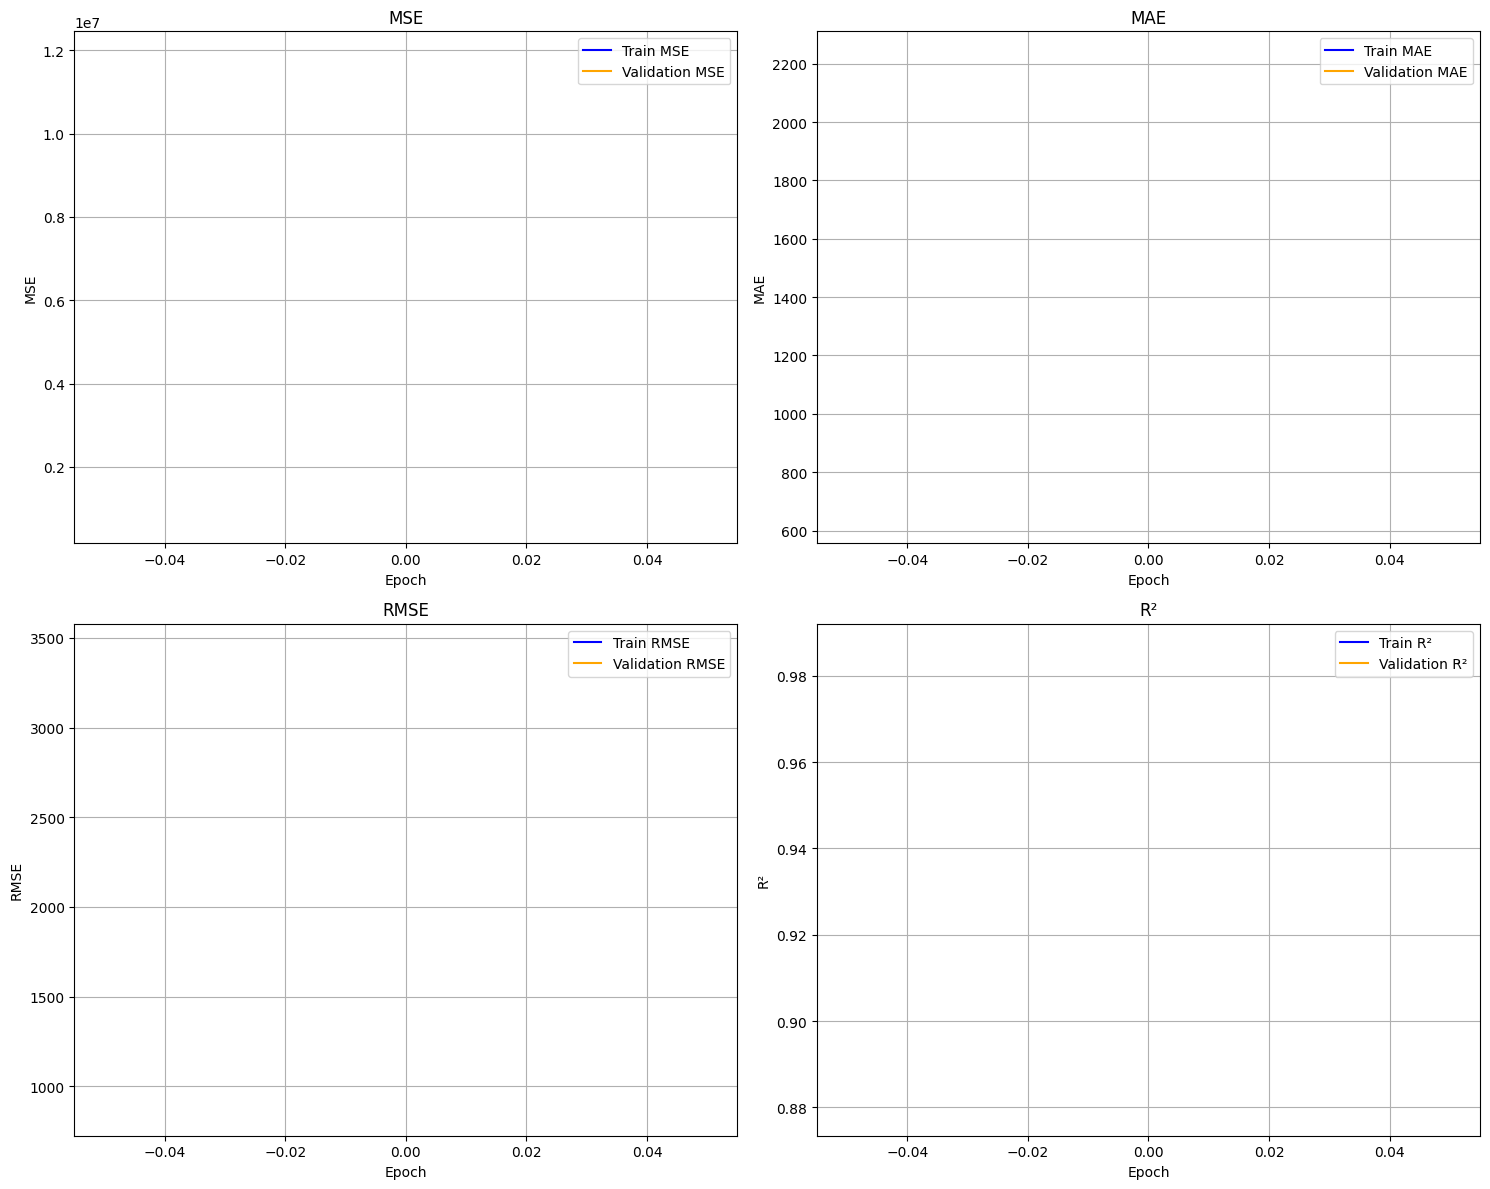

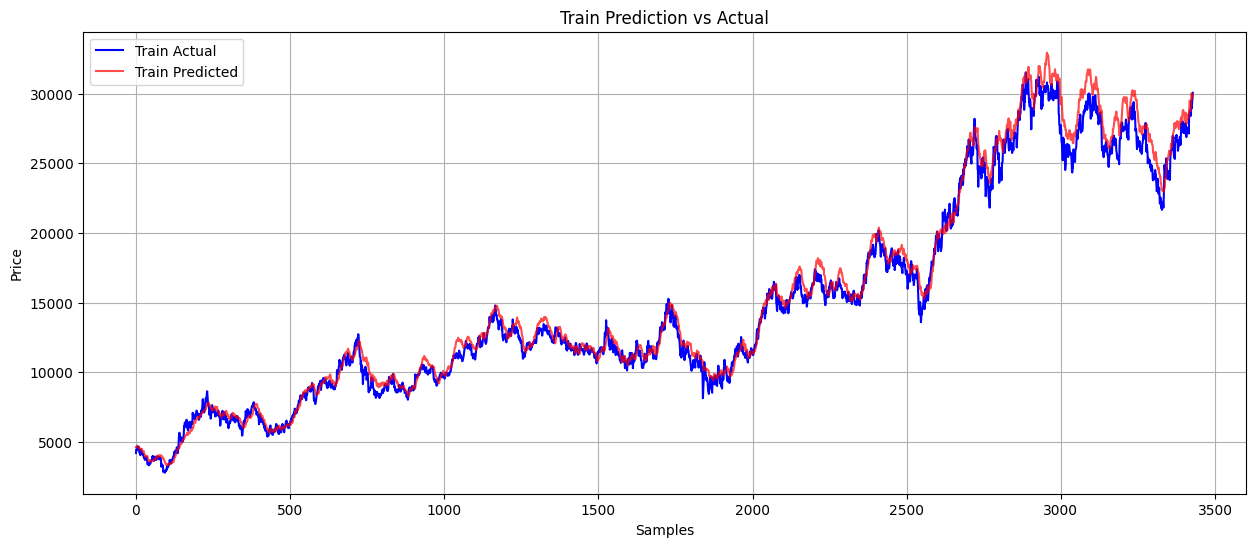

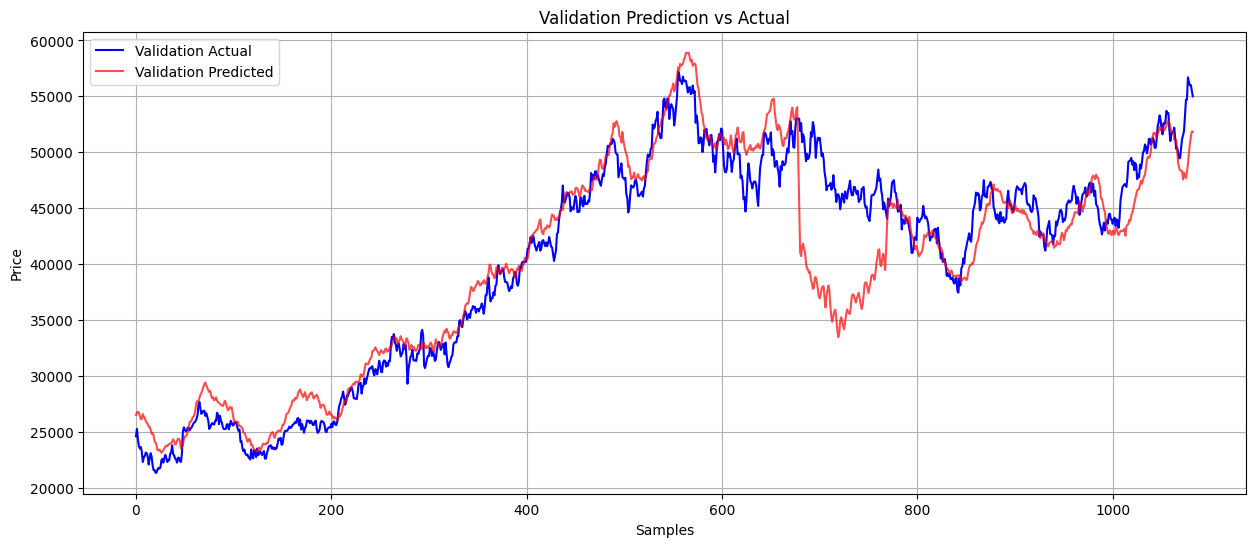

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model_metrics(model, x_train, y_train, x_val, y_val, scaler, figsize=(15, 12)):
    def calculate_metrics(x, y):
        # 예측 수행
        y_pred = model.predict(x)

        # 스케일 복원
        y_actual = scaler.inverse_transform(y)
        y_pred_actual = scaler.inverse_transform(y_pred)
        y_actual = np.exp(y_actual)
        y_pred_actual = np.exp(y_pred_actual)

        # 평가 지표 계산
        mse = mean_squared_error(y_actual, y_pred_actual)
        mae = mean_absolute_error(y_actual, y_pred_actual)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_actual, y_pred_actual)

        return y_actual, y_pred_actual, mse, mae, rmse, r2

    # Train 데이터 평가
    y_train_actual, y_train_pred, train_mse, train_mae, train_rmse, train_r2 = calculate_metrics(x_train, y_train)

    # Validation 데이터 평가
    y_val_actual, y_val_pred, val_mse, val_mae, val_rmse, val_r2 = calculate_metrics(x_val, y_val)

    # 손실 및 지표 시각화
    metrics = ['MSE', 'MAE', 'RMSE', 'R²']
    train_values = [train_mse, train_mae, train_rmse, train_r2]
    val_values = [val_mse, val_mae, val_rmse, val_r2]

    plt.figure(figsize=figsize)

    for i, (metric, train_val, val_val) in enumerate(zip(metrics, train_values, val_values)):
        plt.subplot(2, 2, i + 1)
        plt.plot(train_val, label=f'Train {metric}', color='blue')
        plt.plot(val_val, label=f'Validation {metric}', color='orange')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Train 데이터 예측 vs 실제 값 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_train_actual, label="Train Actual", color="b")
    plt.plot(y_train_pred, label="Train Predicted", color="r", alpha=0.7)
    plt.title("Train Prediction vs Actual")
    plt.xlabel("Samples")
    plt.ylabel("Price")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

    # Validation 데이터 예측 vs 실제 값 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_val_actual, label="Validation Actual", color="b")
    plt.plot(y_val_pred, label="Validation Predicted", color="r", alpha=0.7)
    plt.title("Validation Prediction vs Actual")
    plt.xlabel("Samples")
    plt.ylabel("Price")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

# 함수 호출 예시
evaluate_model_metrics(model7_2, x_train, y_train, x_val, y_val, y_scaler_int0)


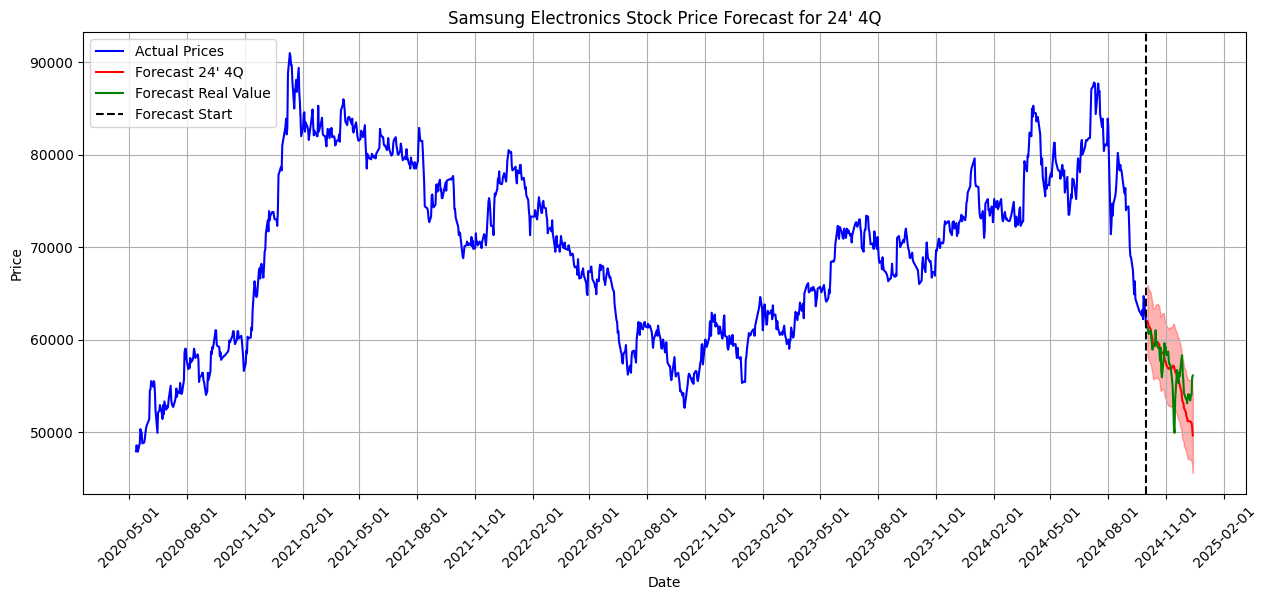

In [114]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_rever, label='Actual Prices', color='blue')
plt.plot(future_dates[:len(future_90_days_rever)], future_90_days_rever[:len(future_dates)], label='Forecast 24\' 4Q', color='red')
plt.plot(real_close.index, real_close.values, label='Forecast Real Value', color='green')
plt.fill_between(
    future_dates[:len(future_90_days_rever)],
    upper_90_days_rever.ravel(),
    lower_90_days_rever.ravel(),
    color='red', alpha=0.3
)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='black', linestyle='--', label='Forecast Start')

plt.title('Samsung Electronics Stock Price Forecast for 24\' 4Q')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Day 1 Prediction: [[59763.01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 2 Prediction: [[59989.77]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Day 3 Prediction: [[59796.19]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 4 Prediction: [[59692.555]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 5 Prediction: [[60369.066]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 6 Prediction: [[60950.566]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 7 Prediction: [[61295.062]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Day 8 Prediction: [[61461.66]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 9 Prediction: [[62038.418]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Day 10 Prediction: [[61909.332]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 11 Prediction: [[61864.72]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 12 Prediction: [[61304.48]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 13 Prediction: [[61635.52]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Day 14 Prediction: [[61825.56]]
1/1 ━━━━━━━━━━━━━━━━━━━

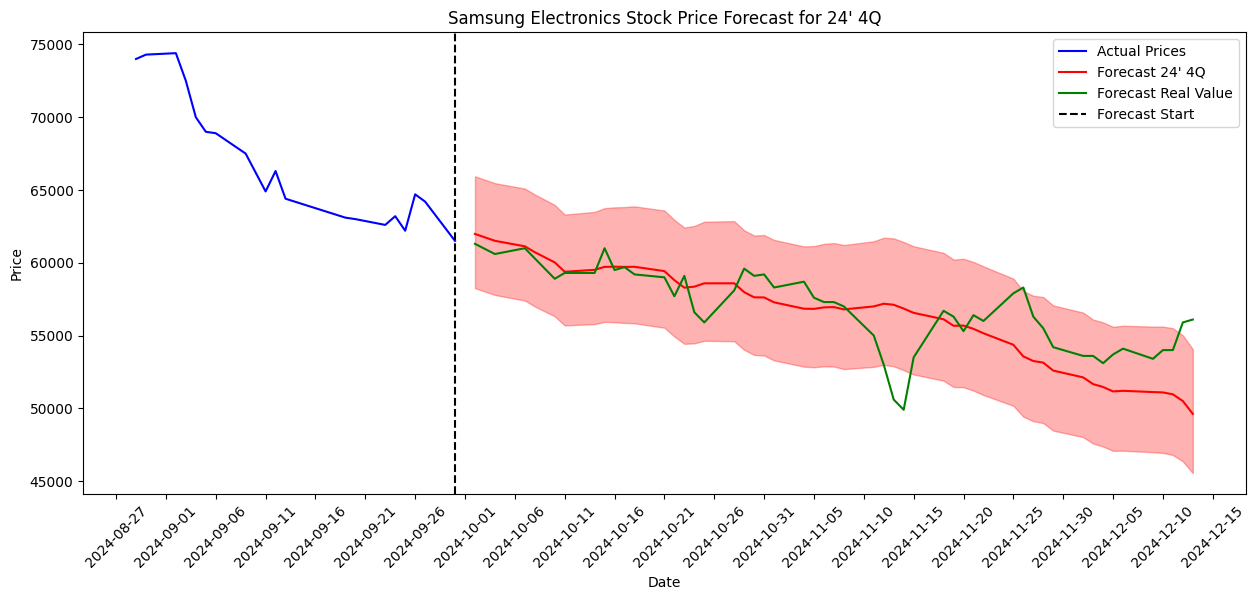

In [111]:
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model7_2, x_test, y_scaler_int0, steps=51, feature_generator=feature_generator)

y_test_rever = y_scaler_int0_thr40.inverse_transform(y_test[:len(test_dates)])
y_test_rever = np.exp(y_test_rever)

# 그래프 출력
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test_rever[-20:], label='Actual Prices', color='blue')
plt.plot(future_dates[:len(future_90_days_rever)], future_90_days_rever[:len(future_dates)], label='Forecast 24\' 4Q', color='red')
plt.plot(real_close.index, real_close.values, label='Forecast Real Value', color='green')
plt.fill_between(
    future_dates[:len(future_90_days_rever)],
    upper_90_days_rever.ravel(),
    lower_90_days_rever.ravel(),
    color='red', alpha=0.3
)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='black', linestyle='--', label='Forecast Start')

plt.title('Samsung Electronics Stock Price Forecast for 24\' 4Q')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
#plt.grid(True)
plt.show()

###8 **threshold40버전**

In [24]:
seq_length = 90  # 예: 30일간의 데이터를 기반으로 예측
x_train, y_train = create_sequences(x_train_int0_thr40, y_train_int0_thr40, seq_length)
x_val, y_val = create_sequences(x_val_int0_thr40, y_val_int0_thr40, seq_length)
x_test, y_test = create_sequences(x_test_int0_thr40, y_test_int0_thr40, seq_length)

In [55]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.1, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
54/54 - 24s - 448ms/step - loss: 0.0993 - mae: 0.2387 - val_loss: 0.0731 - val_mae: 0.2501
Epoch 2/100
54/54 - 5s - 86ms/step - loss: 0.0242 - mae: 0.1195 - val_loss: 0.0135 - val_mae: 0.0928
Epoch 3/100
54/54 - 1s - 23ms/step - loss: 0.0150 - mae: 0.0949 - val_loss: 0.0188 - val_mae: 0.1105
Epoch 4/100
54/54 - 1s - 24ms/step - loss: 0.0125 - mae: 0.0871 - val_loss: 0.0140 - val_mae: 0.0859
Epoch 5/100
54/54 - 1s - 20ms/step - loss: 0.0103 - mae: 0.0791 - val_loss: 0.0141 - val_mae: 0.0898
Epoch 6/100
54/54 - 1s - 19ms/step - loss: 0.0092 - mae: 0.0757 - val_loss: 0.0147 - val_mae: 0.0948
Epoch 7/100
54/54 - 1s - 18ms/step - loss: 0.0077 - mae: 0.0692 - val_loss: 0.0223 - val_mae: 0.1051
Epoch 8/100
54/54 - 1s - 24ms/step - loss: 0.0079 - mae: 0.0696 - val_loss: 0.0190 - val_mae: 0.0988
Epoch 9/100
54/54 - 1s - 18ms/step - loss: 0.0068 - mae: 0.0644 - val_loss: 0.0182 - val_mae: 0.0967
Epoch 10/100
54/54 - 1s - 18ms/step - loss: 0.0066 - mae: 0.0644 - val_loss: 0.0171 - val

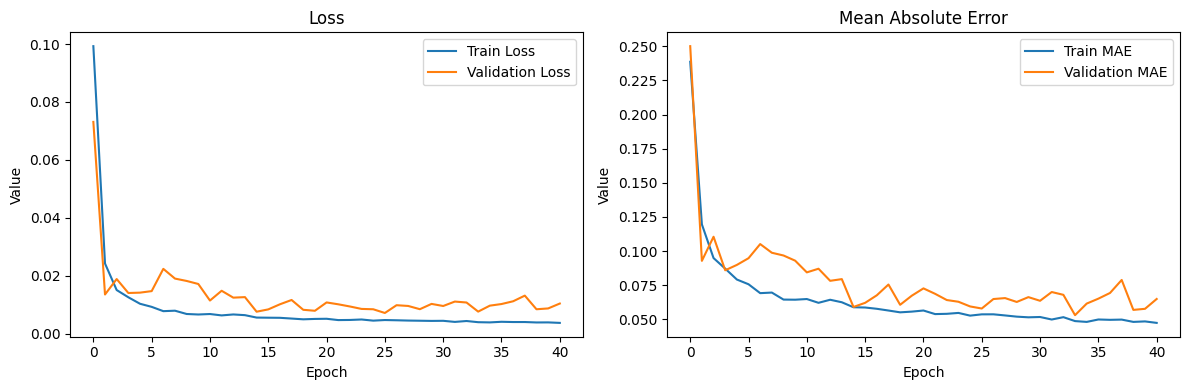

In [56]:
lossplot(history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Absolute Error (MAE): 12851.397892861276
Root Mean Squared Error (RMSE): 15922.039673780555


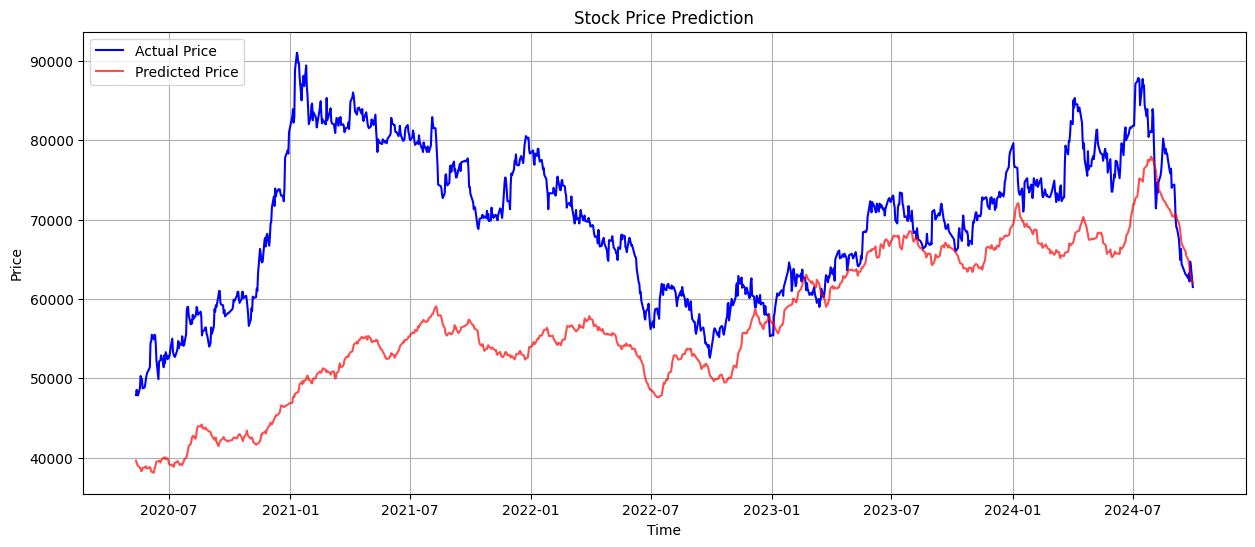

In [58]:
predictplot(model, x_test, y_test, y_scaler_int0_thr40, dates)
# model.save_weights(path+ 'ver0_int7.weights.h5')
# model.save(path+'ver0_int7Model.h5')
# model.save(path+'ver0_int8_thr40Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 1 Prediction: [[61980.168]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 2 Prediction: [[61508.453]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Day 3 Prediction: [[61129.746]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 4 Prediction: [[60724.93]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 5 Prediction: [[60024.445]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Day 6 Prediction: [[59382.082]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 7 Prediction: [[59513.22]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 8 Prediction: [[59717.605]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 9 Prediction: [[59729.965]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 10 Prediction: [[59714.473]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 11 Prediction: [[59723.414]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 12 Prediction: [[59426.56]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 13 Prediction: [[58804.05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 14 Prediction: [[58288.258]]
1/1 ━━━━━━━━━━━━━━━

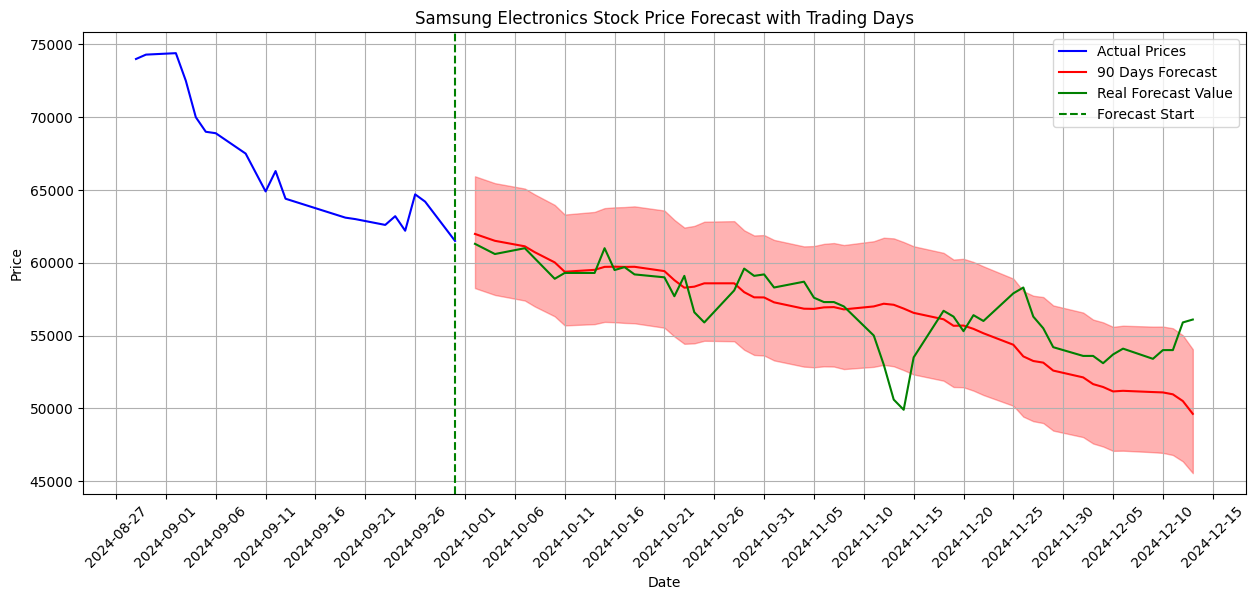

In [71]:
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, y_scaler_int0_thr40, steps=51, feature_generator=feature_generator)


# 스케일 복원 및 로그 복원
y_test_rever = y_scaler_int0_thr40.inverse_transform(y_test[:len(test_dates)])
y_test_rever = np.exp(y_test_rever)

future_90_days_rever = y_scaler_int0_thr40.inverse_transform(future_90_days.reshape(-1, 1))
future_90_days_rever = np.exp(future_90_days_rever)

upper_90_days_rever = y_scaler_int0_thr40.inverse_transform(upper_90_days.reshape(-1, 1))
upper_90_days_rever = np.exp(upper_90_days_rever)

lower_90_days_rever = y_scaler_int0_thr40.inverse_transform(lower_90_days.reshape(-1, 1))
lower_90_days_rever = np.exp(lower_90_days_rever)

# 그래프 출력
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test_rever[-20:], label='Actual Prices', color='blue')
plt.plot(future_dates[:len(future_90_days_rever)], future_90_days_rever[:len(future_dates)], label='90 Days Forecast', color='red')
plt.plot(real_close.index, real_close.values, label='Real Forecast Value', color='green')
plt.fill_between(
    future_dates[:len(future_90_days_rever)],
    upper_90_days_rever.ravel(),
    lower_90_days_rever.ravel(),
    color='red', alpha=0.3
)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Samsung Electronics Stock Price Forecast with Trading Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Day 1 Prediction: [[61980.168]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Day 2 Prediction: [[61508.453]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Day 3 Prediction: [[61129.746]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Day 4 Prediction: [[60724.93]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 5 Prediction: [[60024.445]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Day 6 Prediction: [[59382.082]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Day 7 Prediction: [[59513.22]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Day 8 Prediction: [[59717.605]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Day 9 Prediction: [[59729.965]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 10 Prediction: [[59714.473]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 11 Prediction: [[59723.414]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Day 12 Prediction: [[59426.56]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Day 13 Prediction: [[58804.05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Day 14 Prediction: [[58288.258]]
1/1 ━━━━━━━━━━━━━━━

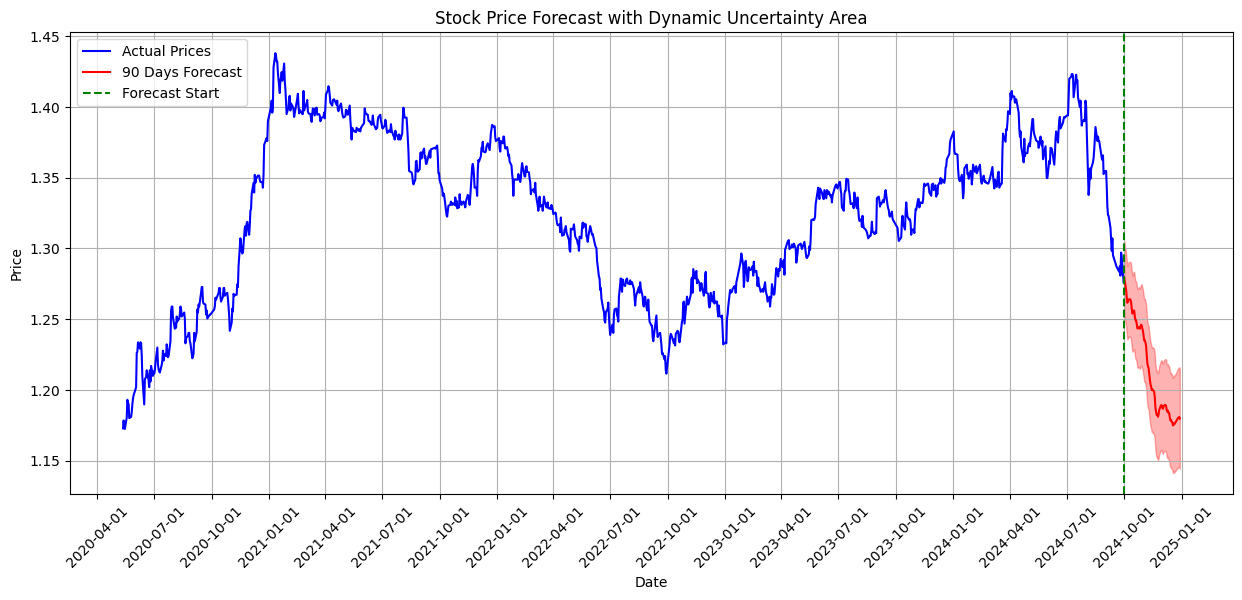

In [66]:
feature_generator = simple_feature_generator
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, y_scaler_int0_thr40, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

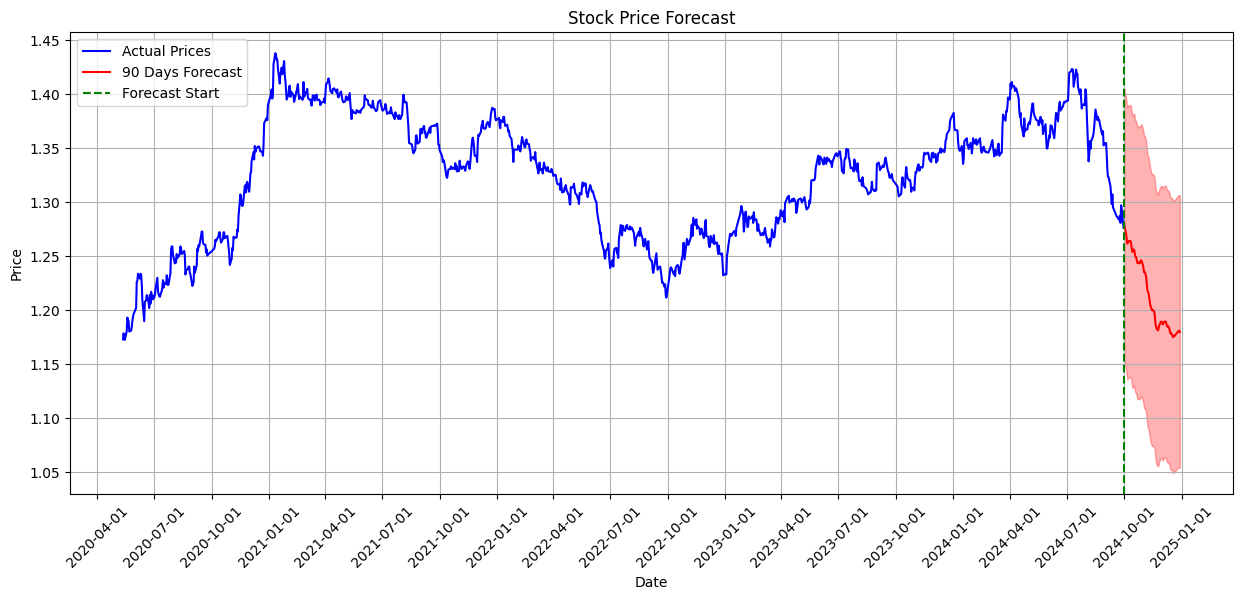

In [67]:
future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# !! Before Outlier: Same (1)

In [ ]:
seq_length = 90
x_train, y_train = create_sequences(x_train_same1, y_train_same1, seq_length)
x_val, y_val = create_sequences(x_val_same1, y_val_same1, seq_length)
x_test, y_test = create_sequences(x_test_same1, y_test_same1, seq_length)

###1 (seq_len=90)

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
54/54 - 87s - 2s/step - loss: 0.9053 - mae: 0.6548 - val_loss: 1.3668 - val_mae: 0.8099
Epoch 2/100
54/54 - 80s - 1s/step - loss: 0.1265 - mae: 0.2799 - val_loss: 1.2780 - val_mae: 0.7352
Epoch 3/100
54/54 - 80s - 1s/step - loss: 0.0746 - mae: 0.2191 - val_loss: 1.3096 - val_mae: 0.7305
Epoch 4/100
54/54 - 64s - 1s/step - loss: 0.0473 - mae: 0.1724 - val_loss: 1.2951 - val_mae: 0.7384
Epoch 5/100
54/54 - 77s - 1s/step - loss: 0.0370 - mae: 0.1535 - val_loss: 1.2778 - val_mae: 0.7439
Epoch 6/100
54/54 - 83s - 2s/step - loss: 0.0309 - mae: 0.1388 - val_loss: 1.2944 - val_mae: 0.7717
Epoch 7/100
54/54 - 60s - 1s/step - loss: 0.0267 - mae: 0.1291 - val_loss: 1.2731 - val_mae: 0.7665
Epoch 8/100
54/54 - 86s - 2s/step - loss: 0.0213 - mae: 0.1157 - val_loss: 1.2631 - val_mae: 0.7767
Epoch 9/100
54/54 - 78s - 1s/step - loss: 0.0195 - mae: 0.1111 - val_loss: 1.2500 - val_mae: 0.7742
Epoch 10/100
54/54 - 81s - 2s/step - loss: 0.0168 - mae: 0.1028 - val_loss: 1.2644 - val_mae: 0.7850

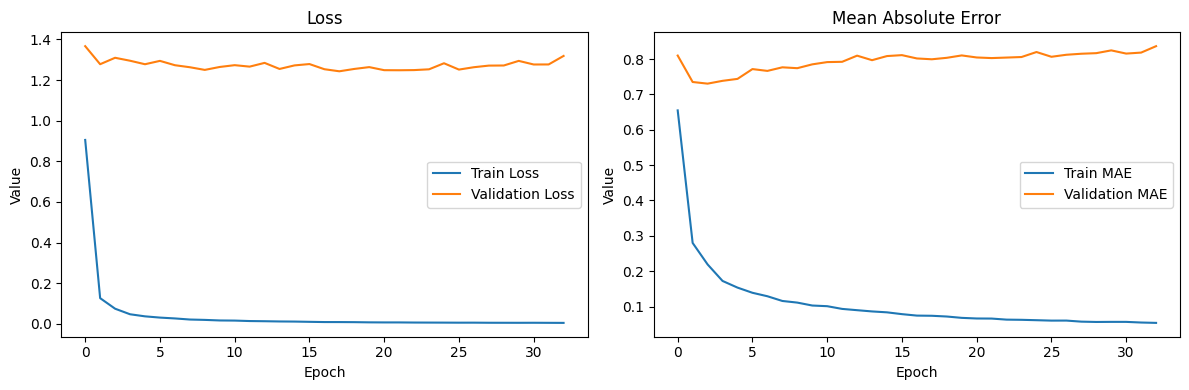

In [ ]:
lossplot(history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step
Mean Absolute Error (MAE): 7.376131256730462
Root Mean Squared Error (RMSE): 7.417744288102769


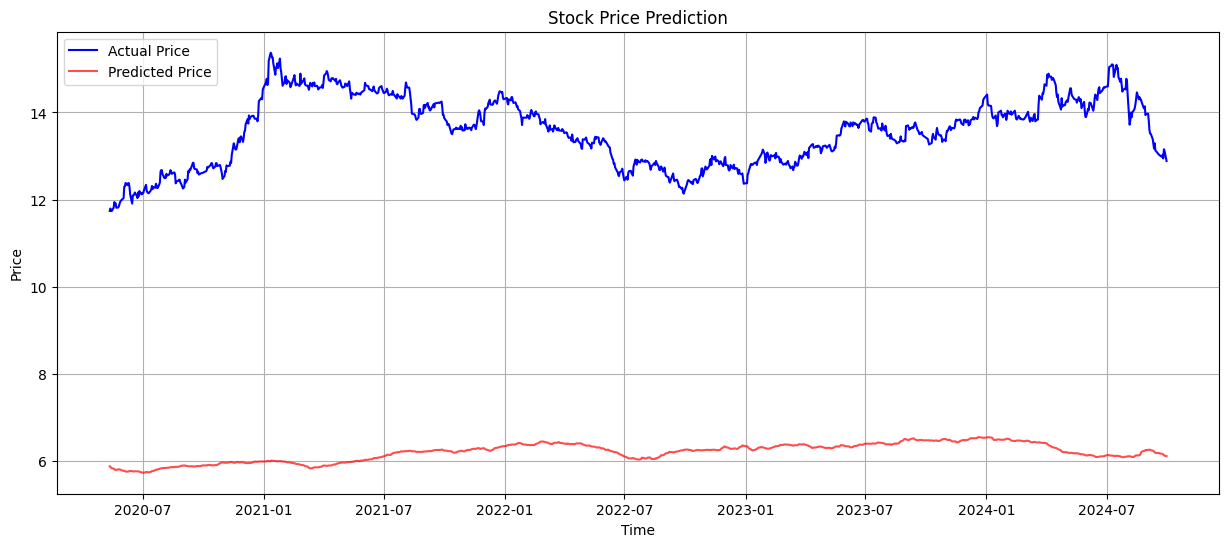

In [ ]:
predictplot(model, x_test, y_test, y_scaler, dates)
# model.save_weights(path+ 'ver0_int7.weights.h5')
# model.save(path+'ver0_int7Model.h5')
# model.save(path+'ver0_int7Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Day 1 Prediction: -0.756925106048584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 2 Prediction: -0.7381904721260071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 3 Prediction: -0.7196685671806335
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 4 Prediction: -0.7005511522293091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 5 Prediction: -0.6830517053604126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 6 Prediction: -0.665300726890564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Day 7 Prediction: -0.6463227868080139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 8 Prediction: -0.6266564130783081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 9 Prediction: -0.6063041090965271
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 10 Prediction: -0.5884343981742859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 11 Prediction: -0.5725091099739075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 12 Prediction: -0.558520495891571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Day 13 Prediction: -0.543488085269928
1/1 ━━━━━━━━

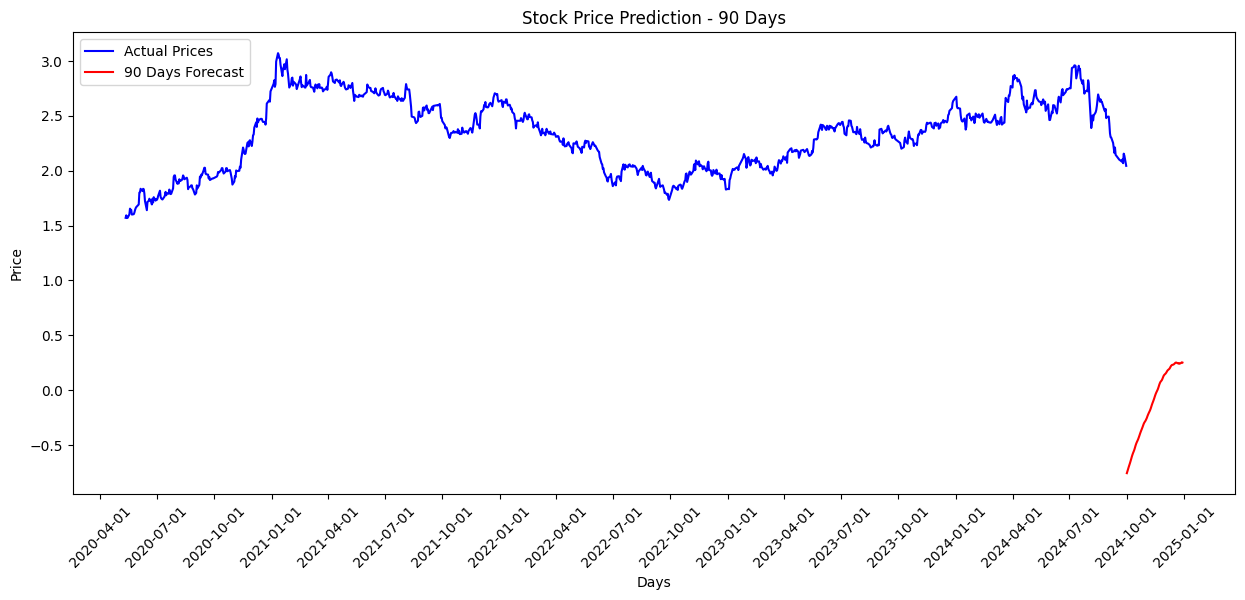

In [ ]:
def predict_future(model, x_test, steps=90):
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 입력 시퀀스를 선택

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        print(f"Day {i+1} Prediction: {prediction}")  # 각 예측값 출력

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)

test_dates = ddf['Date'][4782:]
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)
future_90_days = predict_future(model, x_test, steps=90)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 포맷 지정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 주요 틱을 월 단위로 표시
plt.xticks(rotation=45)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

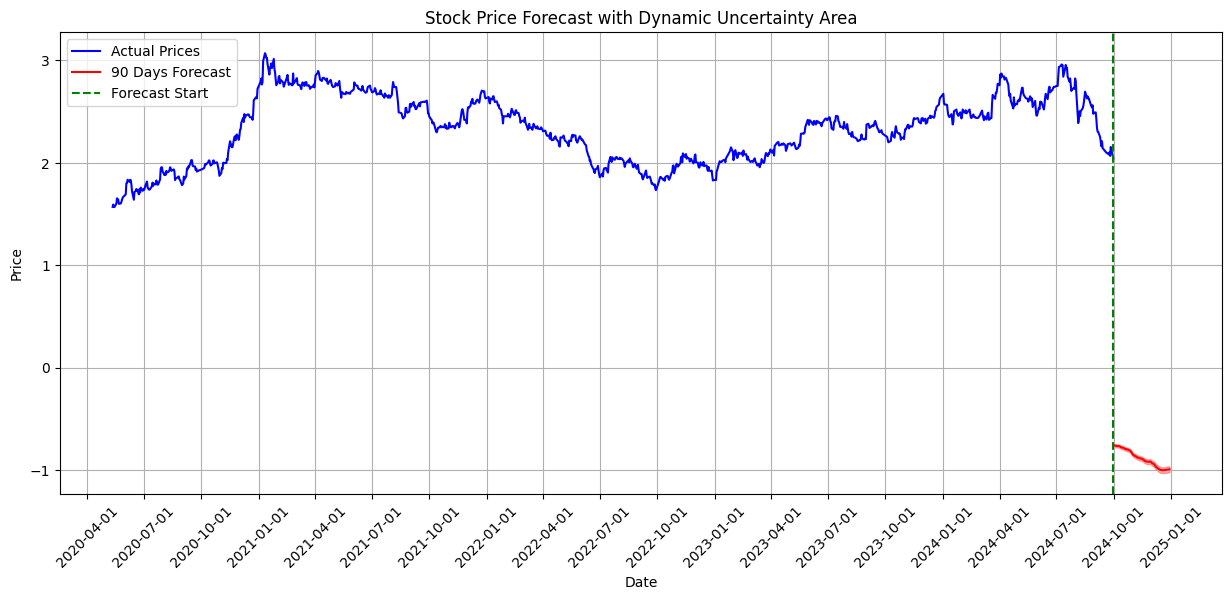

In [ ]:
def predict_future_dynamic(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 동적으로 불확실성 계산 (처음에는 좁고 끝으로 갈수록 퍼지는 영역)
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 비율 증가 (처음에는 2%, 끝에는 약 12%까지)

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), np.array(upper_bounds), np.array(lower_bounds)

def simple_feature_generator(current_input, prediction):
    """
    피처 값을 단순히 이전 값으로 유지하는 예제 함수
    """
    last_features = current_input[0, -1, :-1]  # 마지막 피처 값 가져오기
    return last_features

feature_generator = simple_feature_generator
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

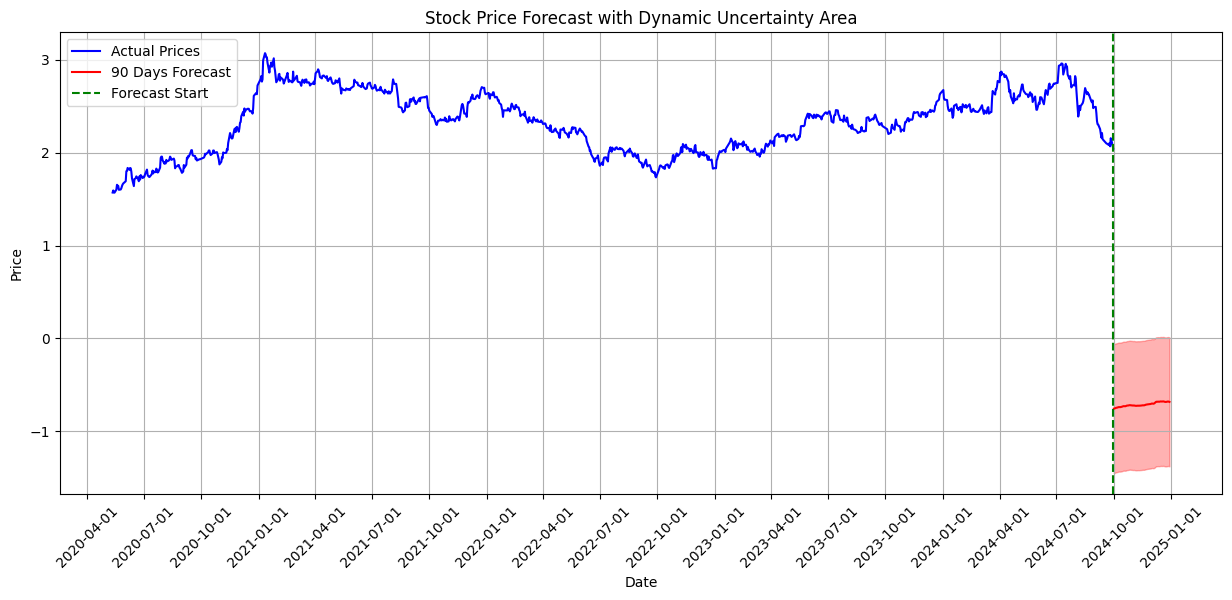

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound



future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()


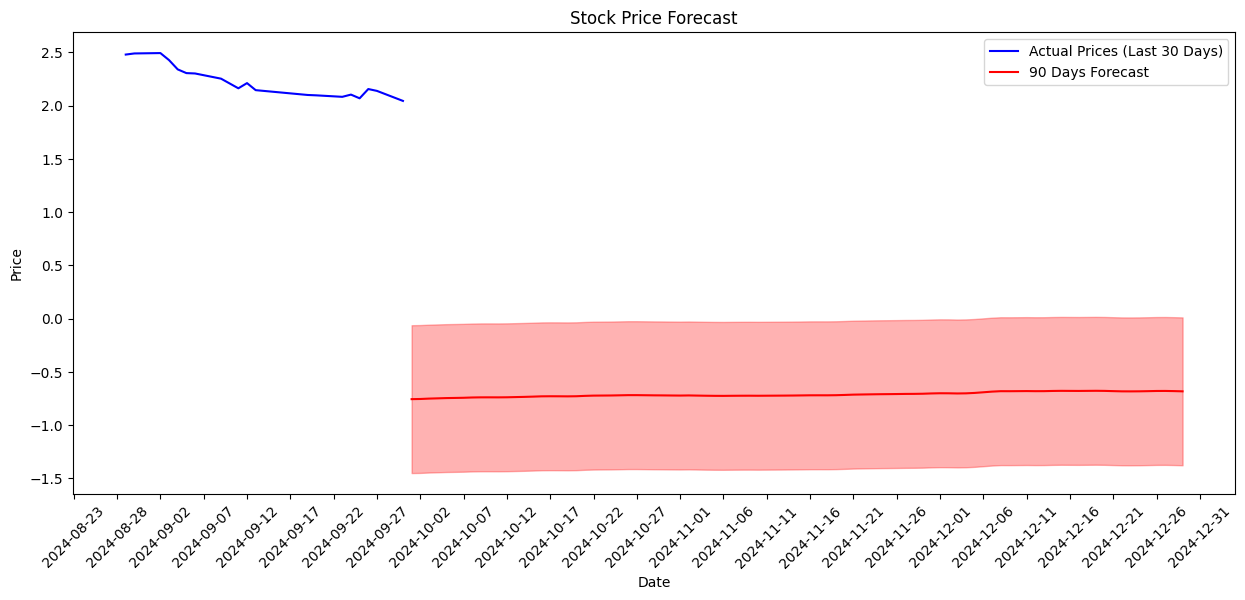

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
#plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

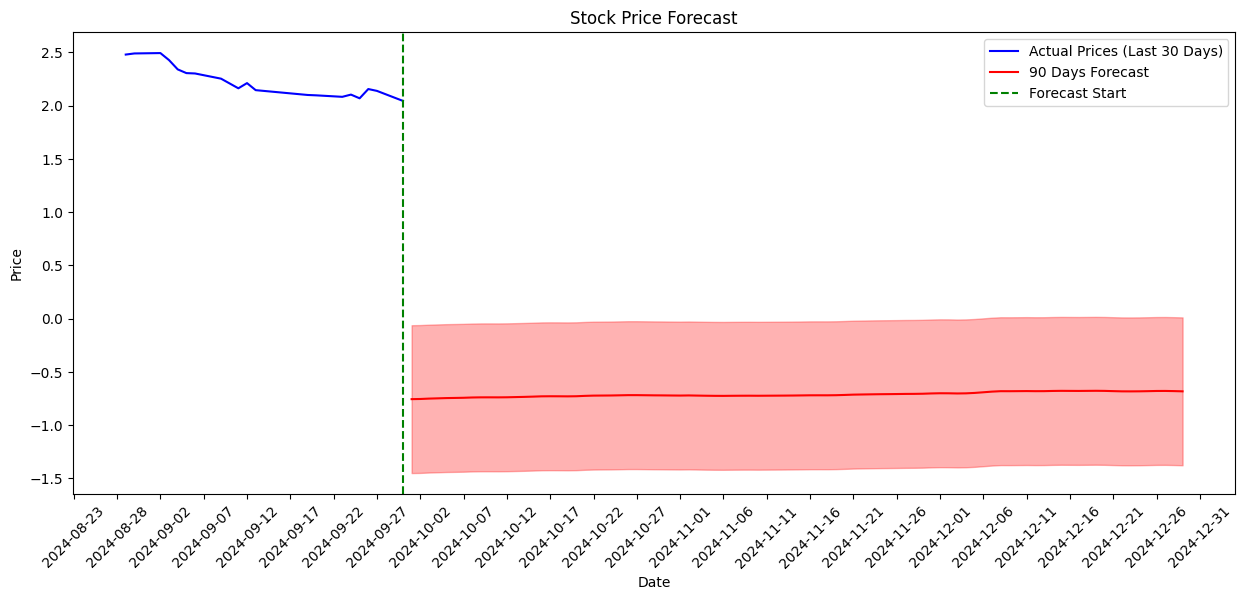

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


# !! Before Outlier: Interp (1)

In [ ]:
seq_length = 90
x_train, y_train = create_sequences(x_train_int1, y_train_int1, seq_length)
x_val, y_val = create_sequences(x_val_int1, y_val_int1, seq_length)
x_test, y_test = create_sequences(x_test_int1, y_test_int1, seq_length)

###1 (seq_len=90)

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
54/54 - 78s - 1s/step - loss: 0.4983 - mae: 0.5278 - val_loss: 0.1732 - val_mae: 0.2880
Epoch 2/100
54/54 - 79s - 1s/step - loss: 0.1220 - mae: 0.2769 - val_loss: 0.1746 - val_mae: 0.3184
Epoch 3/100
54/54 - 61s - 1s/step - loss: 0.0506 - mae: 0.1788 - val_loss: 0.1511 - val_mae: 0.3153
Epoch 4/100
54/54 - 82s - 2s/step - loss: 0.0308 - mae: 0.1392 - val_loss: 0.1582 - val_mae: 0.3313
Epoch 5/100
54/54 - 82s - 2s/step - loss: 0.0246 - mae: 0.1244 - val_loss: 0.1807 - val_mae: 0.3510
Epoch 6/100
54/54 - 82s - 2s/step - loss: 0.0201 - mae: 0.1127 - val_loss: 0.1674 - val_mae: 0.3404
Epoch 7/100
54/54 - 82s - 2s/step - loss: 0.0181 - mae: 0.1073 - val_loss: 0.1752 - val_mae: 0.3530
Epoch 8/100
54/54 - 82s - 2s/step - loss: 0.0158 - mae: 0.0993 - val_loss: 0.1678 - val_mae: 0.3486
Epoch 9/100
54/54 - 82s - 2s/step - loss: 0.0143 - mae: 0.0945 - val_loss: 0.1684 - val_mae: 0.3484
Epoch 10/100
54/54 - 82s - 2s/step - loss: 0.0128 - mae: 0.0890 - val_loss: 0.1902 - val_mae: 0.3653

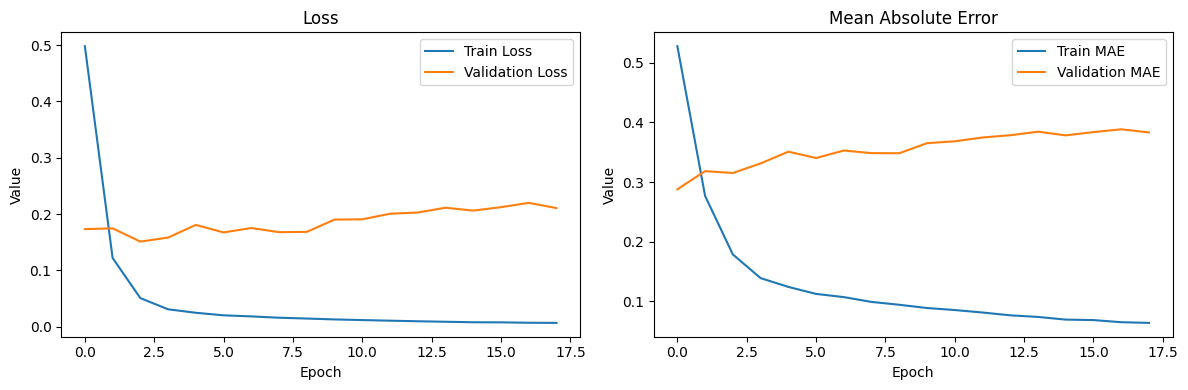

In [ ]:
lossplot(history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step
Mean Absolute Error (MAE): 3.575374078861533
Root Mean Squared Error (RMSE): 3.65388551162076


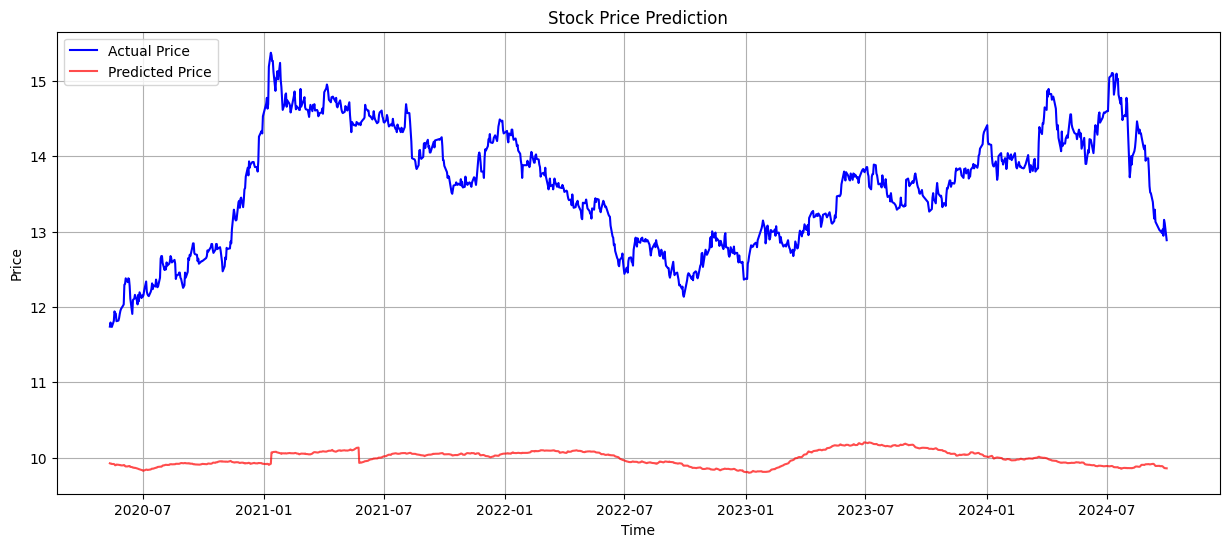

In [ ]:
predictplot(model, x_test, y_test, y_scaler, dates)
# model.save_weights(path+ 'ver0_int7.weights.h5')
# model.save(path+'ver0_int7Model.h5')
# model.save(path+'ver0_int7Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 1 Prediction: 0.793911337852478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 2 Prediction: 0.7974753379821777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 3 Prediction: 0.7982197999954224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 4 Prediction: 0.7978904843330383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 5 Prediction: 0.7967763543128967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Day 6 Prediction: 0.7999789118766785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Day 7 Prediction: 0.8074463605880737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Day 8 Prediction: 0.8150362968444824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 9 Prediction: 0.8235100507736206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Day 10 Prediction: 0.8273986577987671
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 11 Prediction: 0.8287237286567688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 12 Prediction: 0.8295490741729736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 13 Prediction: 0.8342912197113037
1/1 ━━━━━━━━━━━━━━━━━━

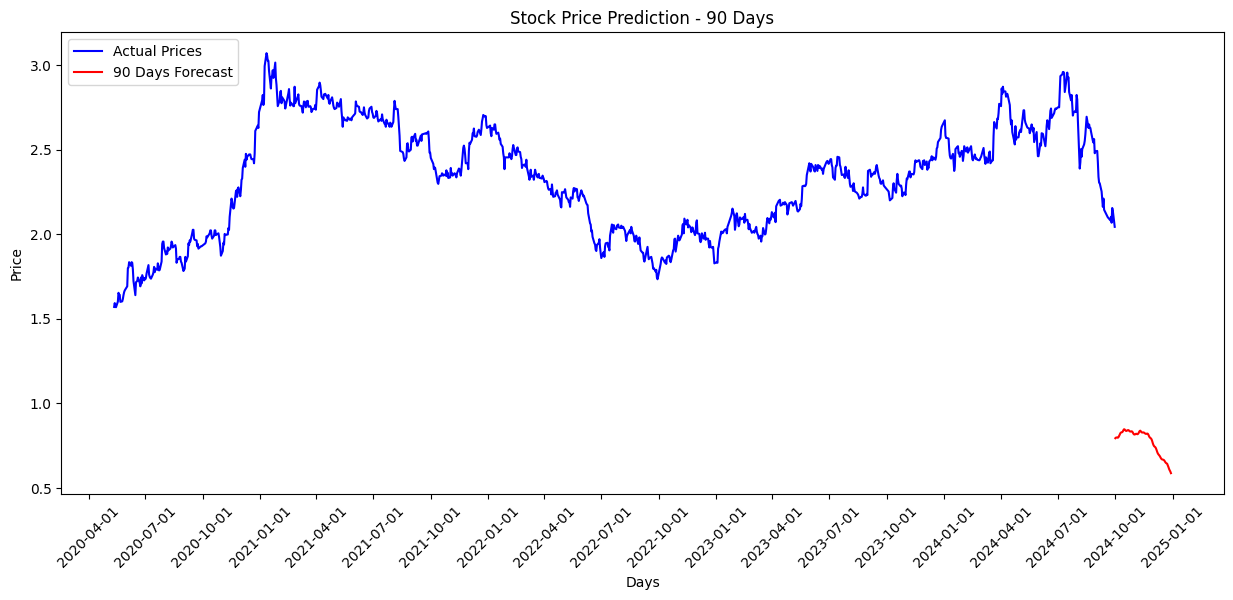

In [ ]:
def predict_future(model, x_test, steps=90):
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 입력 시퀀스를 선택

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        print(f"Day {i+1} Prediction: {prediction}")  # 각 예측값 출력

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)

test_dates = ddf['Date'][4782:]
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)
future_90_days = predict_future(model, x_test, steps=90)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 포맷 지정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 주요 틱을 월 단위로 표시
plt.xticks(rotation=45)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

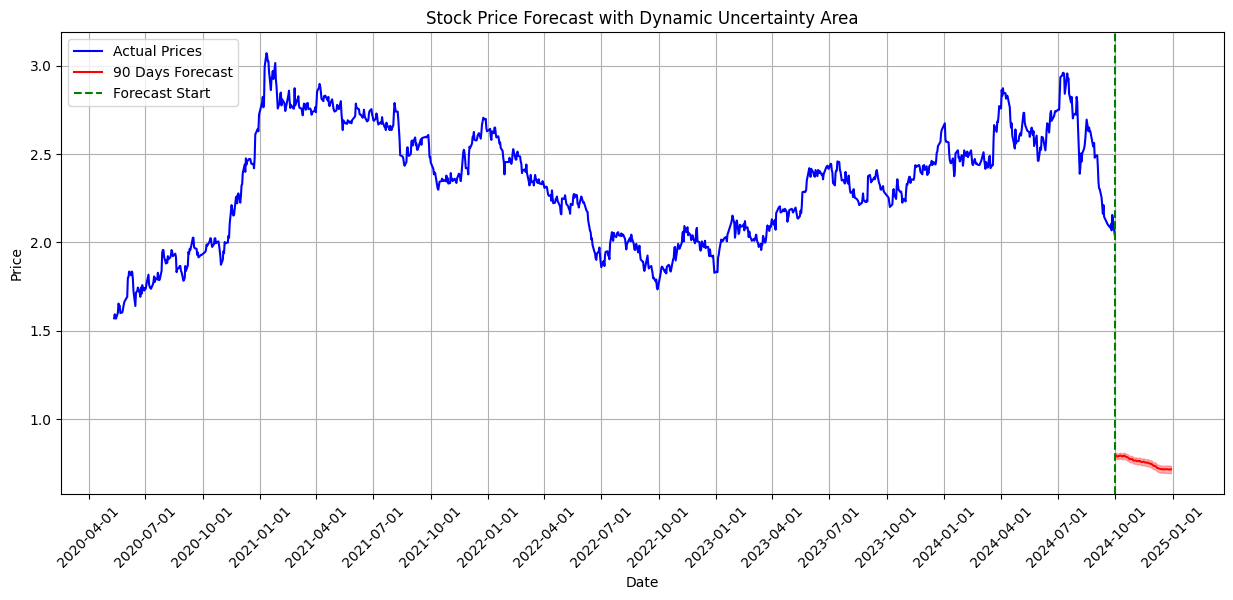

In [ ]:
def predict_future_dynamic(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 동적으로 불확실성 계산 (처음에는 좁고 끝으로 갈수록 퍼지는 영역)
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 비율 증가 (처음에는 2%, 끝에는 약 12%까지)

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), np.array(upper_bounds), np.array(lower_bounds)

def simple_feature_generator(current_input, prediction):
    """
    피처 값을 단순히 이전 값으로 유지하는 예제 함수
    """
    last_features = current_input[0, -1, :-1]  # 마지막 피처 값 가져오기
    return last_features

feature_generator = simple_feature_generator
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

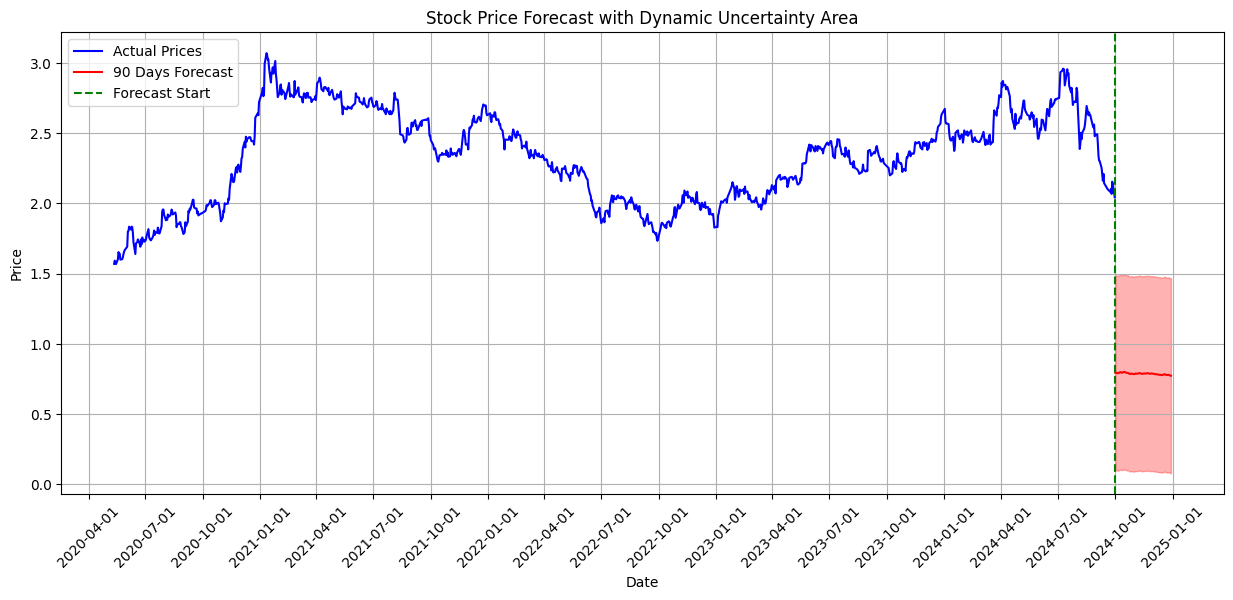

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound



future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()


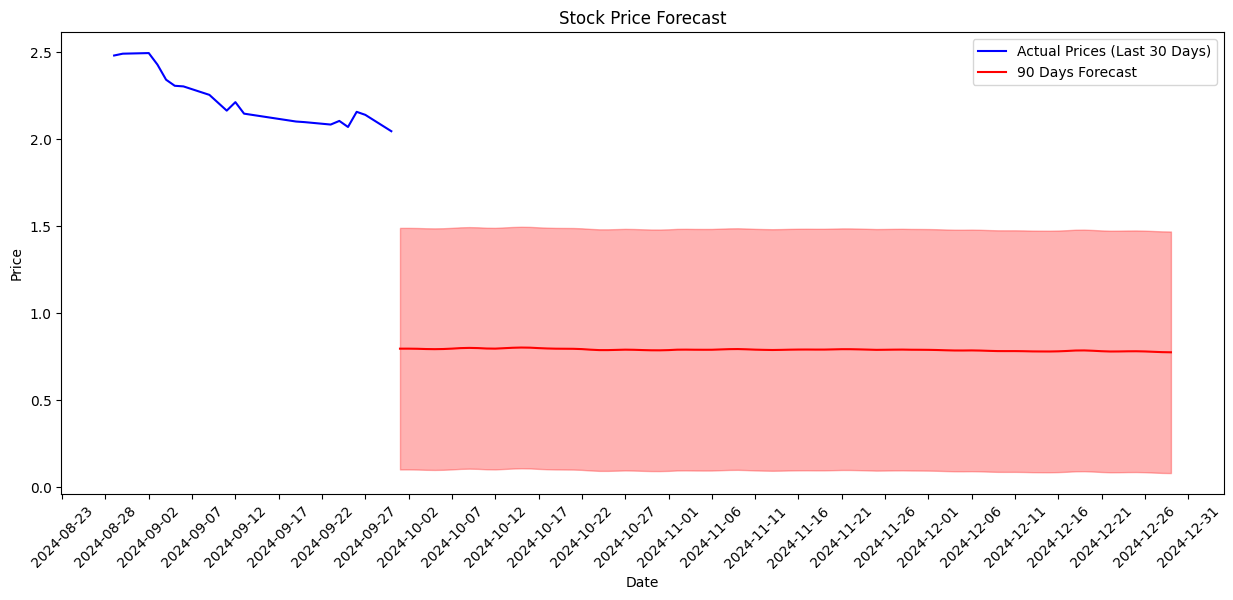

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
#plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

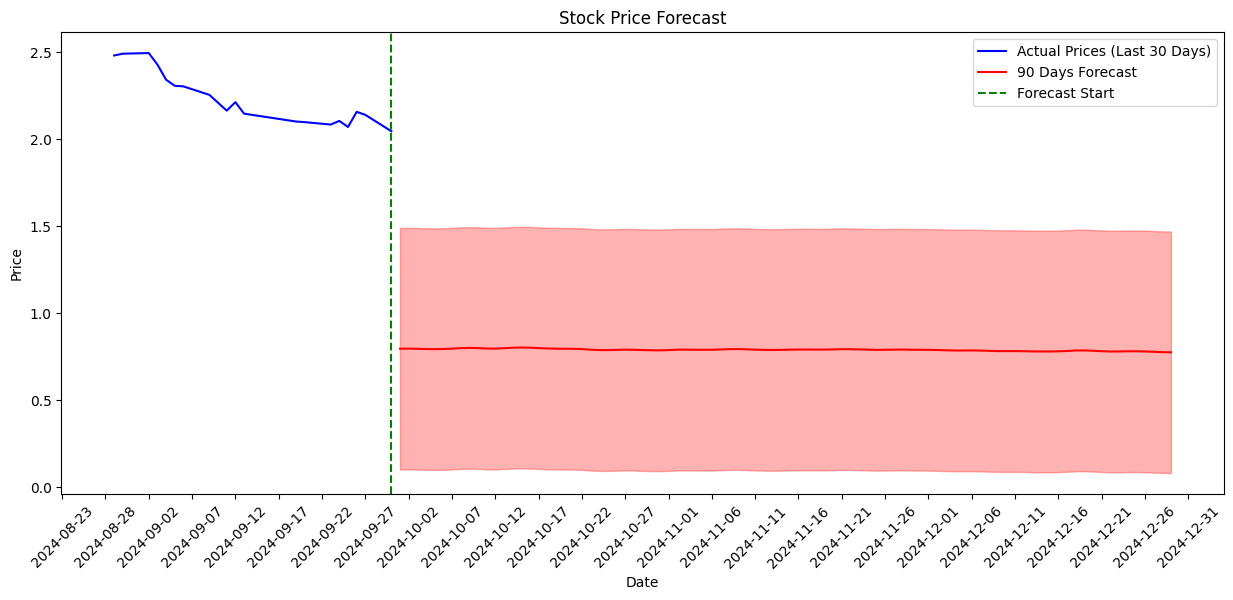

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


# !! Final: same (_)

### 1

In [ ]:
# num_heads=4, key_dim=64, ff_dim=128, num_blocks=2, dropout_rate=0.2
# 스케쥴러 안씀
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.8153 - mae: 0.6255 - val_loss: 0.1364 - val_mae: 0.3047
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0585 - mae: 0.1903 - val_loss: 0.0859 - val_mae: 0.2376
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0322 - mae: 0.1423 - val_loss: 0.0785 - val_mae: 0.2230
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0196 - mae: 0.1125 - val_loss: 0.0722 - val_mae: 0.2114
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0140 - mae: 0.0946 - val_loss: 0.0418 - val_mae: 0.1667
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0116 - mae: 0.0851 - val_loss: 0.0567 - val_mae: 0.1832
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0099 - mae: 0.0784 - val_loss: 0.0439 - val_mae: 0.1605
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0099 - mae: 0.0785 - val_loss: 0.0499 - val_mae: 0.1626
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━

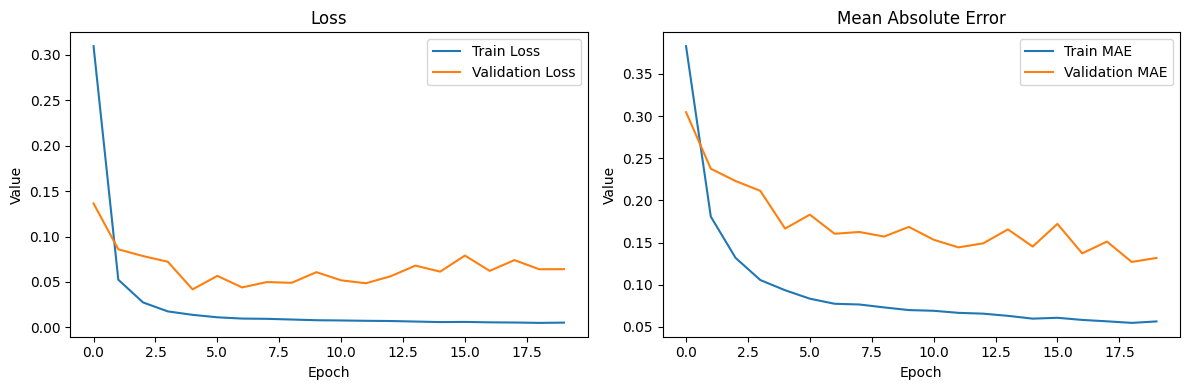

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Absolute Error (MAE): 0.6892942143613006
Root Mean Squared Error (RMSE): 0.6949168375730292


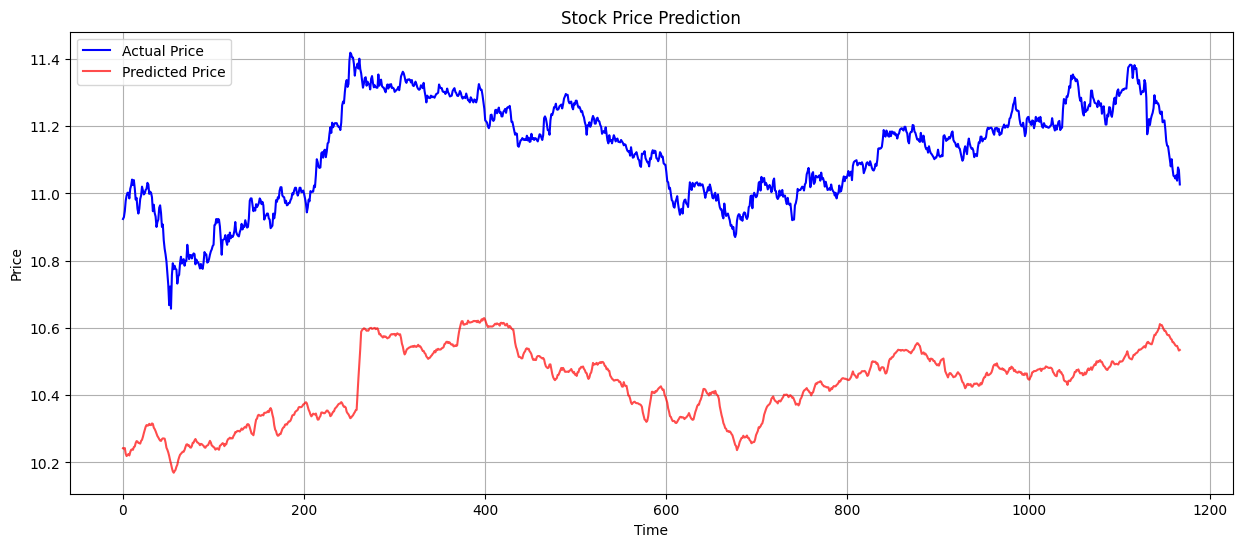

In [ ]:
predictplot(model, x_test, y_test, y_scaler)

### 2

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=3, dropout_rate=0.3,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 19s - 337ms/step - loss: 0.5347 - mae: 0.4931 - val_loss: 0.1274 - val_mae: 0.3338
Epoch 2/100
55/55 - 5s - 97ms/step - loss: 0.0732 - mae: 0.2152 - val_loss: 0.0569 - val_mae: 0.1949
Epoch 3/100
55/55 - 11s - 204ms/step - loss: 0.0350 - mae: 0.1485 - val_loss: 0.0412 - val_mae: 0.1650
Epoch 4/100
55/55 - 14s - 258ms/step - loss: 0.0227 - mae: 0.1197 - val_loss: 0.0233 - val_mae: 0.1239
Epoch 5/100
55/55 - 17s - 317ms/step - loss: 0.0174 - mae: 0.1041 - val_loss: 0.0235 - val_mae: 0.1234
Epoch 6/100
55/55 - 5s - 96ms/step - loss: 0.0159 - mae: 0.0993 - val_loss: 0.0145 - val_mae: 0.1007
Epoch 7/100
55/55 - 10s - 187ms/step - loss: 0.0146 - mae: 0.0947 - val_loss: 0.0273 - val_mae: 0.1303
Epoch 8/100
55/55 - 13s - 228ms/step - loss: 0.0132 - mae: 0.0909 - val_loss: 0.0221 - val_mae: 0.1179
Epoch 9/100
55/55 - 9s - 171ms/step - loss: 0.0130 - mae: 0.0892 - val_loss: 0.0267 - val_mae: 0.1259
Epoch 10/100
55/55 - 9s - 158ms/step - loss: 0.0127 - mae: 0.0889 - val_loss: 

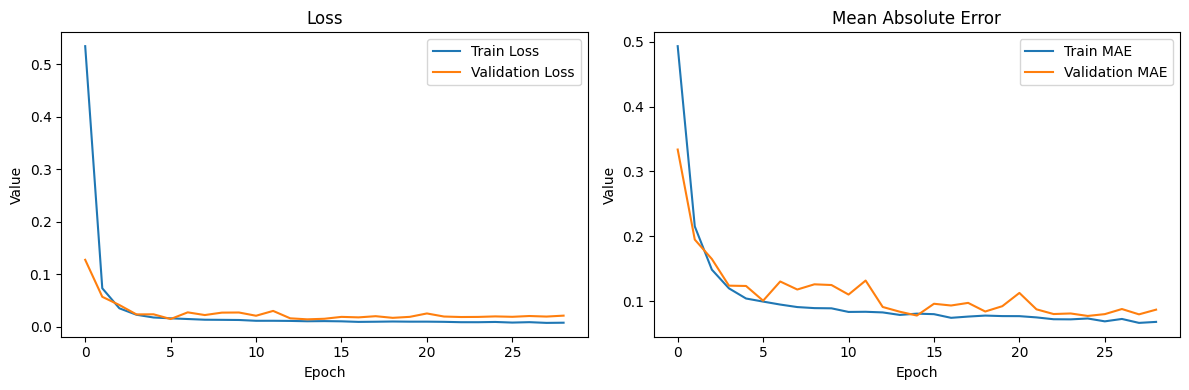

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Mean Absolute Error (MAE): 0.44241797131868127
Root Mean Squared Error (RMSE): 0.45797342831382176


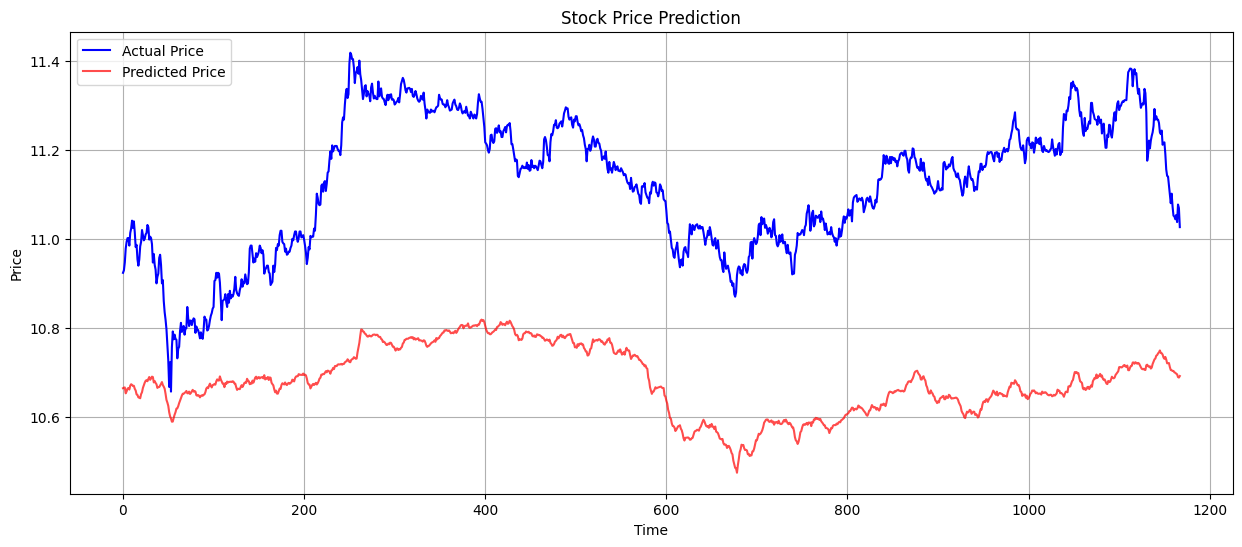

In [ ]:
predictplot(model, x_test, y_test, y_scaler)

#!! Final: interp (_)

In [ ]:
seq_length = 5  # 예: 30일간의 데이터를 기반으로 예측
x_train, y_train = create_sequences(x_train_int_df, y_train_int_df, seq_length)
x_val, y_val = create_sequences(x_val_int_df, y_val_int_df, seq_length)
x_test, y_test = create_sequences(x_test_int_df, y_test_int_df, seq_length)

###1

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=3, dropout_rate=0.3,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#model.save_weights(path+ 'f_int1')
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 18s - 324ms/step - loss: 0.7629 - mae: 0.5550 - val_loss: 0.2063 - val_mae: 0.4332
Epoch 2/100
55/55 - 16s - 296ms/step - loss: 0.0849 - mae: 0.2305 - val_loss: 0.0668 - val_mae: 0.2149
Epoch 3/100
55/55 - 15s - 275ms/step - loss: 0.0501 - mae: 0.1781 - val_loss: 0.0366 - val_mae: 0.1669
Epoch 4/100
55/55 - 5s - 99ms/step - loss: 0.0343 - mae: 0.1470 - val_loss: 0.0479 - val_mae: 0.1785
Epoch 5/100
55/55 - 8s - 148ms/step - loss: 0.0266 - mae: 0.1294 - val_loss: 0.0564 - val_mae: 0.1992
Epoch 6/100
55/55 - 7s - 135ms/step - loss: 0.0247 - mae: 0.1259 - val_loss: 0.0223 - val_mae: 0.1241
Epoch 7/100
55/55 - 10s - 187ms/step - loss: 0.0191 - mae: 0.1098 - val_loss: 0.0268 - val_mae: 0.1297
Epoch 8/100
55/55 - 12s - 227ms/step - loss: 0.0169 - mae: 0.1036 - val_loss: 0.0225 - val_mae: 0.1187
Epoch 9/100
55/55 - 8s - 148ms/step - loss: 0.0157 - mae: 0.0989 - val_loss: 0.0222 - val_mae: 0.1158
Epoch 10/100
55/55 - 10s - 182ms/step - loss: 0.0139 - mae: 0.0933 - val_loss:

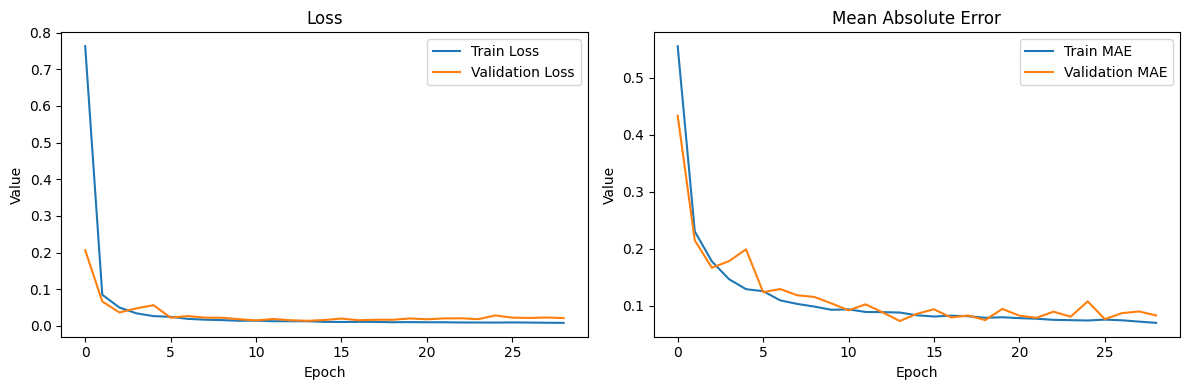

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Mean Absolute Error (MAE): 0.24338110041365704
Root Mean Squared Error (RMSE): 0.27005509070520123


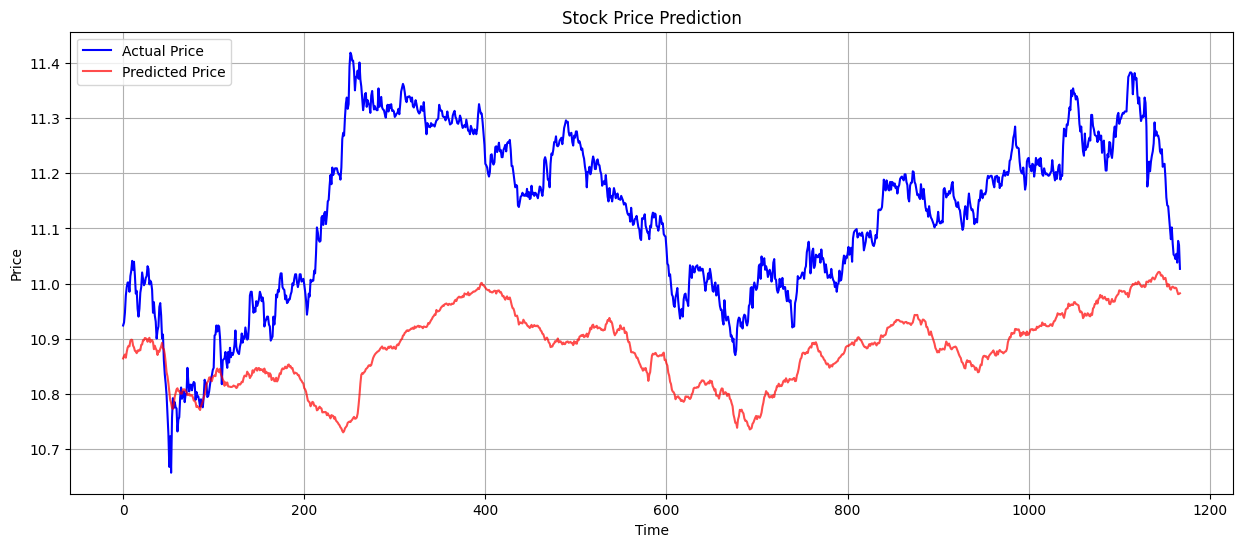

In [ ]:
predictplot(model, x_test, y_test, y_scaler)

###2

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=128, ff_dim=256, num_blocks=4, dropout_rate=0.4,lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 48s - 869ms/step - loss: 0.5314 - mae: 0.5459 - val_loss: 0.0780 - val_mae: 0.2412
Epoch 2/100
55/55 - 15s - 277ms/step - loss: 0.1193 - mae: 0.2731 - val_loss: 0.1013 - val_mae: 0.2615
Epoch 3/100
55/55 - 20s - 373ms/step - loss: 0.0509 - mae: 0.1800 - val_loss: 0.0571 - val_mae: 0.2016
Epoch 4/100
55/55 - 21s - 382ms/step - loss: 0.0339 - mae: 0.1462 - val_loss: 0.0448 - val_mae: 0.1788
Epoch 5/100
55/55 - 20s - 367ms/step - loss: 0.0266 - mae: 0.1296 - val_loss: 0.0395 - val_mae: 0.1683
Epoch 6/100
55/55 - 21s - 382ms/step - loss: 0.0236 - mae: 0.1213 - val_loss: 0.0312 - val_mae: 0.1478
Epoch 7/100
55/55 - 22s - 402ms/step - loss: 0.0209 - mae: 0.1154 - val_loss: 0.0240 - val_mae: 0.1324
Epoch 8/100
55/55 - 18s - 333ms/step - loss: 0.0199 - mae: 0.1114 - val_loss: 0.0381 - val_mae: 0.1527
Epoch 9/100
55/55 - 20s - 368ms/step - loss: 0.0182 - mae: 0.1065 - val_loss: 0.0183 - val_mae: 0.1119
Epoch 10/100
55/55 - 20s - 373ms/step - loss: 0.0172 - mae: 0.1026 - val_

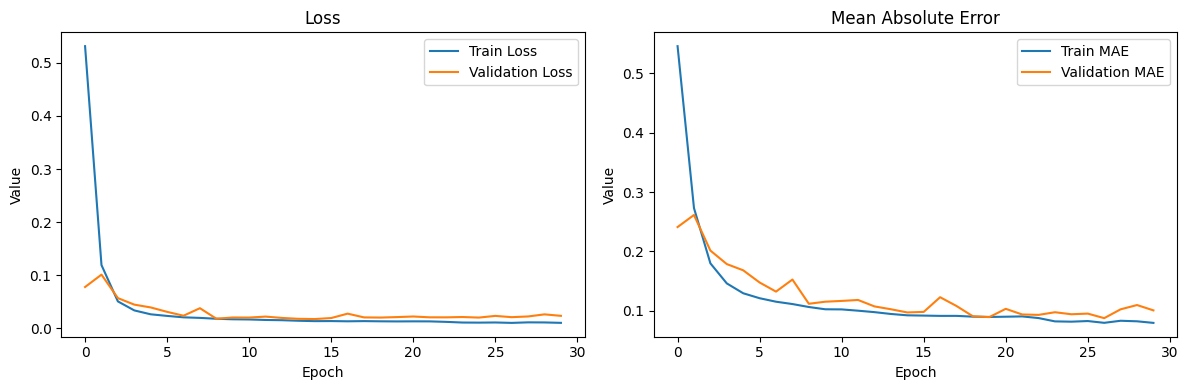

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Mean Absolute Error (MAE): 0.3910061760291322
Root Mean Squared Error (RMSE): 0.4041911975682372


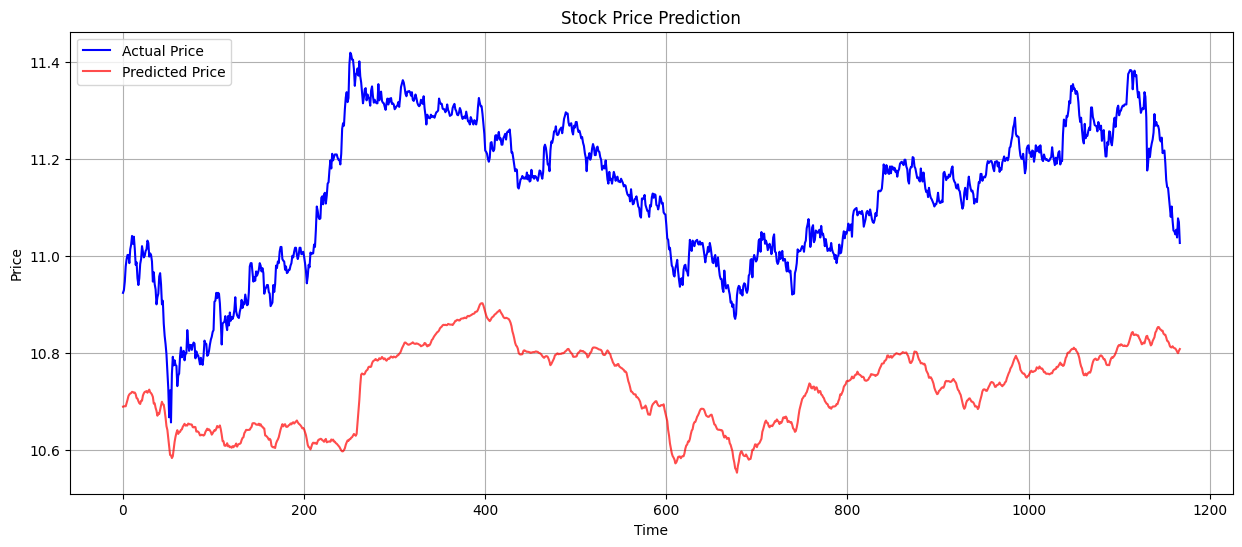

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
#model.save_weights(path+ 'final_int.weights.h5')

###3

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=16, key_dim=128, ff_dim=256, num_blocks=4, dropout_rate=0.4,lr=0.0002,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 46s - 828ms/step - loss: 0.5945 - mae: 0.5765 - val_loss: 0.0814 - val_mae: 0.2444
Epoch 2/100
55/55 - 33s - 592ms/step - loss: 0.1619 - mae: 0.3239 - val_loss: 0.0545 - val_mae: 0.1978
Epoch 3/100
55/55 - 39s - 714ms/step - loss: 0.0966 - mae: 0.2488 - val_loss: 0.0272 - val_mae: 0.1417
Epoch 4/100
55/55 - 41s - 739ms/step - loss: 0.0705 - mae: 0.2114 - val_loss: 0.0397 - val_mae: 0.1651
Epoch 5/100
55/55 - 43s - 789ms/step - loss: 0.0533 - mae: 0.1851 - val_loss: 0.0430 - val_mae: 0.1715
Epoch 6/100
55/55 - 38s - 697ms/step - loss: 0.0438 - mae: 0.1662 - val_loss: 0.0466 - val_mae: 0.1805
Epoch 7/100
55/55 - 41s - 743ms/step - loss: 0.0359 - mae: 0.1506 - val_loss: 0.0391 - val_mae: 0.1634
Epoch 8/100
55/55 - 42s - 764ms/step - loss: 0.0333 - mae: 0.1457 - val_loss: 0.0295 - val_mae: 0.1450
Epoch 9/100
55/55 - 40s - 730ms/step - loss: 0.0298 - mae: 0.1380 - val_loss: 0.0274 - val_mae: 0.1403
Epoch 10/100
55/55 - 43s - 787ms/step - loss: 0.0280 - mae: 0.1327 - val_

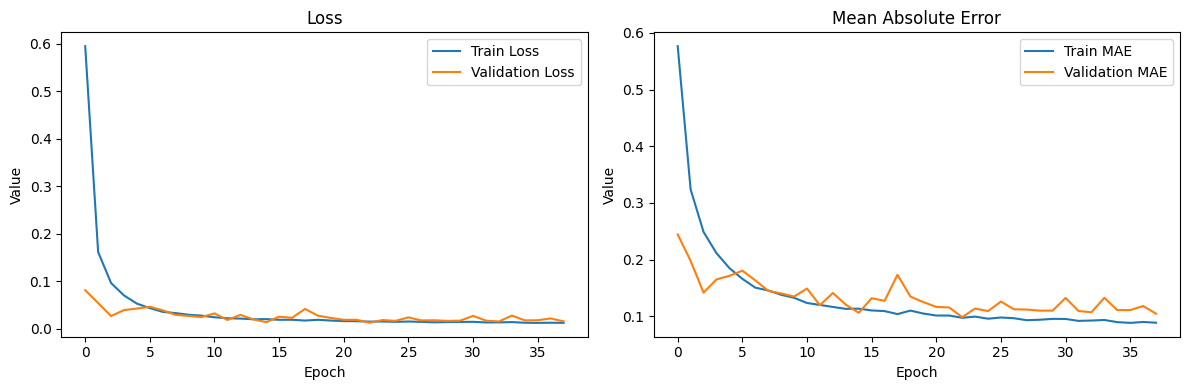

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step
Mean Absolute Error (MAE): 0.4913282013086084
Root Mean Squared Error (RMSE): 0.5104024351277325


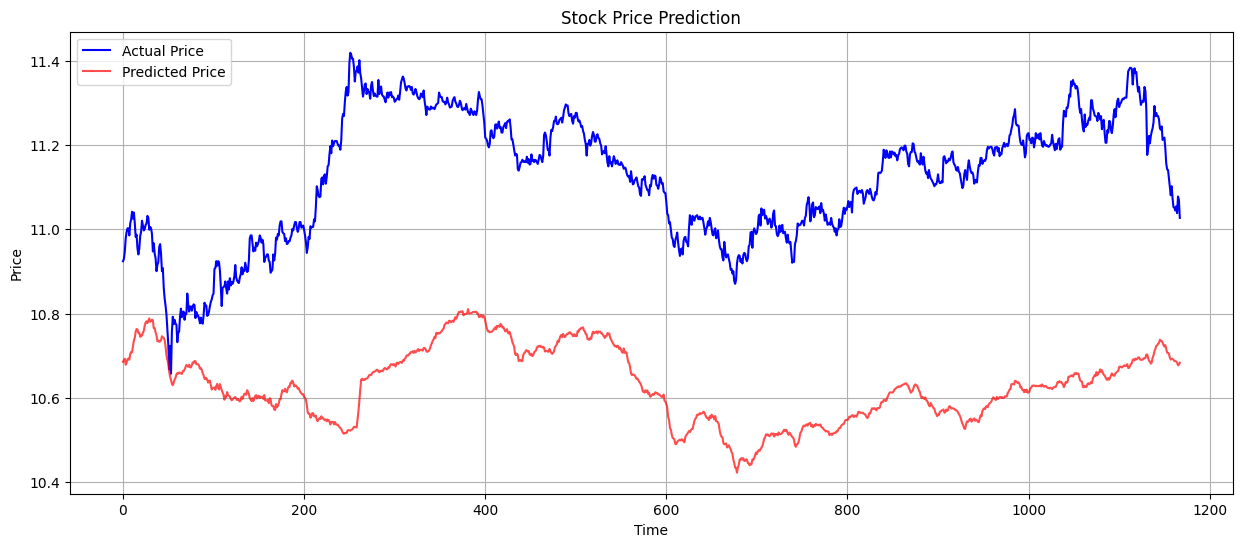

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
#model.save_weights(path+ 'final_int.weights.h5')

###4

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=32, ff_dim=128, num_blocks=4, dropout_rate=0.4,lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 19s - 354ms/step - loss: 0.6608 - mae: 0.6472 - val_loss: 0.1599 - val_mae: 0.3566
Epoch 2/100
55/55 - 5s - 98ms/step - loss: 0.3632 - mae: 0.4810 - val_loss: 0.0941 - val_mae: 0.2650
Epoch 3/100
55/55 - 4s - 74ms/step - loss: 0.2562 - mae: 0.4028 - val_loss: 0.0865 - val_mae: 0.2627
Epoch 4/100
55/55 - 7s - 123ms/step - loss: 0.1907 - mae: 0.3510 - val_loss: 0.0976 - val_mae: 0.2854
Epoch 5/100
55/55 - 5s - 89ms/step - loss: 0.1480 - mae: 0.3074 - val_loss: 0.0422 - val_mae: 0.1687
Epoch 6/100
55/55 - 4s - 78ms/step - loss: 0.1198 - mae: 0.2769 - val_loss: 0.0722 - val_mae: 0.2293
Epoch 7/100
55/55 - 5s - 93ms/step - loss: 0.0999 - mae: 0.2509 - val_loss: 0.0694 - val_mae: 0.2290
Epoch 8/100
55/55 - 9s - 168ms/step - loss: 0.0867 - mae: 0.2366 - val_loss: 0.0481 - val_mae: 0.1812
Epoch 9/100
55/55 - 7s - 130ms/step - loss: 0.0728 - mae: 0.2165 - val_loss: 0.0516 - val_mae: 0.1879
Epoch 10/100
55/55 - 8s - 148ms/step - loss: 0.0672 - mae: 0.2055 - val_loss: 0.0563 -

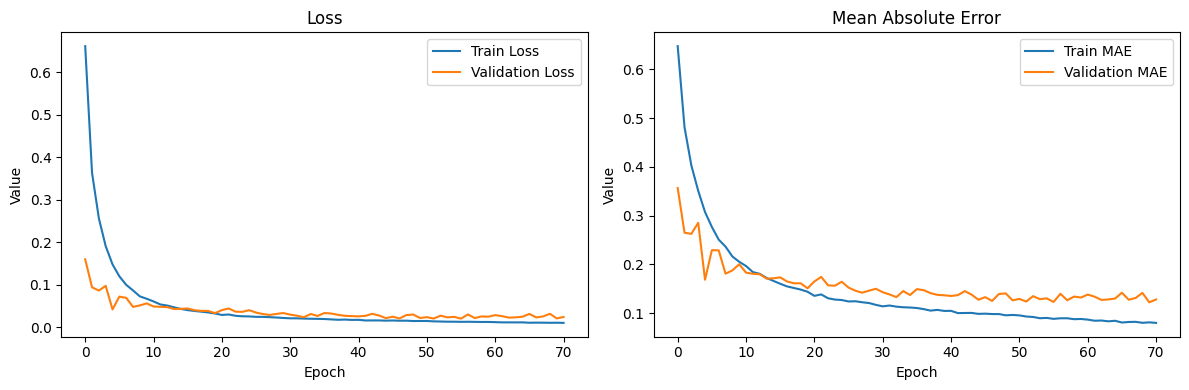

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean Absolute Error (MAE): 0.5826132961315311
Root Mean Squared Error (RMSE): 0.5949195042770133


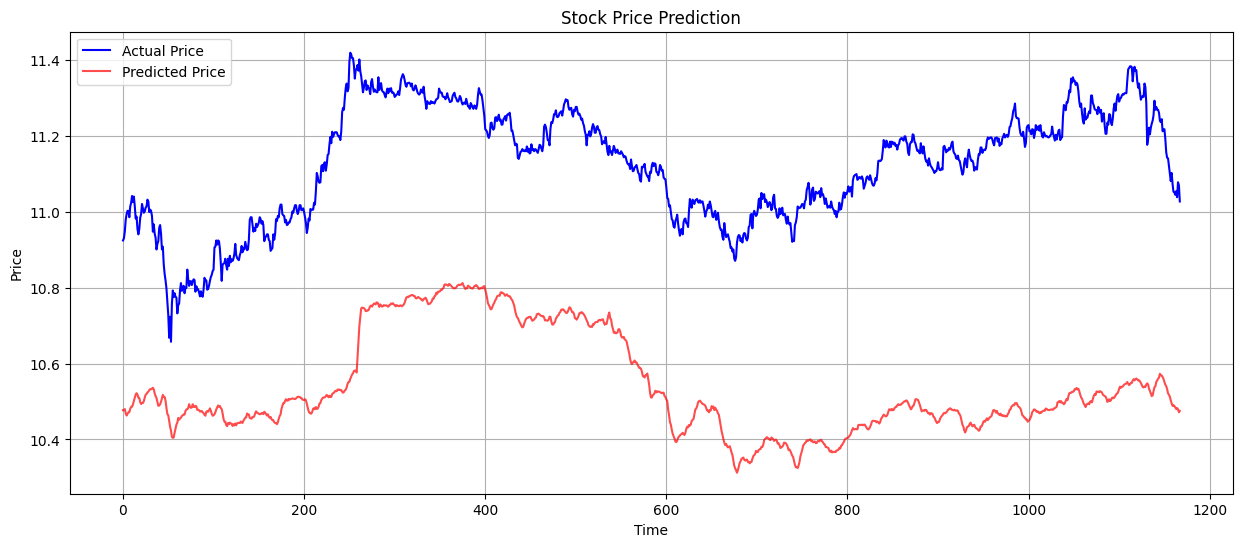

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
#model.save_weights(path+ 'final_int.weights.h5')

###5

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=32, ff_dim=128, num_blocks=2, dropout_rate=0.2,lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 10s - 182ms/step - loss: 0.6468 - mae: 0.6278 - val_loss: 0.3031 - val_mae: 0.4750
Epoch 2/100
55/55 - 2s - 40ms/step - loss: 0.2498 - mae: 0.3960 - val_loss: 0.1665 - val_mae: 0.3554
Epoch 3/100
55/55 - 2s - 38ms/step - loss: 0.1570 - mae: 0.3161 - val_loss: 0.0903 - val_mae: 0.2623
Epoch 4/100
55/55 - 3s - 58ms/step - loss: 0.1176 - mae: 0.2740 - val_loss: 0.0660 - val_mae: 0.2224
Epoch 5/100
55/55 - 3s - 58ms/step - loss: 0.0919 - mae: 0.2423 - val_loss: 0.0561 - val_mae: 0.2018
Epoch 6/100
55/55 - 2s - 37ms/step - loss: 0.0735 - mae: 0.2157 - val_loss: 0.0444 - val_mae: 0.1695
Epoch 7/100
55/55 - 3s - 46ms/step - loss: 0.0622 - mae: 0.1983 - val_loss: 0.0558 - val_mae: 0.1978
Epoch 8/100
55/55 - 3s - 46ms/step - loss: 0.0526 - mae: 0.1818 - val_loss: 0.0341 - val_mae: 0.1443
Epoch 9/100
55/55 - 3s - 49ms/step - loss: 0.0480 - mae: 0.1741 - val_loss: 0.0478 - val_mae: 0.1815
Epoch 10/100
55/55 - 4s - 69ms/step - loss: 0.0412 - mae: 0.1622 - val_loss: 0.0273 - val

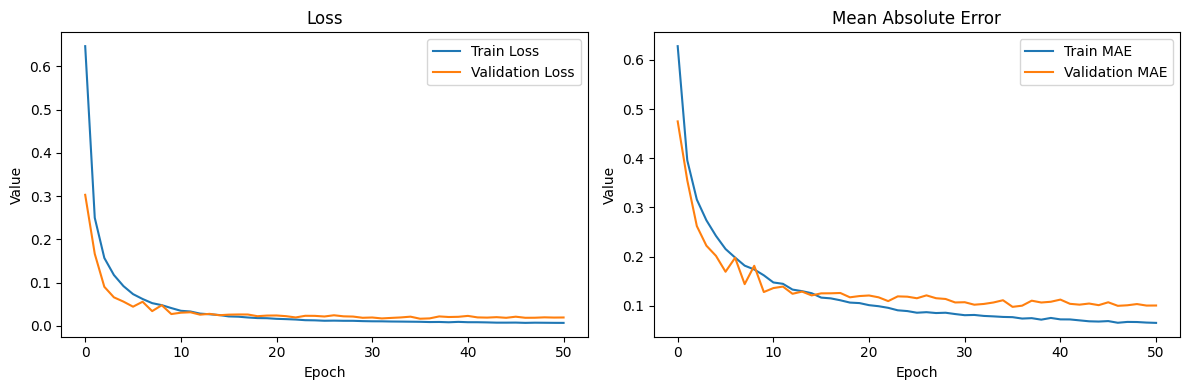

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error (MAE): 0.5691122602909872
Root Mean Squared Error (RMSE): 0.5769955378500494


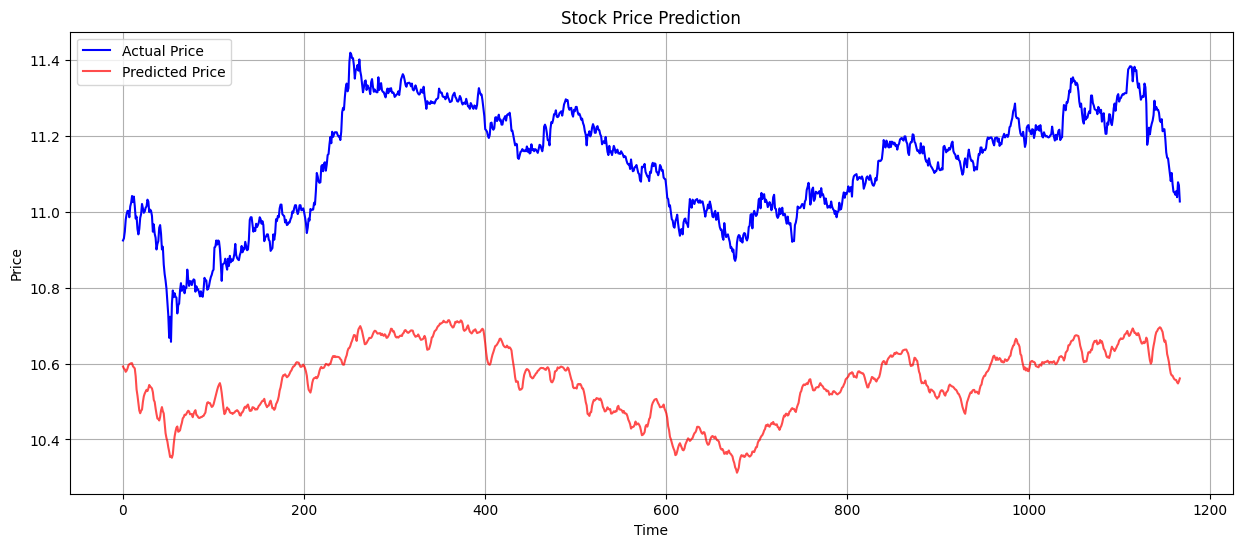

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
model.save_weights(path+ 'final_int5.weights.h5')

###6

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=32, ff_dim=128, num_blocks=2, dropout_rate=0.2,lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 10s - 174ms/step - loss: 0.3025 - mae: 0.4123 - val_loss: 0.1001 - val_mae: 0.2653
Epoch 2/100
55/55 - 2s - 40ms/step - loss: 0.0771 - mae: 0.2211 - val_loss: 0.0838 - val_mae: 0.2380
Epoch 3/100
55/55 - 3s - 48ms/step - loss: 0.0484 - mae: 0.1755 - val_loss: 0.0727 - val_mae: 0.2248
Epoch 4/100
55/55 - 4s - 68ms/step - loss: 0.0342 - mae: 0.1472 - val_loss: 0.0882 - val_mae: 0.2423
Epoch 5/100
55/55 - 3s - 47ms/step - loss: 0.0269 - mae: 0.1307 - val_loss: 0.0806 - val_mae: 0.2310
Epoch 6/100
55/55 - 5s - 82ms/step - loss: 0.0202 - mae: 0.1136 - val_loss: 0.0642 - val_mae: 0.2075
Epoch 7/100
55/55 - 3s - 46ms/step - loss: 0.0158 - mae: 0.1002 - val_loss: 0.0707 - val_mae: 0.2130
Epoch 8/100
55/55 - 3s - 47ms/step - loss: 0.0143 - mae: 0.0941 - val_loss: 0.0480 - val_mae: 0.1821
Epoch 9/100
55/55 - 4s - 69ms/step - loss: 0.0125 - mae: 0.0890 - val_loss: 0.0591 - val_mae: 0.1934
Epoch 10/100
55/55 - 2s - 37ms/step - loss: 0.0115 - mae: 0.0853 - val_loss: 0.0589 - val

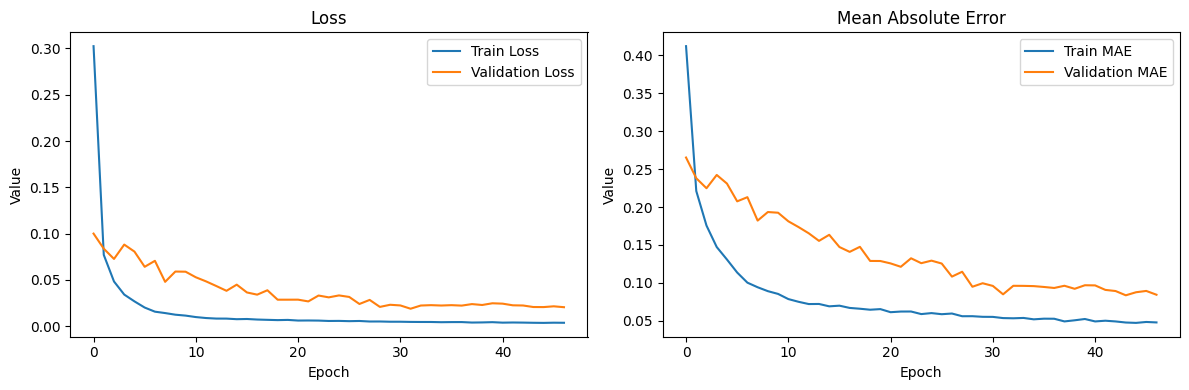

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Absolute Error (MAE): 0.31515717694037454
Root Mean Squared Error (RMSE): 0.3488525636602781


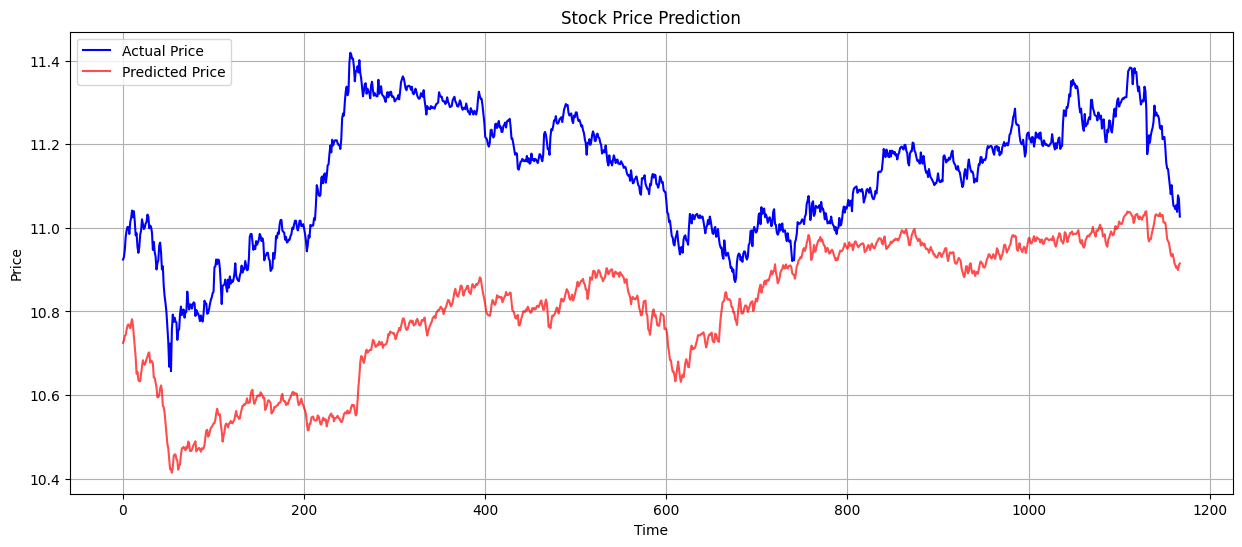

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
model.save_weights(path+ 'final_int6.weights.h5')

###6-1

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=32, ff_dim=128, num_blocks=2, dropout_rate=0.2,lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 11s - 204ms/step - loss: 0.3768 - mae: 0.4475 - val_loss: 0.0228 - val_mae: 0.1127
Epoch 2/100
55/55 - 2s - 38ms/step - loss: 0.0864 - mae: 0.2320 - val_loss: 0.0149 - val_mae: 0.0856
Epoch 3/100
55/55 - 2s - 38ms/step - loss: 0.0496 - mae: 0.1774 - val_loss: 0.0125 - val_mae: 0.0742
Epoch 4/100
55/55 - 3s - 57ms/step - loss: 0.0324 - mae: 0.1432 - val_loss: 0.0161 - val_mae: 0.0941
Epoch 5/100
55/55 - 3s - 62ms/step - loss: 0.0229 - mae: 0.1208 - val_loss: 0.0246 - val_mae: 0.1193
Epoch 6/100
55/55 - 2s - 37ms/step - loss: 0.0186 - mae: 0.1080 - val_loss: 0.0187 - val_mae: 0.1074
Epoch 7/100
55/55 - 3s - 46ms/step - loss: 0.0151 - mae: 0.0976 - val_loss: 0.0218 - val_mae: 0.1182
Epoch 8/100
55/55 - 2s - 37ms/step - loss: 0.0133 - mae: 0.0913 - val_loss: 0.0167 - val_mae: 0.1066
Epoch 9/100
55/55 - 2s - 37ms/step - loss: 0.0124 - mae: 0.0886 - val_loss: 0.0219 - val_mae: 0.1219
Epoch 10/100
55/55 - 5s - 93ms/step - loss: 0.0106 - mae: 0.0819 - val_loss: 0.0200 - val

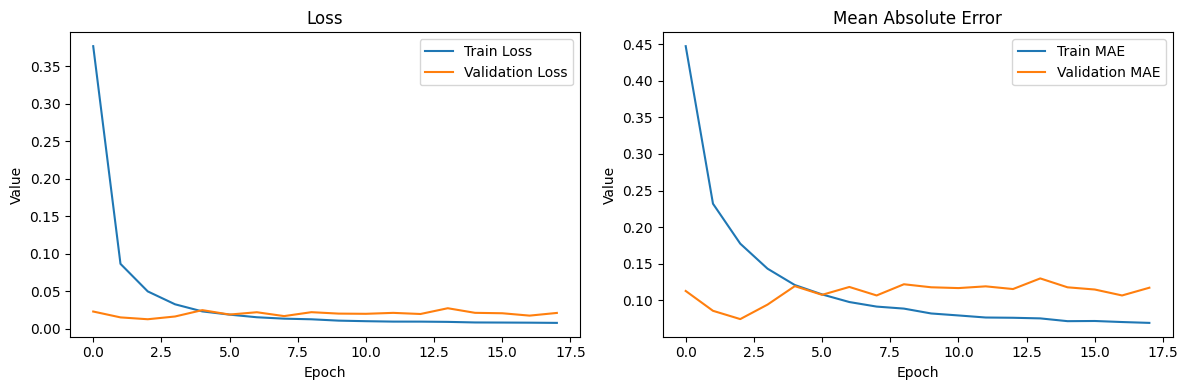

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error (MAE): 0.400030557050969
Root Mean Squared Error (RMSE): 0.4274780901426532


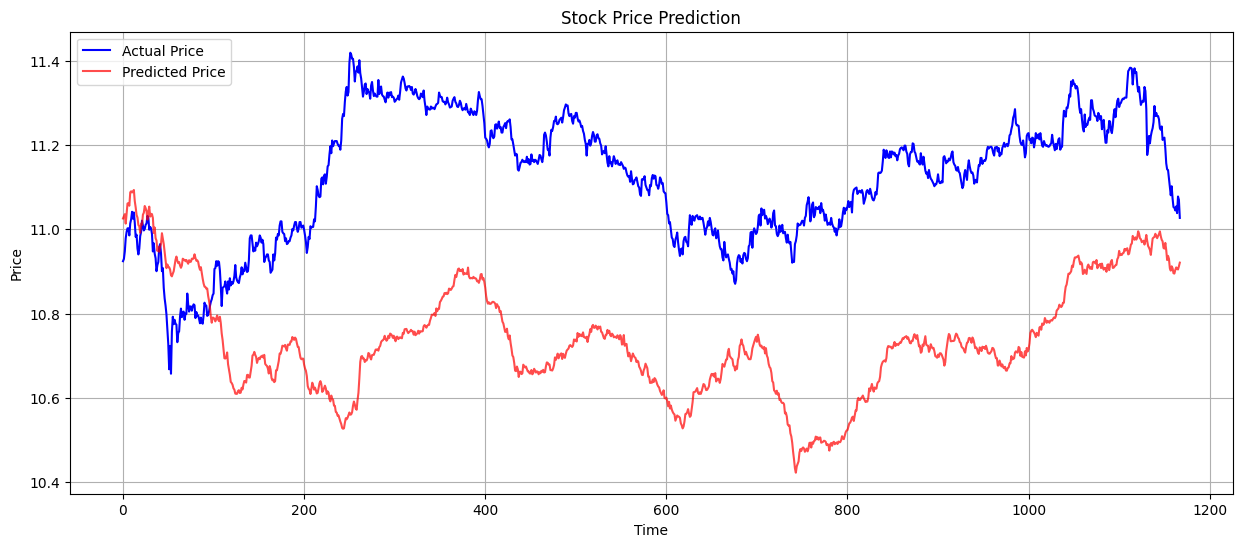

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
model.save_weights(path+ 'final_int6.weights.h5')

###6-2

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=32, ff_dim=128, num_blocks=2, dropout_rate=0.2,lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 11s - 203ms/step - loss: 0.4517 - mae: 0.5053 - val_loss: 0.0236 - val_mae: 0.1164
Epoch 2/100
55/55 - 5s - 87ms/step - loss: 0.1038 - mae: 0.2542 - val_loss: 0.0216 - val_mae: 0.1076
Epoch 3/100
55/55 - 2s - 42ms/step - loss: 0.0548 - mae: 0.1865 - val_loss: 0.0253 - val_mae: 0.1344
Epoch 4/100
55/55 - 2s - 41ms/step - loss: 0.0353 - mae: 0.1496 - val_loss: 0.0304 - val_mae: 0.1402
Epoch 5/100
55/55 - 2s - 41ms/step - loss: 0.0257 - mae: 0.1287 - val_loss: 0.0250 - val_mae: 0.1335
Epoch 6/100
55/55 - 4s - 69ms/step - loss: 0.0208 - mae: 0.1147 - val_loss: 0.0211 - val_mae: 0.1207
Epoch 7/100
55/55 - 3s - 61ms/step - loss: 0.0179 - mae: 0.1063 - val_loss: 0.0242 - val_mae: 0.1318
Epoch 8/100
55/55 - 2s - 41ms/step - loss: 0.0148 - mae: 0.0966 - val_loss: 0.0218 - val_mae: 0.1243
Epoch 9/100
55/55 - 2s - 40ms/step - loss: 0.0127 - mae: 0.0892 - val_loss: 0.0217 - val_mae: 0.1244
Epoch 10/100
55/55 - 3s - 48ms/step - loss: 0.0111 - mae: 0.0837 - val_loss: 0.0219 - val

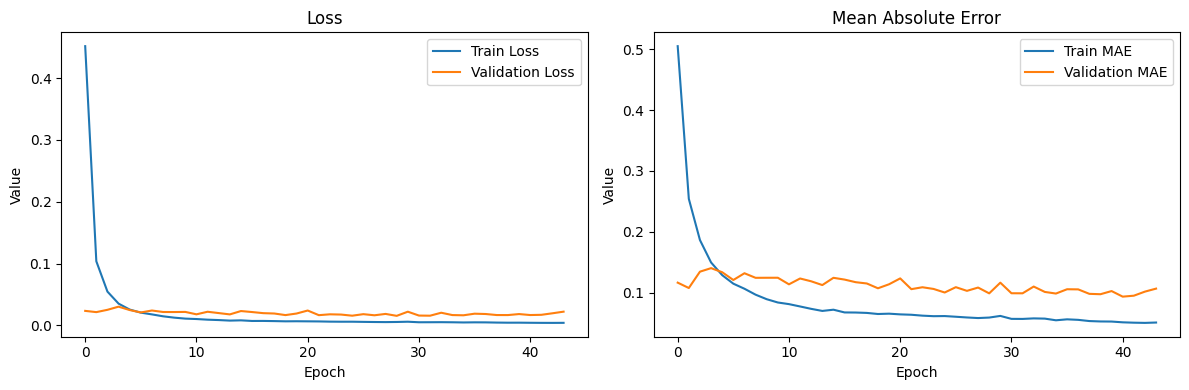

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Absolute Error (MAE): 0.5018363164695635
Root Mean Squared Error (RMSE): 0.5132141296702704


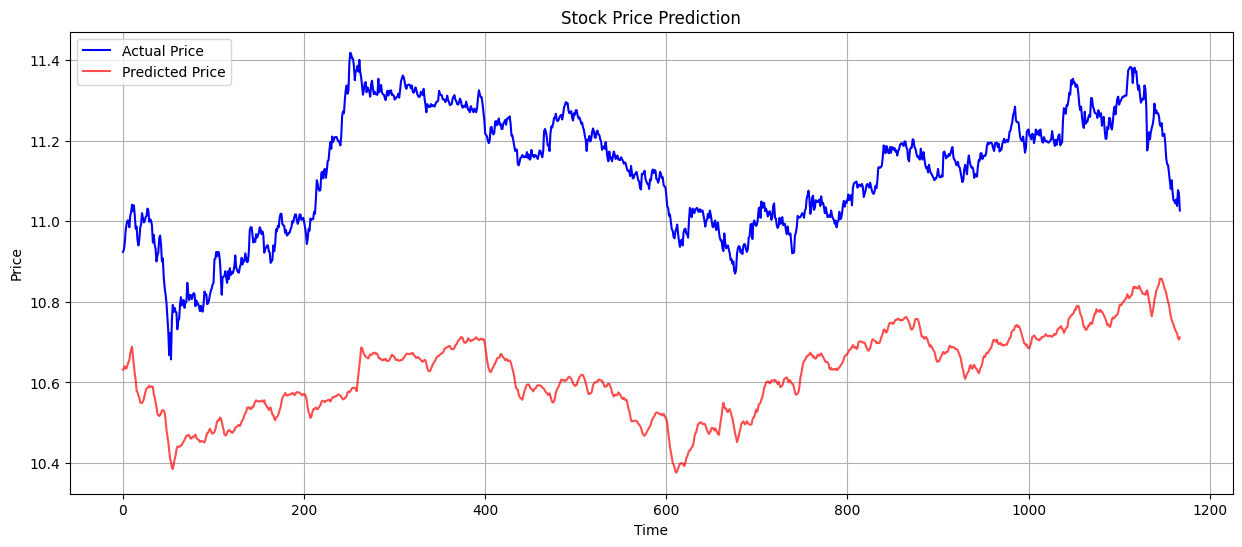

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
model.save_weights(path+ 'final_int6.weights.h5')

###7

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=32, ff_dim=128, num_blocks=2, dropout_rate=0.2,lr=0.0005,
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.95, staircase=False, ##lrs씀
    epochs=100, batch_size=64
)
#lossplot(history)
#predictplot(model, x_test, y_test, y_scaler)

Epoch 1/100
55/55 - 11s - 192ms/step - loss: 0.5763 - mae: 0.5331 - val_loss: 0.1587 - val_mae: 0.3339
Epoch 2/100
55/55 - 2s - 37ms/step - loss: 0.0690 - mae: 0.2091 - val_loss: 0.0738 - val_mae: 0.2160
Epoch 3/100
55/55 - 2s - 37ms/step - loss: 0.0358 - mae: 0.1506 - val_loss: 0.0614 - val_mae: 0.1956
Epoch 4/100
55/55 - 3s - 51ms/step - loss: 0.0236 - mae: 0.1217 - val_loss: 0.0413 - val_mae: 0.1693
Epoch 5/100
55/55 - 4s - 81ms/step - loss: 0.0173 - mae: 0.1051 - val_loss: 0.0582 - val_mae: 0.1907
Epoch 6/100
55/55 - 2s - 38ms/step - loss: 0.0131 - mae: 0.0897 - val_loss: 0.0316 - val_mae: 0.1502
Epoch 7/100
55/55 - 3s - 46ms/step - loss: 0.0103 - mae: 0.0807 - val_loss: 0.0258 - val_mae: 0.1360
Epoch 8/100
55/55 - 3s - 46ms/step - loss: 0.0094 - mae: 0.0766 - val_loss: 0.0237 - val_mae: 0.1284
Epoch 9/100
55/55 - 4s - 66ms/step - loss: 0.0093 - mae: 0.0757 - val_loss: 0.0226 - val_mae: 0.1262
Epoch 10/100
55/55 - 4s - 64ms/step - loss: 0.0078 - mae: 0.0701 - val_loss: 0.0213 - val

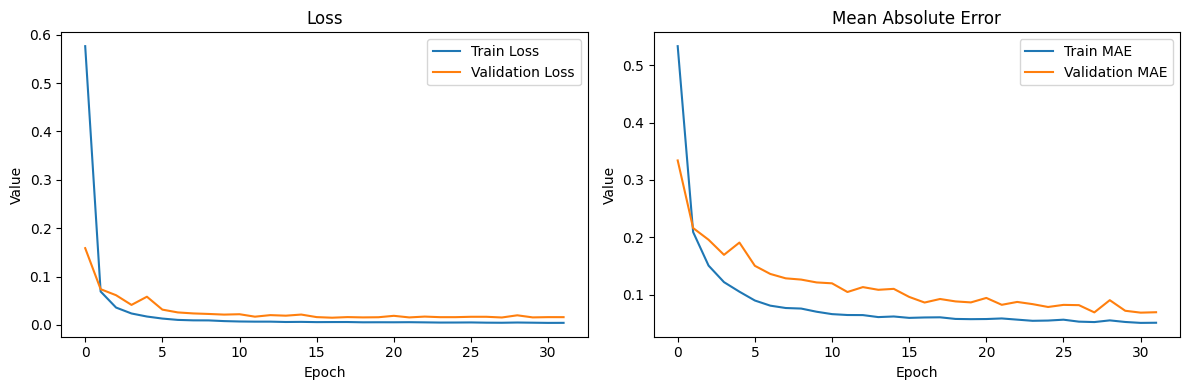

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Mean Absolute Error (MAE): 0.5074267144872378
Root Mean Squared Error (RMSE): 0.5223548973671047


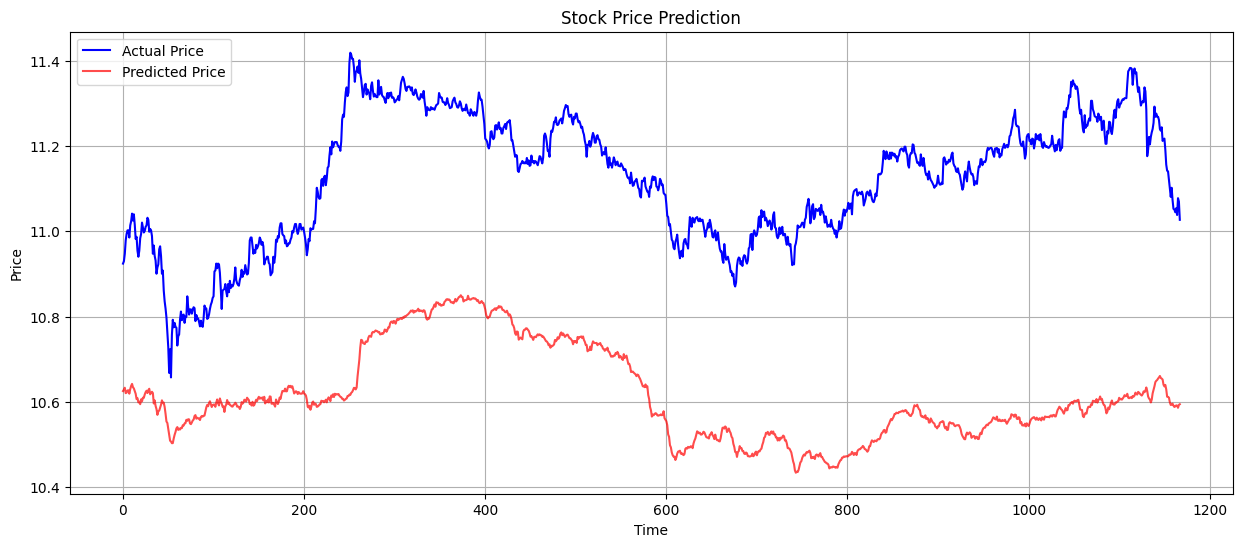

In [ ]:
predictplot(model, x_test, y_test, y_scaler)
#model.save_weights(path+ 'final_int6.weights.h5')

# 하이퍼파라미터 튜닝

In [ ]:
!pip install keras_tuner

In [ ]:
import keras_tuner as kt

def build_transformer_model(hp):
    input_shape = (seq_length, x_train.shape[-1])
    inputs = layers.Input(shape=input_shape)
    x = PositionalEncoding(sequence_length=seq_length, d_model=x_train.shape[-1])(inputs)

    num_blocks = hp.Int('num_blocks', min_value=2, max_value=3, step=1)
    num_heads = hp.Choice('num_heads', values=[2, 4, 8])
    key_dim = hp.Int('key_dim', min_value=32, max_value=128, step=32)
    ff_dim = hp.Int('ff_dim', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    initial_learning_rate = hp.Float('initial_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")

    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_rate)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = tf.keras.Model(inputs, outputs)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model

# Keras Tuner를 실행하여 하이퍼파라미터 튜닝
def run_tuner():
    tuner = kt.Hyperband(
        build_transformer_model,
        objective='val_loss',
        max_epochs=20,
        factor=3,
        directory='tuner_dir',
        project_name='transformer_tuning'
    )

    # 데이터로 모델 학습 및 튜닝 수행
    tuner.search(x_train, y_train, validation_split=0.2, batch_size=32)

    # 최적의 하이퍼파라미터 탐색 결과 출력
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best Hyperparameters:")
    print(f"Number of Transformer Blocks: {best_hps.get('num_blocks')}")
    print(f"Number of Attention Heads: {best_hps.get('num_heads')}")
    print(f"Key Dimension Size: {best_hps.get('key_dim')}")
    print(f"Feed-Forward Dim: {best_hps.get('ff_dim')}")
    print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
    print(f"Initial Learning Rate: {best_hps.get('initial_learning_rate')}")

    model = tuner.hypermodel.build(best_hps)
    model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=32)

run_tuner()

Trial 30 Complete [00h 00m 34s]
val_loss: 0.0005677847075276077

Best val_loss So Far: 0.00043878998258151114
Total elapsed time: 00h 17m 33s
Best Hyperparameters:
Number of Transformer Blocks: 2
Number of Attention Heads: 2
Key Dimension Size: 128
Feed-Forward Dim: 192
Dropout Rate: 0.2
Initial Learning Rate: 8.217112505860899e-05
Epoch 1/20


# 변경전

### 1

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.5591 - mae: 0.5588 - val_loss: 0.1336 - val_mae: 0.3384
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0468 - mae: 0.1718 - val_loss: 0.0719 - val_mae: 0.2273
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169 - mae: 0.1034 - val_loss: 0.0529 - val_mae: 0.1898
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - mae: 0.0761 - val_loss: 0.0711 - val_mae: 0.2335
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - mae: 0.0680 - val_loss: 0.0454 - val_mae: 0.1779
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - mae: 0.0638 - val_loss: 0.0366 - val_mae: 0.1602
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0638 - val_loss: 0.0316 - val_mae: 0.1518
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0629 - val_loss: 0.0562 - val_mae: 0.2017
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

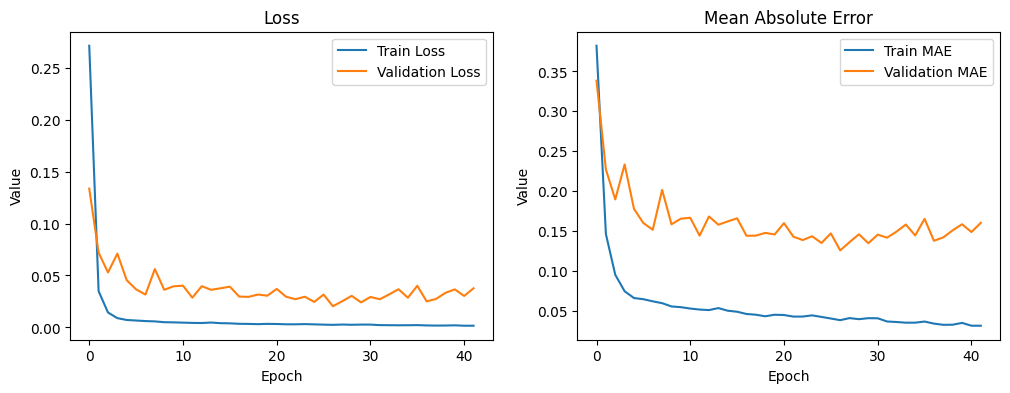

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 0.7838505811054073
Root Mean Squared Error (RMSE): 0.8022740240408099


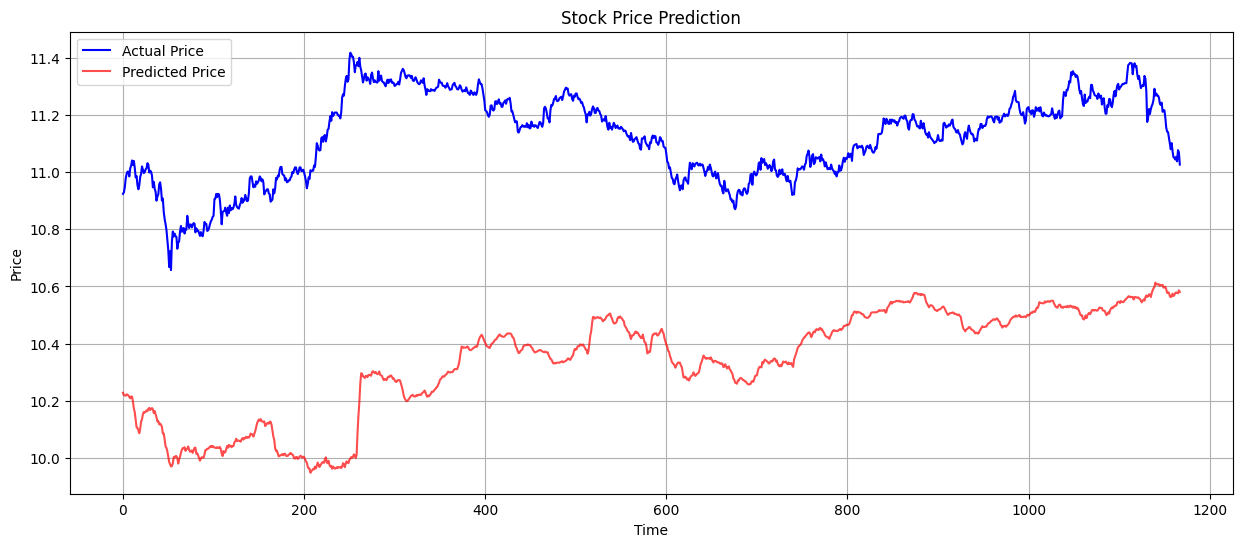

In [ ]:
y_pred = model.predict(x_test)

# 스케일 복원
y_test_actual = y_scaler.inverse_transform(y_test)
y_pred_actual = y_scaler.inverse_transform(y_pred)

# 오차 계산
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# 그래프 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label="Actual Price", color="b")
plt.plot(y_pred_actual, label="Predicted Price", color="r", alpha=0.7)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


### 2

In [ ]:
# Best Hyperparameters:
# Number of Transformer Blocks: 2
# Number of Attention Heads: 2
# Key Dimension Size: 128
# Feed-Forward Dim: 192
# Dropout Rate: 0.2
# Initial Learning Rate: 8.217112505860899e-05

x_train, y_train = create_sequences(x_train_same0, y_train_same0, seq_length)
x_val, y_val = create_sequences(x_val_same0, y_val_same0, seq_length)
x_test, y_test = create_sequences(x_test_same0, y_test_same0, seq_length)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=300,
    batch_size=32,
    #callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 0.0144 - val_mae: 0.1016
Epoch 2/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.5876e-04 - mae: 0.0229 - val_loss: 0.0122 - val_mae: 0.0932
Epoch 3/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0082 - val_mae: 0.0798
Epoch 4/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0010 - mae: 0.0233 - val_loss: 0.0106 - val_mae: 0.0870
Epoch 5/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.9464e-04 - mae: 0.0229 - val_loss: 0.0098 - val_mae: 0.0840
Epoch 6/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.5656e-04 - mae: 0.0225 - val_loss: 0.0102 - val_mae: 0.0856
Epoch 7/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 9.5157e-04 - mae: 0.0227 - val_loss: 0.0094 - val_mae: 0.0831
Epoch 8/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.0993e-04 - mae: 0.0223 - val_loss: 0.0146 - val_mae: 0.1030
Epoch 9/300
110/110 

KeyboardInterrupt: 

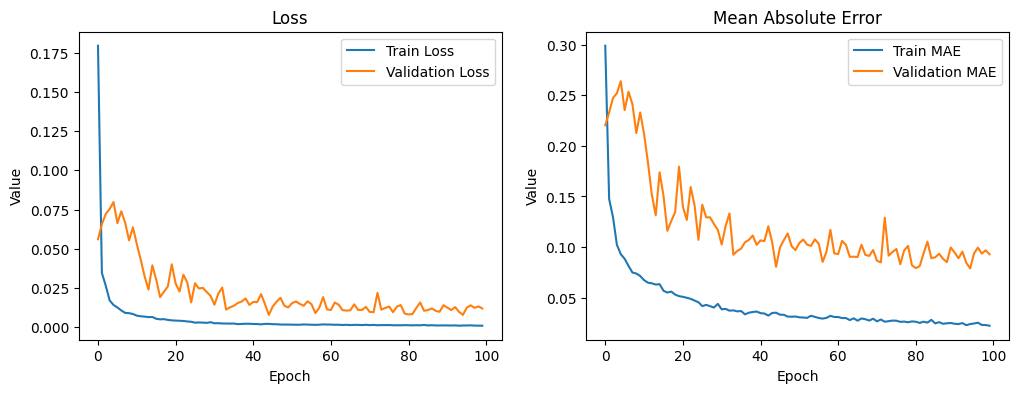

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error (MAE): 0.8509779909685526
Root Mean Squared Error (RMSE): 0.8619285547071226


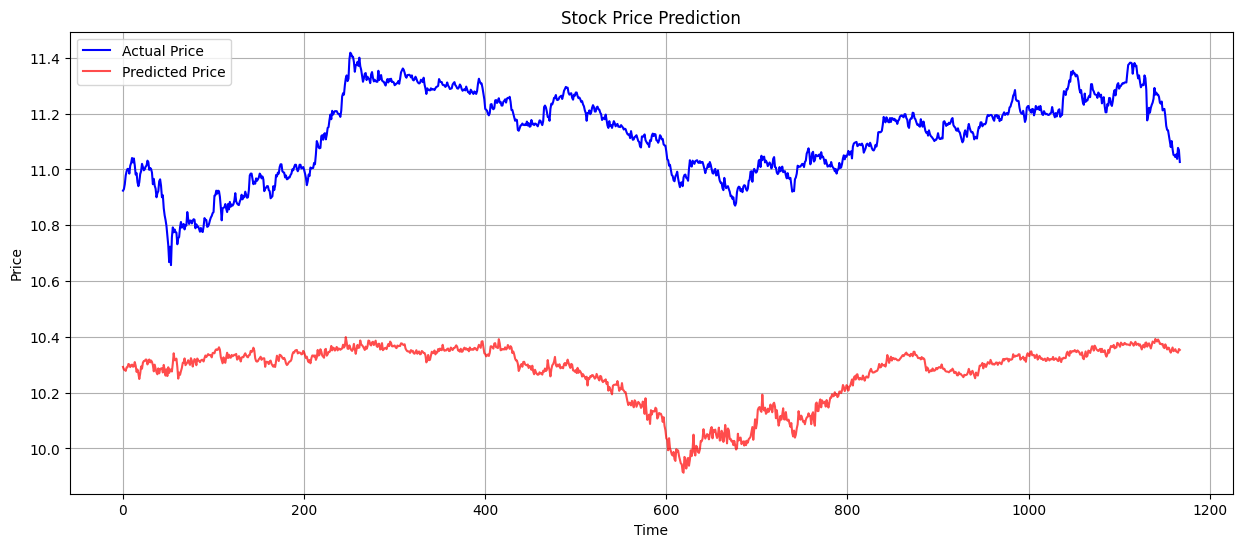

In [ ]:
y_pred = model.predict(x_test)

# 스케일 복원
y_test_actual = y_scaler.inverse_transform(y_test)
y_pred_actual = y_scaler.inverse_transform(y_pred)

# 오차 계산
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# 그래프 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label="Actual Price", color="b")
plt.plot(y_pred_actual, label="Predicted Price", color="r", alpha=0.7)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()
